# Dataset cleaning

Our main goal in this notebook is to turn the level 1 data provided in the [main dataset](https://www.spaceappschallenge.org/develop-the-oracle-of-dscovr-experimental-data-repository/) into level 2 data through data processing and feature engineering.

In [2]:
import pandas as pd
import numpy as np
import pycatch22
import json
import pdb
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score
import ray

import warnings
warnings.filterwarnings(action='ignore')

import os
import gc
import pdb
import keras
import urllib3
import tensorflow
from sklearn import metrics
from xgboost import XGBClassifier
from keras.models import load_model
from bayes_opt import BayesianOptimization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import math

Here, we read the .csv files that are in the same folder than this jupyter notebook:

In [6]:
i = 2016
dataDSCOVR = pd.read_csv('dsc_fc_summed_spectra_'+str(i)+'_v01.csv',delimiter = ',', parse_dates=[0], \
infer_datetime_format=True, na_values='0', \
header = None)


for i in range(2017, 2024): # dataDSCOVR2016 already read.
    aux = pd.read_csv('dsc_fc_summed_spectra_'+str(i)+'_v01.csv',delimiter = ',', parse_dates=[0], \
      infer_datetime_format=True, na_values='0', \
      header = None)

    dataDSCOVR = pd.concat([dataDSCOVR, aux])

Changing the of all column features:

In [7]:
# dataDSCOVR.drop(dataDSCOVR.columns.difference([0,1, 2, 3]), 1, inplace=True)
new_cols = ['datetime', 'E_x', 'E_y', 'E_z']
new_cols += ['f_cup_'+str(i) for i in range(50)]
dataDSCOVR.columns = new_cols

and oppening the K$_p$ dataset from .json

In [8]:
f = open('kp.json')
kps = json.load(f)
kps = pd.DataFrame({'datetime': kps['datetime'], 'kp':kps["Kp"]})
kps.replace(['T', 'Z'], [' ',''], regex=True, inplace=True)
kps

datetime     kp
0      2016-01-01 00:00:00  6.000
1      2016-01-01 03:00:00  5.333
2      2016-01-01 06:00:00  5.000
3      2016-01-01 09:00:00  3.333
4      2016-01-01 12:00:00  1.667
...                    ...    ...
22683  2023-10-06 09:00:00  1.667
22684  2023-10-06 12:00:00  1.000
22685  2023-10-06 15:00:00  1.333
22686  2023-10-06 18:00:00  1.000
22687  2023-10-06 21:00:00  3.000

[22688 rows x 2 columns]

Reseting the index:

In [9]:
dataDSCOVR.reset_index()

index            datetime      E_x      E_y        E_z   f_cup_0  \
0             0 2016-01-01 00:00:00  6.83609 -3.37934 -12.920500       NaN   
1             1 2016-01-01 00:01:00  6.76732 -3.30194 -12.996700       NaN   
2             2 2016-01-01 00:02:00  6.39107 -2.61173 -13.327100       NaN   
3             3 2016-01-01 00:03:00  6.44897 -2.61525 -13.329900       NaN   
4             4 2016-01-01 00:04:00  6.58758 -2.73082 -13.236100       NaN   
...         ...                 ...      ...      ...        ...       ...   
3277435  175675 2023-05-02 23:55:00  4.33665  2.80127   0.954633  1.004790   
3277436  175676 2023-05-02 23:56:00  4.66778  2.10582   1.260660  0.781621   
3277437  175677 2023-05-02 23:57:00  4.28322  3.02154   0.927773  0.854185   
3277438  175678 2023-05-02 23:58:00  4.31376  2.67727   1.723270  0.801559   
3277439  175679 2023-05-02 23:59:00  4.51542  2.30317   1.832570  2.265740   

          f_cup_1   f_cup_2   f_cup_3  f_cup_4  ...  f_cup_40  f_cup_41  \
0             NaN       NaN       NaN      NaN  ...       NaN       NaN   
1             NaN       NaN       NaN      NaN  ...       NaN       NaN   
2             NaN       NaN       NaN      NaN  ...       NaN       NaN   
3             NaN       NaN       NaN      NaN  ...       NaN       NaN   
4             NaN       NaN       NaN      NaN  ...       NaN       NaN   
...           ...       ...       ...      ...  ...       ...       ...   
3277435  0.231726   4.64757  0.626576  3.54595  ...       NaN       NaN   
3277436  0.231726   5.97222  0.360648  3.39143  ...       NaN       NaN   
3277437  0.231726   8.10454  2.025800  4.22000  ...       NaN       NaN   
3277438  0.231726  12.76210  2.818550  4.82242  ...       NaN       NaN   
3277439  0.231726  11.68700  1.892900  2.39384  ...       NaN       NaN   

         f_cup_42  f_cup_43  f_cup_44  f_cup_45  f_cup_46  f_cup_47  f_cup_48  \
0             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
3277435       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3277436       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3277437       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3277438       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3277439       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

         f_cup_49  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
3277435       NaN  
3277436       NaN  
3277437       NaN  
3277438       NaN  
3277439       NaN  

[3277440 rows x 55 columns]

Matching dates of K$_p$ and DSCOVR dataset

In [10]:
for idx, i in enumerate(kps['datetime'].iloc[:]):
    if i > str(dataDSCOVR['datetime'].iloc[-1]):
        kps.drop(idx, inplace=True)

dataDSCOVR.reset_index(drop=True, inplace=True)

for idx, i in enumerate(dataDSCOVR['datetime'].iloc[:]):
    if str(i) > str(kps['datetime'].iloc[-1]):
        dataDSCOVR.drop(idx, inplace=True)

Getting the value of K$_p$ per measasurement of main dataset:

In [15]:
indices = []
elements = []
ini_j = 0

for idx_i, i in enumerate(kps['datetime'].iloc[:]):
  if idx_i > 0:
    val = kps['kp'][idx_i]

    for idx_j in range(ini_j, len(dataDSCOVR['datetime'].iloc[:])):
      j_val = dataDSCOVR['datetime'].iloc[idx_j]
      if str(i) >= str(j_val):
        elements.append(val)
        indices.append(idx_i-1)
      else:
        break

    ini_j = idx_j


Setting the K$_p$ and the index in the same dataset. Here, when two or more measurements have the same index number, implies they happen in the same 3 hours interval.

In [16]:
dataDSCOVR['kp'] = elements
dataDSCOVR['idx'] = indices

Visualization of the data:

In [17]:
dataDSCOVR

datetime      E_x      E_y        E_z   f_cup_0   f_cup_1  \
0       2016-01-01 00:00:00  6.83609 -3.37934 -12.920500       NaN       NaN   
1       2016-01-01 00:01:00  6.76732 -3.30194 -12.996700       NaN       NaN   
2       2016-01-01 00:02:00  6.39107 -2.61173 -13.327100       NaN       NaN   
3       2016-01-01 00:03:00  6.44897 -2.61525 -13.329900       NaN       NaN   
4       2016-01-01 00:04:00  6.58758 -2.73082 -13.236100       NaN       NaN   
...                     ...      ...      ...        ...       ...       ...   
3277256 2023-05-02 20:56:00  4.39297  2.71839  -0.446718  0.618360  0.231726   
3277257 2023-05-02 20:57:00  4.15341  2.81890  -1.188930  0.231726  0.231726   
3277258 2023-05-02 20:58:00  3.68157  3.23417  -1.221200  2.203270  0.231726   
3277259 2023-05-02 20:59:00  3.88026  2.68123  -1.736670  2.074320  0.231726   
3277260 2023-05-02 21:00:00  3.91836  2.64597  -1.864430  4.076740  0.231726   

          f_cup_2    f_cup_3  f_cup_4   f_cup_5  ...  f_cup_42  f_cup_43  \
0             NaN        NaN      NaN       NaN  ...       NaN       NaN   
1             NaN        NaN      NaN       NaN  ...       NaN       NaN   
2             NaN        NaN      NaN       NaN  ...       NaN       NaN   
3             NaN        NaN      NaN       NaN  ...       NaN       NaN   
4             NaN        NaN      NaN       NaN  ...       NaN       NaN   
...           ...        ...      ...       ...  ...       ...       ...   
3277256  12.42580  12.927500  6.16945  0.361102  ...       NaN       NaN   
3277257  19.71780  24.135800  4.39875  0.231726  ...       NaN       NaN   
3277258  14.45130  11.234300  3.25098  0.448420  ...       NaN       NaN   
3277259  11.98320  12.397100  7.44632  0.353663  ...       NaN       NaN   
3277260   6.40565   0.557139  5.08563  0.422132  ...       NaN       NaN   

         f_cup_44  f_cup_45  f_cup_46  f_cup_47  f_cup_48  f_cup_49     kp  \
0             NaN       NaN       NaN       NaN       NaN       NaN  5.333   
1             NaN       NaN       NaN       NaN       NaN       NaN  5.333   
2             NaN       NaN       NaN       NaN       NaN       NaN  5.333   
3             NaN       NaN       NaN       NaN       NaN       NaN  5.333   
4             NaN       NaN       NaN       NaN       NaN       NaN  5.333   
...           ...       ...       ...       ...       ...       ...    ...   
3277256       NaN       NaN       NaN       NaN       NaN       NaN  0.667   
3277257       NaN       NaN       NaN       NaN       NaN       NaN  0.667   
3277258       NaN       NaN       NaN       NaN       NaN       NaN  0.667   
3277259       NaN       NaN       NaN       NaN       NaN       NaN  0.667   
3277260       NaN       NaN       NaN       NaN       NaN       NaN  0.667   

           idx  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
3277256  21430  
3277257  21430  
3277258  21430  
3277259  21430  
3277260  21430  

[3277261 rows x 56 columns]

For Feature engeneering we will need to first define a numerical integration function:

In [45]:
def trapezoid(x,y):
    n = len(x)
    h = (x[n-1] - x[0])/n

    I = h*(y[0] + y[n-1])/2 + h*np.sum(y[2:n-1])
    return I

In [46]:
dataDSCOVR = dataDSCOVR.dropna(subset=['E_x', 'E_y', 'E_z'])

In [47]:
dataDSCOVR.fillna(0, inplace=True)

In [48]:
dataDSCOVR.reset_index(drop=True, inplace=True)

In [65]:
dataDSCOVR.iloc[1,4:55]

f_cup_0       0.0
f_cup_1       0.0
f_cup_2       0.0
f_cup_3       0.0
f_cup_4       0.0
f_cup_5       0.0
f_cup_6       0.0
f_cup_7       0.0
f_cup_8       0.0
f_cup_9       0.0
f_cup_10      0.0
f_cup_11      0.0
f_cup_12      0.0
f_cup_13      0.0
f_cup_14      0.0
f_cup_15      0.0
f_cup_16      0.0
f_cup_17      0.0
f_cup_18      0.0
f_cup_19      0.0
f_cup_20      0.0
f_cup_21      0.0
f_cup_22      0.0
f_cup_23      0.0
f_cup_24      0.0
f_cup_25      0.0
f_cup_26      0.0
f_cup_27      0.0
f_cup_28      0.0
f_cup_29      0.0
f_cup_30      0.0
f_cup_31      0.0
f_cup_32      0.0
f_cup_33      0.0
f_cup_34      0.0
f_cup_35      0.0
f_cup_36      0.0
f_cup_37      0.0
f_cup_38      0.0
f_cup_39      0.0
f_cup_40      0.0
f_cup_41      0.0
f_cup_42      0.0
f_cup_43      0.0
f_cup_44      0.0
f_cup_45      0.0
f_cup_46      0.0
f_cup_47      0.0
f_cup_48      0.0
f_cup_49      0.0
kp          5.333
Name: 1, dtype: object

In [73]:
k = 1.380649* 10**(-23)

In [76]:
density = np.zeros(3277261)
velocity = np.zeros(3277261)
temperature = np.zeros(3277261)

for i in range(3277261):
    aux = dataDSCOVR.iloc[i, 4:55]
    den_aux = trapezoid(range(50), aux) / np.linalg.norm(aux)
    
    if den_aux == 0:
        density[i] = den_aux
        velocity[i] = 0
        temperature[i] = 0
    else:
        density[i] = den_aux
        velocity[i] = np.linalg.norm(aux)/den_aux
        temperature[i] = (2/3)*(np.linalg.norm(aux)/(k*den_aux))


IndexError: single positional indexer is out-of-bounds

In [ ]:
dataDSCOVR['Density'] = density
dataDSCOVR['Velocity'] = velocity
dataDSCOVR['Temperature'] = temperature

In [51]:
ini_idx = -1
indexes = []

for val in dataDSCOVR['idx'][:]:
  if val != ini_idx:
    indexes.append(val)
    ini_idx = val

In [52]:
def absolute_maximum_scale(series):
    return (series - series.min()) / (series.max() - series.min())

for col in dataDSCOVR.columns[1:4]:
    dataDSCOVR[col] = absolute_maximum_scale(dataDSCOVR[col])

In [53]:
time_series = []
k = []

for val in indexes:
    data = dataDSCOVR.loc[dataDSCOVR['idx'] == val]
    hour_series = []

    for col in data.columns[1:-2]:
        hour_series.append(np.array(data[col]))

    time_series.append(hour_series)
    k.append(np.array(data['kp'])[0])

In [ ]:
dataDSCOVR

In [ ]:
output = k.copy()

In [ ]:
for i, val in enumerate(output):
  if val < 6:
    output[i] = 0
  else:
    output[i] = 1

In [ ]:
output.count(1)

2

In [ ]:
@ray.remote
def catch_feat(s):
    f1 = s[0]; f2 = s[1]; f3 = s[2]
    f1 = pycatch22.catch22_all(f1)
    f2 = pycatch22.catch22_all(f2)
    f3 = pycatch22.catch22_all(f3)
    return f1['values'] + f2['values'] + f3['values']

In [ ]:
features = ray.get([catch_feat.remote(s) for s in list(zip(ft1,ft2,ft3))])

In [ ]:
features = np.array(features)
output = np.array(list(output))

In [ ]:
x_rem, x_te, y_rem, y_te = train_test_split(features, output, test_size=0.15, stratify=output, random_state=38)
x_tr, x_va, y_tr, y_va = train_test_split(x_rem, y_rem, test_size=0.15, stratify=y_rem, random_state=38)

In [ ]:
def model_optimize(learning_rate, max_depth, min_c_weight, gamma, subsample,
                   colsample_bytree):

  max_depth = round(max_depth)


  model = XGBClassifier(n_estimators = 150, max_depth=max_depth, min_child_weight=min_c_weight,
                        gamma=gamma, subsample=subsample, colsample_betree=colsample_bytree,
                        learning_rate=learning_rate, eval_metric=["logloss"], scale_pos_weight=600)

  checkpoint = ModelCheckpoint('_pesos_lstm1.h5', monitor="val_loss", verbose=0,
                                      save_best_only=True, mode='max')

  model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)], early_stopping_rounds=15, verbose=False)

  # model = load_model('_pesos_lstm1.h5')
  # os.remove("_pesos_lstm1.h5")

  results = model.evals_result()

  plt.rcParams['figure.figsize']=(20,5)
  plt.rcParams.update({'font.size': 20})

  plt.plot(results['validation_0']['logloss'])
  plt.plot(results['validation_1']['logloss'])
  plt.title('model logloss')
  plt.ylabel('logloss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig("history.png")
  plt.show()

  #predict
  y_pred = model.predict(x_te)
  y_pred = (np.asarray(y_pred)).round()
  y_pred = y_pred.astype(int)
  y_tes = y_te

  for i in y_pred:
    if math.isnan(i):
      pdb.set_trace()

  #plot confusion matrix
  plt.rcParams['figure.figsize']=(2,2)
  plt.rcParams.update({'font.size': 10})


  cf_matrix = confusion_matrix(y_tes, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
  cm_display.plot()
  plt.show()

  #display report
  relatorio = classification_report(y_tes, y_pred, target_names = ['1','2'])
  print(relatorio)

  #calculating score
  y_pred = model.predict(x_va)
  y_pred = (np.asarray(y_pred)).round()
  y_pred = y_pred.astype(int)
  y_val = np.array(y_va)

  # score = accuracy_score(y_val, y_pred) * f1_score(y_val, y_pred, average='weighted')
  score = f1_score(y_val, y_pred, average='macro')

  gc.collect()
  return score

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_c_... | subsample |
-------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:14:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


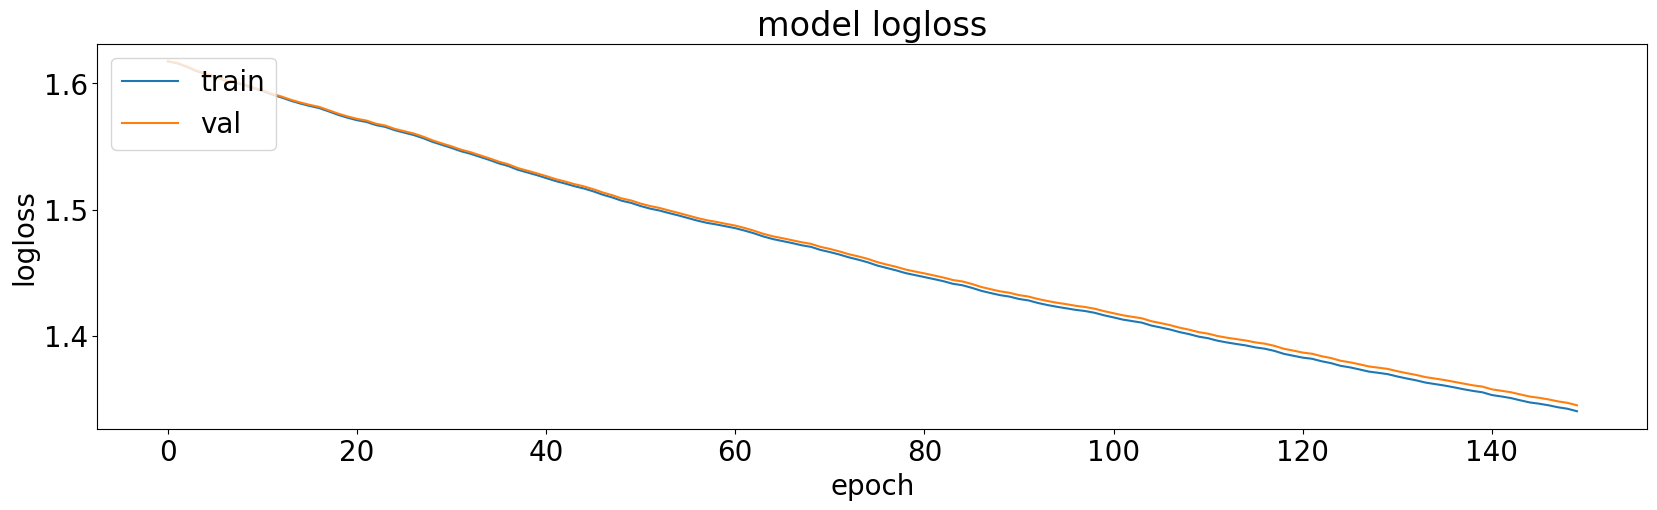

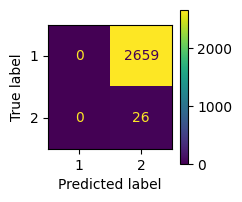

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.01      2685
   macro avg       0.00      0.50      0.01      2685
weighted avg       0.00      0.01      0.00      2685

| 1         | 0.009549  | 0.4753    | 0.2161    | 0.001011  | 6.628     | 2.321     | 0.1831    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:14:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


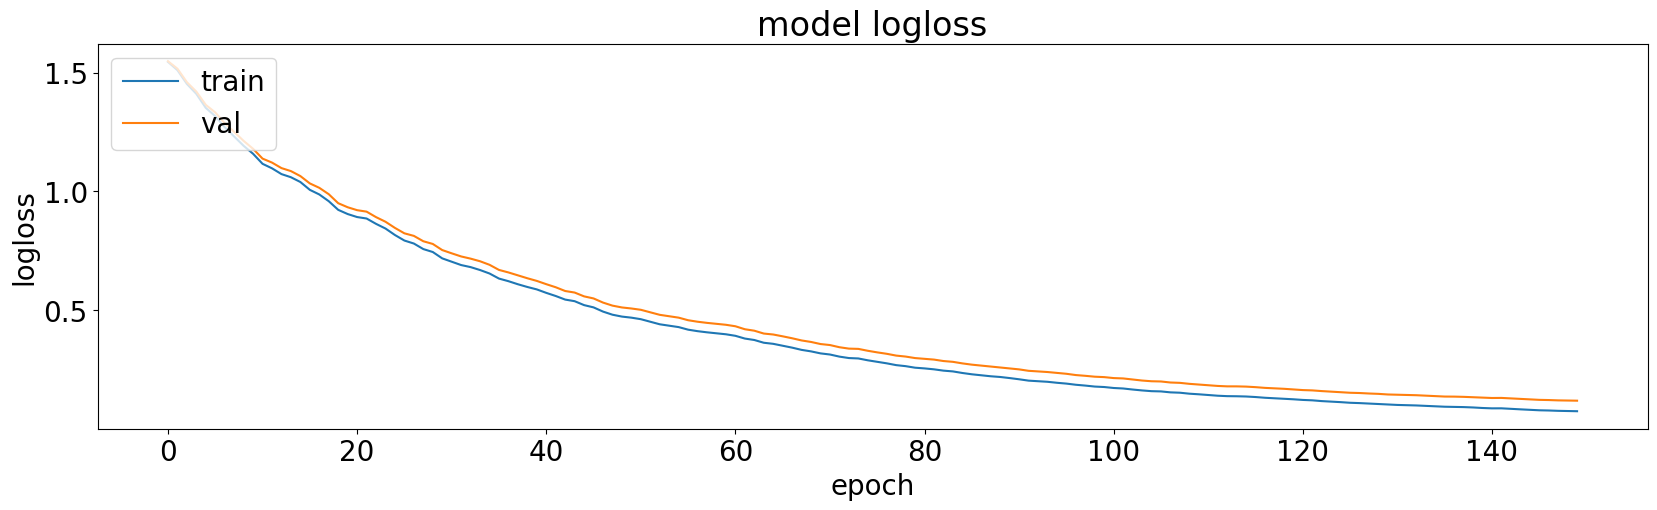

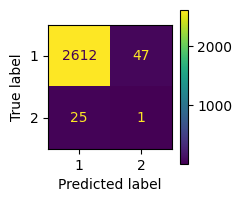

              precision    recall  f1-score   support

           1       0.99      0.98      0.99      2659
           2       0.02      0.04      0.03        26

    accuracy                           0.97      2685
   macro avg       0.51      0.51      0.51      2685
weighted avg       0.98      0.97      0.98      2685

| 2         | 0.5035    | 0.2676    | 0.1037    | 0.04028   | 9.466     | 4.773     | 0.7167    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:14:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


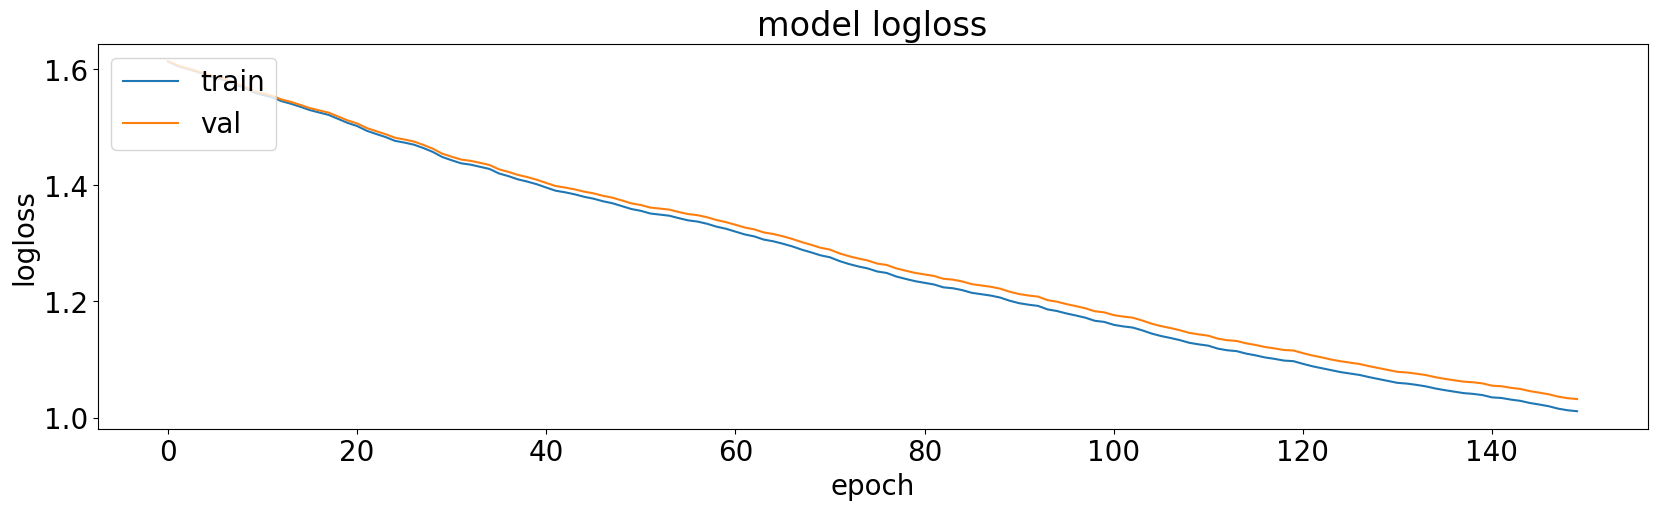

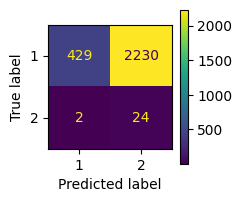

              precision    recall  f1-score   support

           1       1.00      0.16      0.28      2659
           2       0.01      0.92      0.02        26

    accuracy                           0.17      2685
   macro avg       0.50      0.54      0.15      2685
weighted avg       0.99      0.17      0.28      2685

| 3         | 0.1532    | 0.284     | 0.2634    | 0.003711  | 11.05     | 4.756     | 0.6028    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:14:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


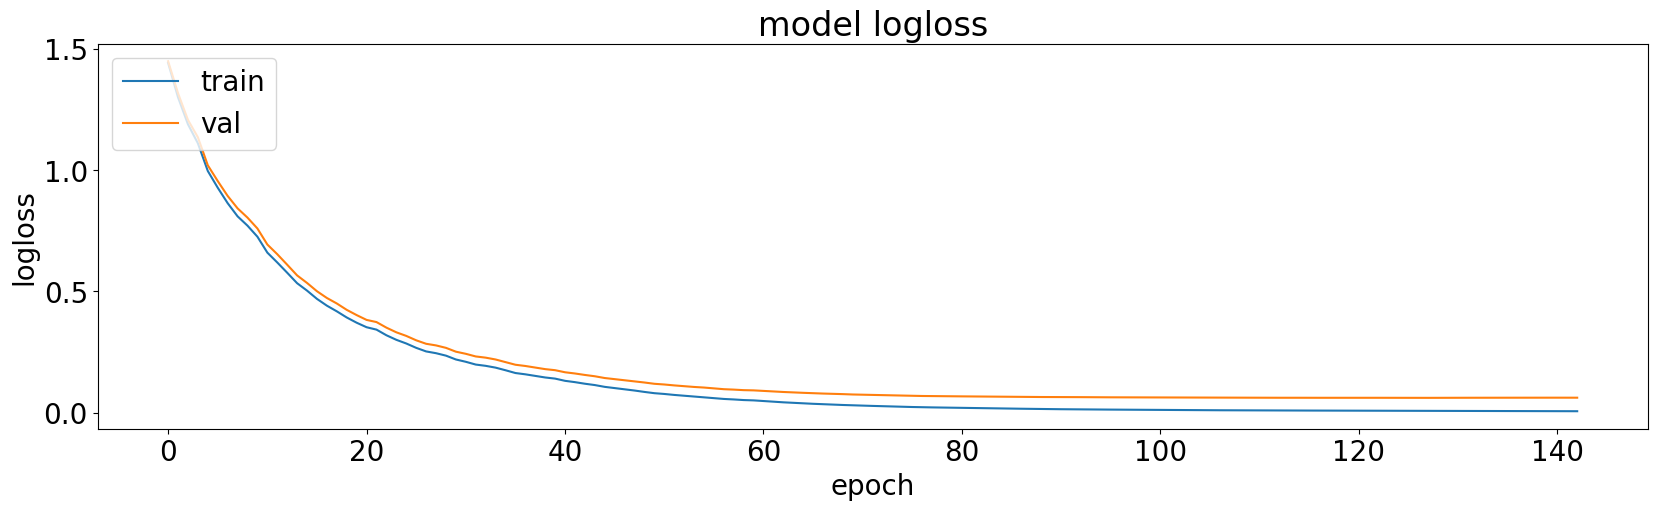

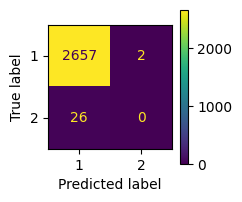

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.99      2685

| 4         | 0.4974    | 0.2263    | 0.05943   | 0.08027   | 14.62     | 3.821     | 0.7231    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:14:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


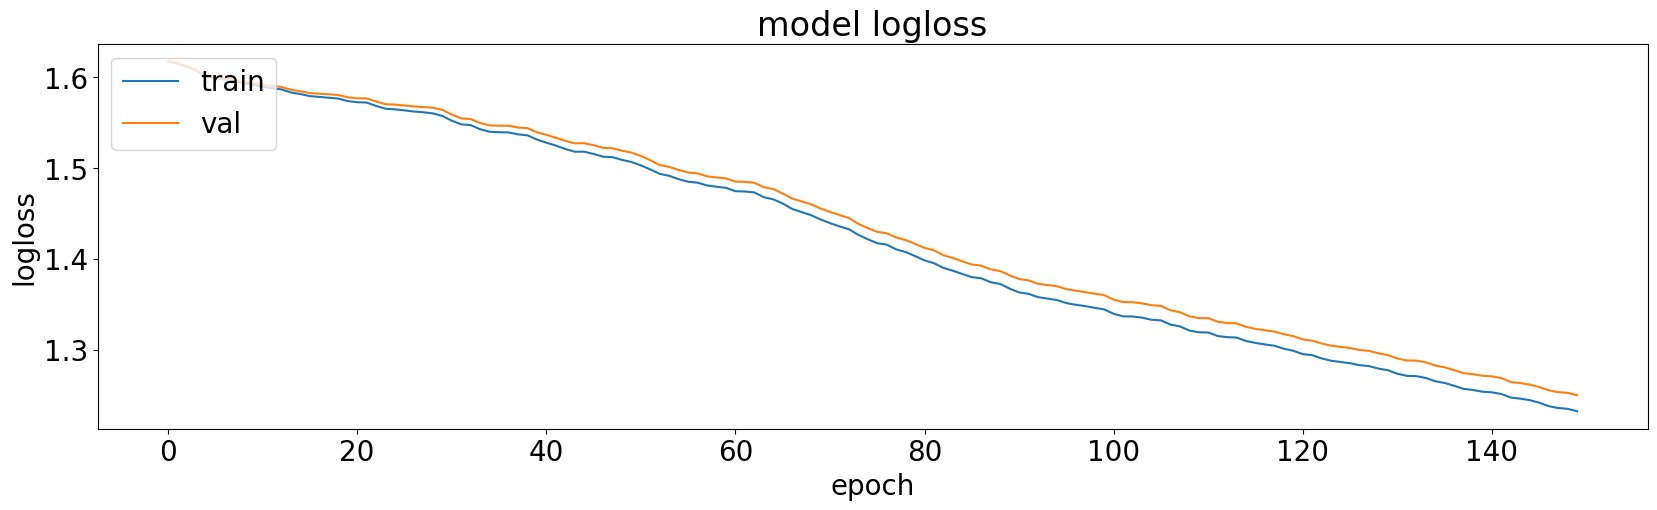

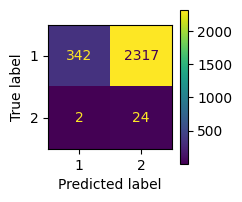

              precision    recall  f1-score   support

           1       0.99      0.13      0.23      2659
           2       0.01      0.92      0.02        26

    accuracy                           0.14      2685
   macro avg       0.50      0.53      0.12      2685
weighted avg       0.98      0.14      0.23      2685

| 5         | 0.1206    | 0.8888    | 0.2684    | 0.009419  | 3.469     | 2.528     | 0.8903    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:14:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


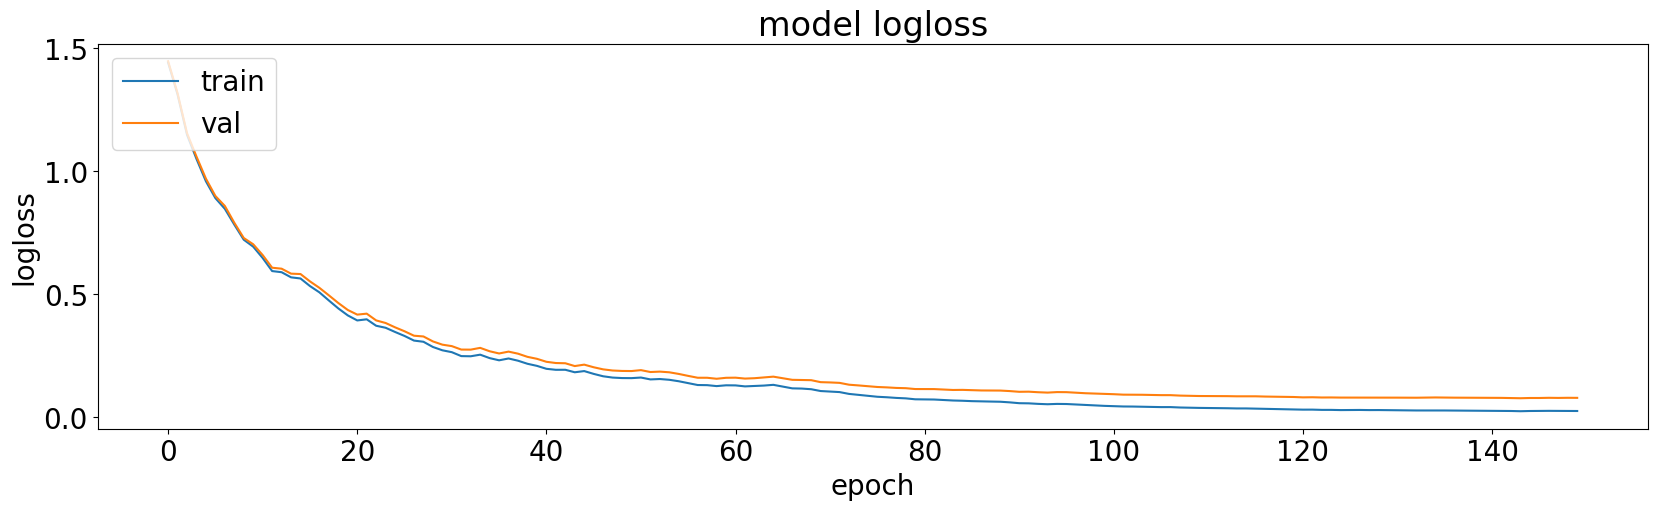

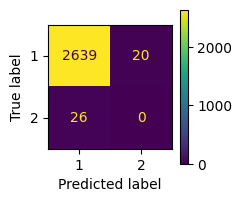

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.98      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.98      0.98      2685

| 6         | 0.4956    | 0.1885    | 0.1263    | 0.09583   | 9.398     | 7.227     | 0.384     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


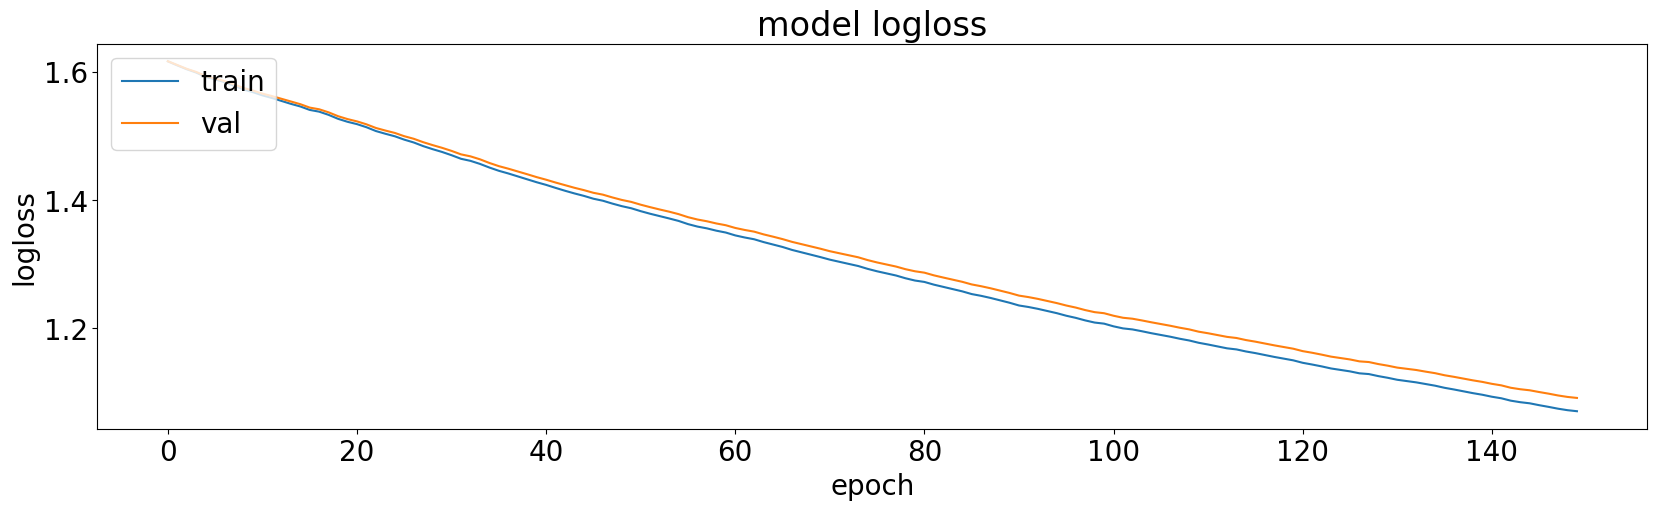

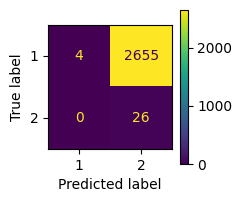

              precision    recall  f1-score   support

           1       1.00      0.00      0.00      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.01      2685
   macro avg       0.50      0.50      0.01      2685
weighted avg       0.99      0.01      0.00      2685

| 7         | 0.01044   | 0.7179    | 0.2504    | 0.002811  | 12.0      | 9.9       | 0.7733    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


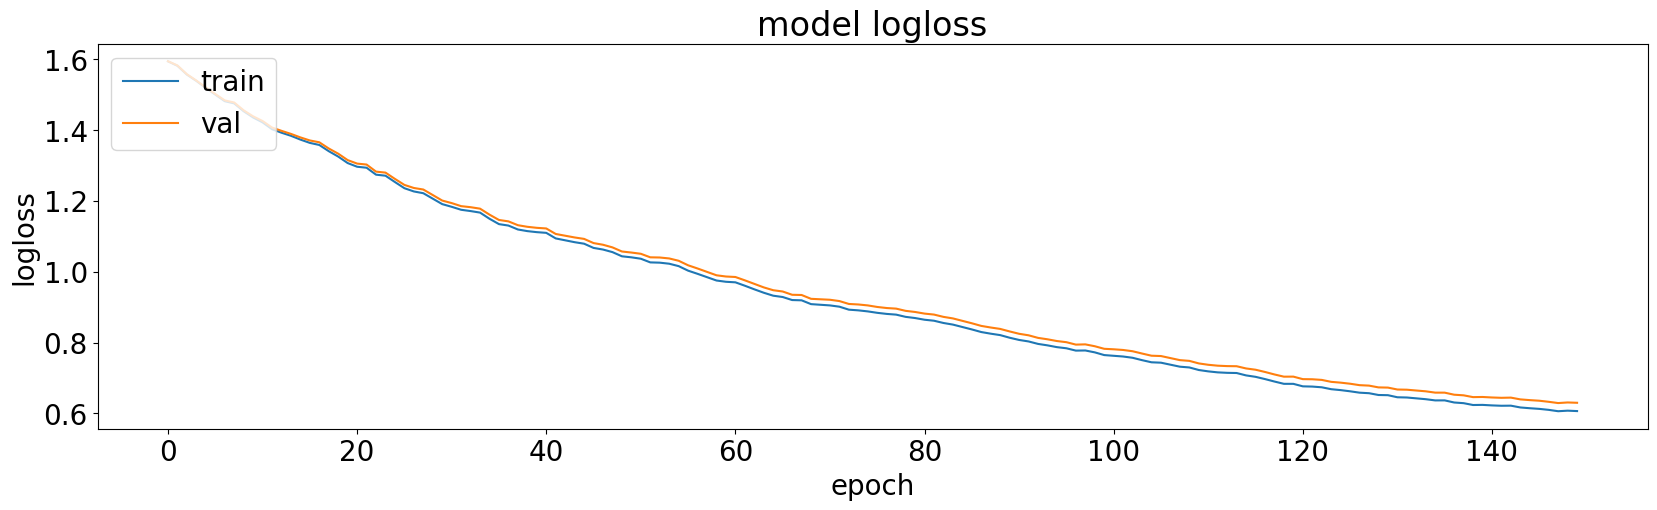

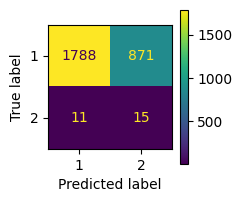

              precision    recall  f1-score   support

           1       0.99      0.67      0.80      2659
           2       0.02      0.58      0.03        26

    accuracy                           0.67      2685
   macro avg       0.51      0.62      0.42      2685
weighted avg       0.98      0.67      0.79      2685

| 8         | 0.4084    | 0.3524    | 0.2368    | 0.01122   | 8.375     | 9.177     | 0.3643    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


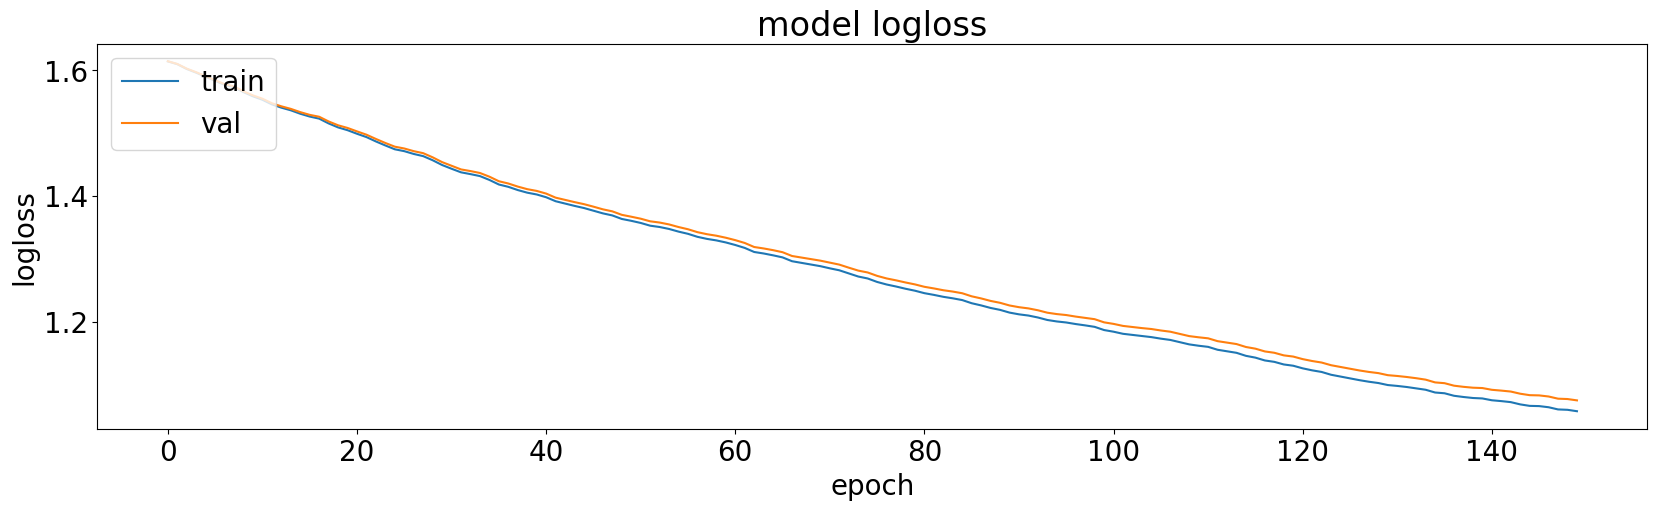

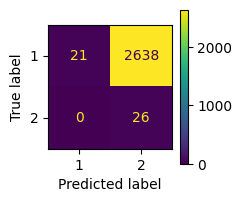

              precision    recall  f1-score   support

           1       1.00      0.01      0.02      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.02      2685
   macro avg       0.50      0.50      0.02      2685
weighted avg       0.99      0.02      0.02      2685

| 9         | 0.01444   | 0.359     | 0.03901   | 0.002917  | 11.15     | 2.905     | 0.339     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


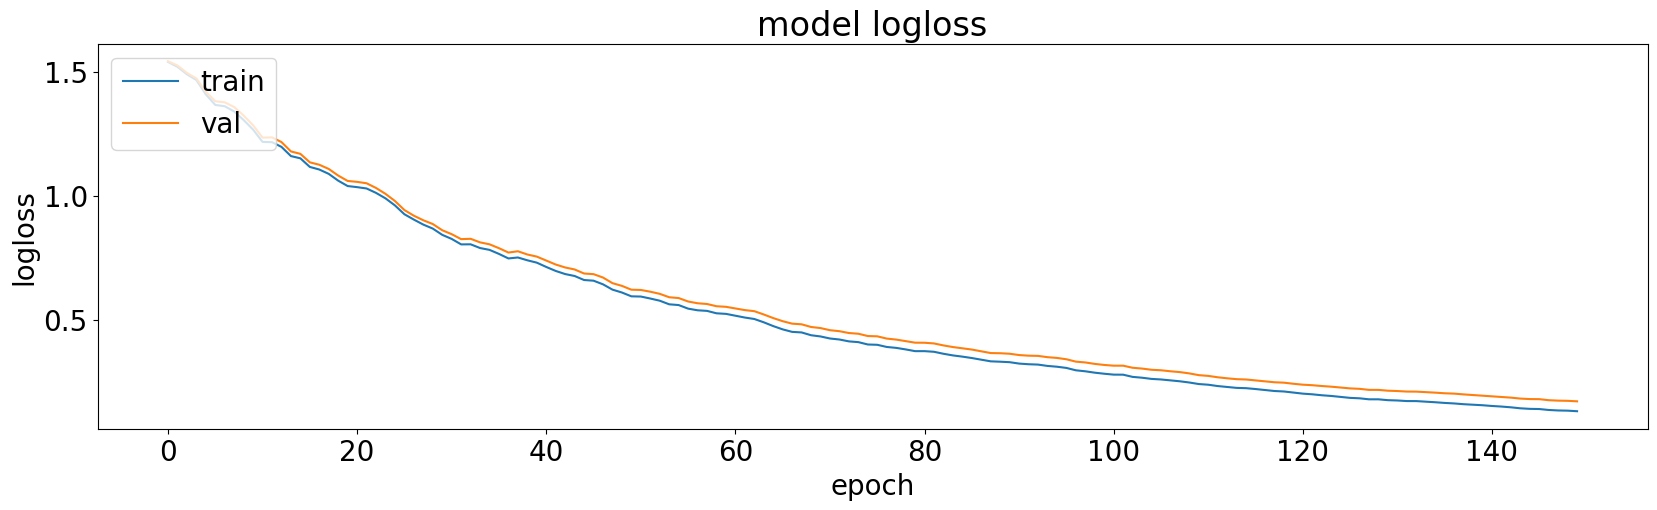

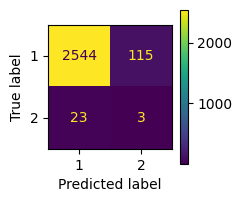

              precision    recall  f1-score   support

           1       0.99      0.96      0.97      2659
           2       0.03      0.12      0.04        26

    accuracy                           0.95      2685
   macro avg       0.51      0.54      0.51      2685
weighted avg       0.98      0.95      0.96      2685

| 10        | 0.5146    | 0.5424    | 0.01601   | 0.05784   | 4.761     | 6.304     | 0.7298    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


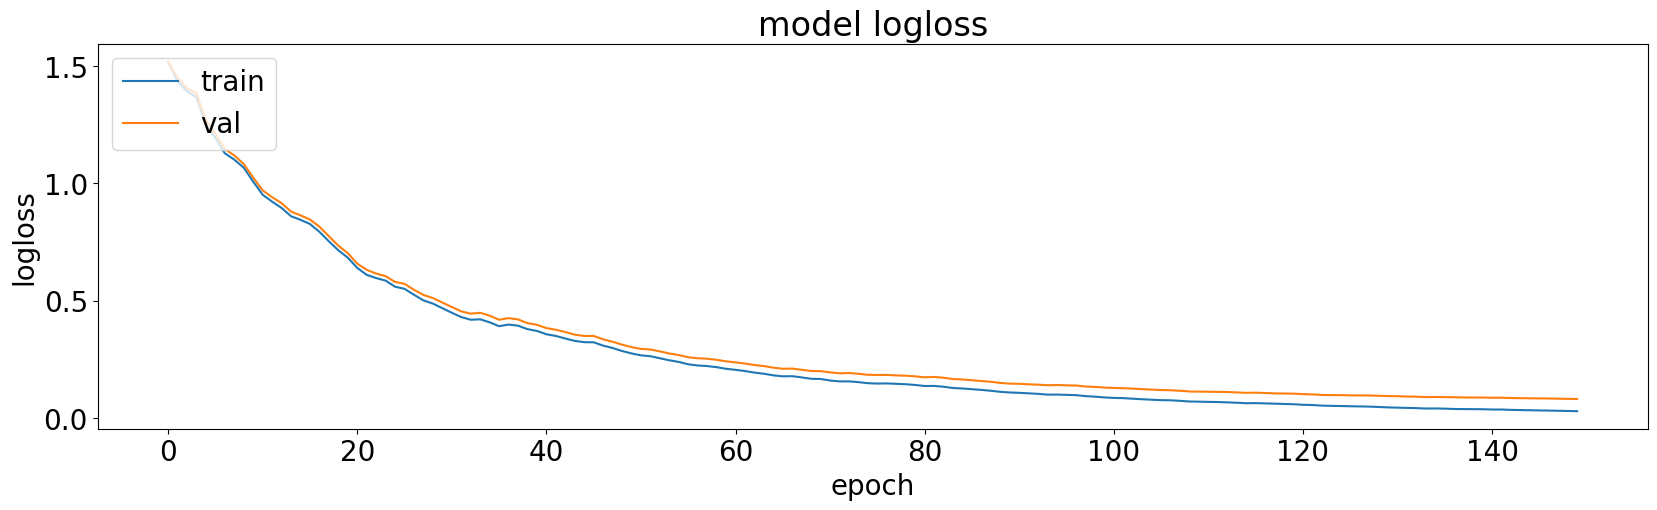

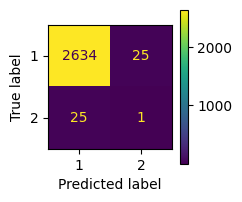

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.04      0.04      0.04        26

    accuracy                           0.98      2685
   macro avg       0.51      0.51      0.51      2685
weighted avg       0.98      0.98      0.98      2685

| 11        | 0.5137    | 0.1921    | 0.1242    | 0.06975   | 7.97      | 1.45      | 0.5823    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


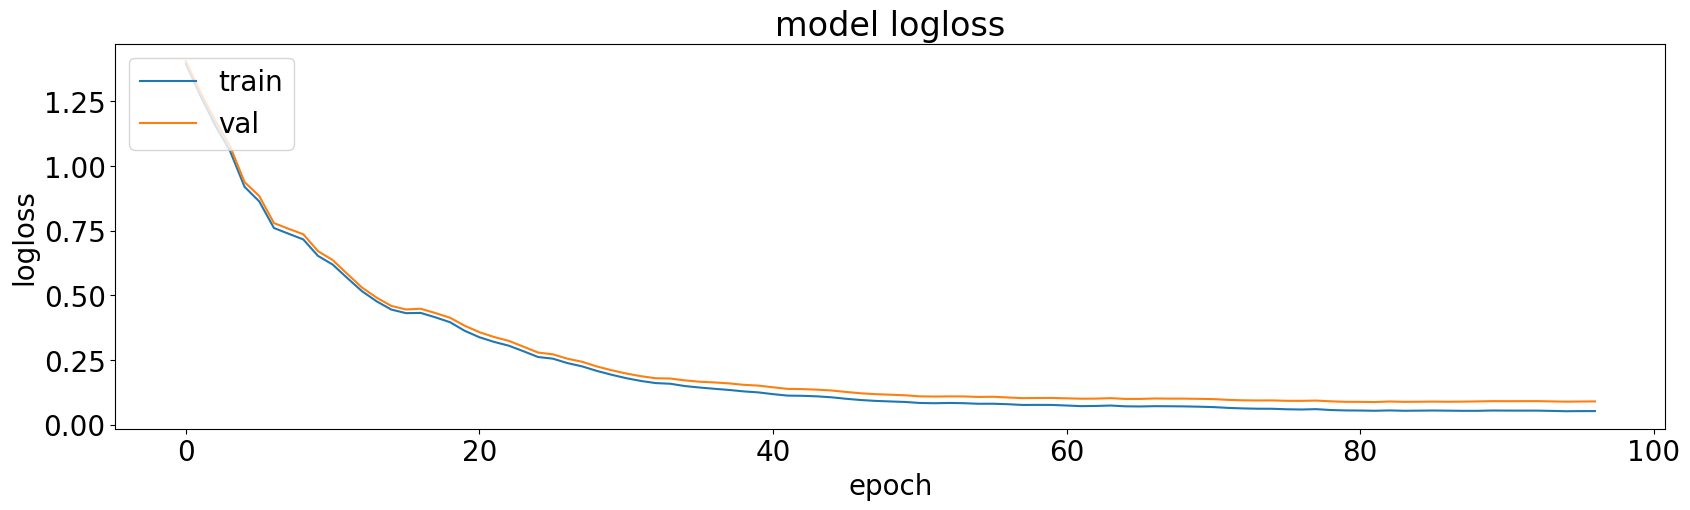

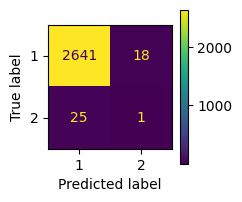

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.05      0.04      0.04        26

    accuracy                           0.98      2685
   macro avg       0.52      0.52      0.52      2685
weighted avg       0.98      0.98      0.98      2685

| 12        | 0.4954    | 0.6974    | 0.1545    | 0.09451   | 10.04     | 9.131     | 0.2237    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


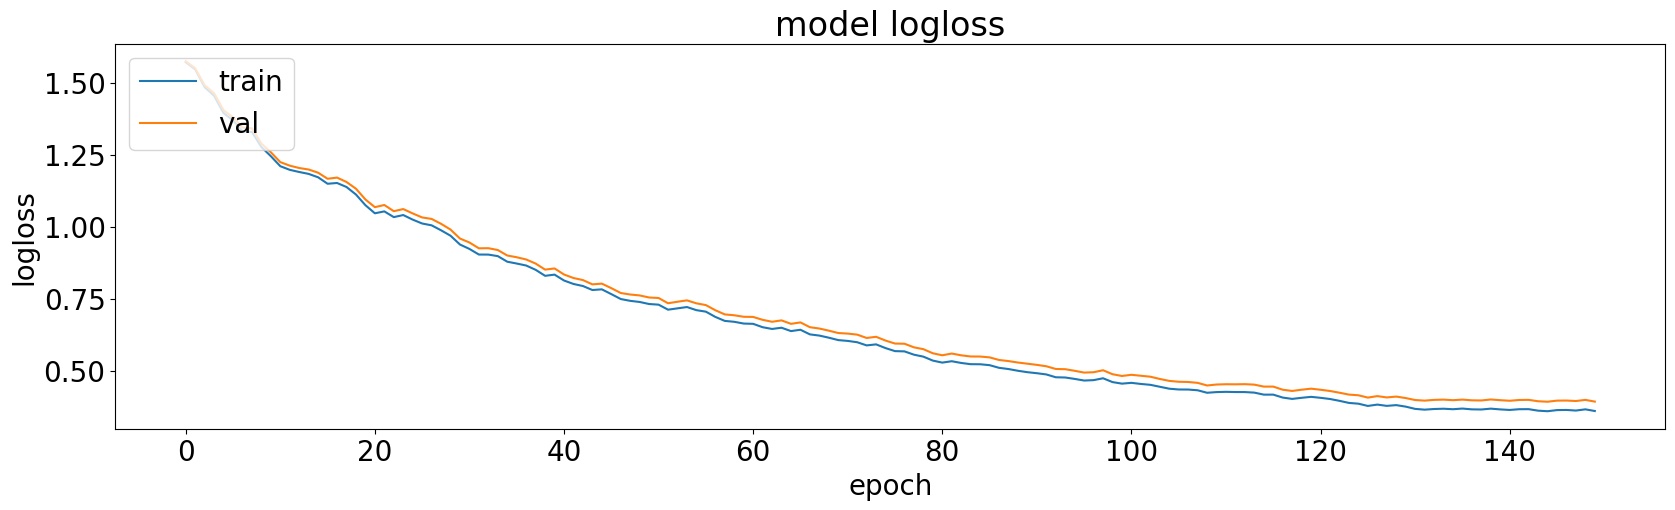

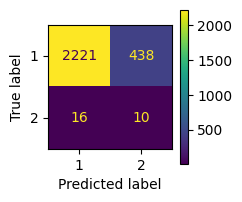

              precision    recall  f1-score   support

           1       0.99      0.84      0.91      2659
           2       0.02      0.38      0.04        26

    accuracy                           0.83      2685
   macro avg       0.51      0.61      0.47      2685
weighted avg       0.98      0.83      0.90      2685

| 13        | 0.4666    | 0.2253    | 0.2422    | 0.04037   | 4.984     | 9.348     | 0.413     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


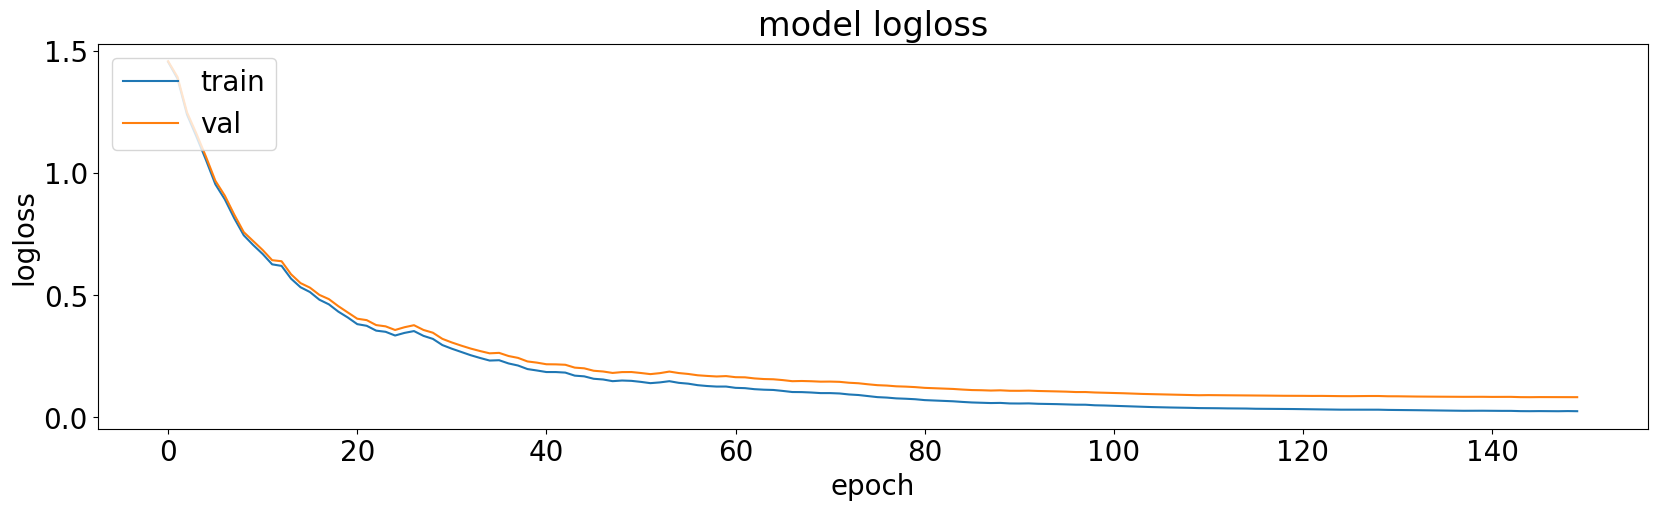

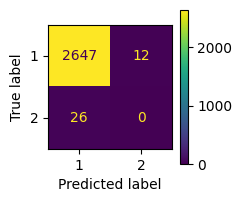

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 14        | 0.5175    | 0.7757    | 0.2178    | 0.08845   | 10.48     | 7.758     | 0.414     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


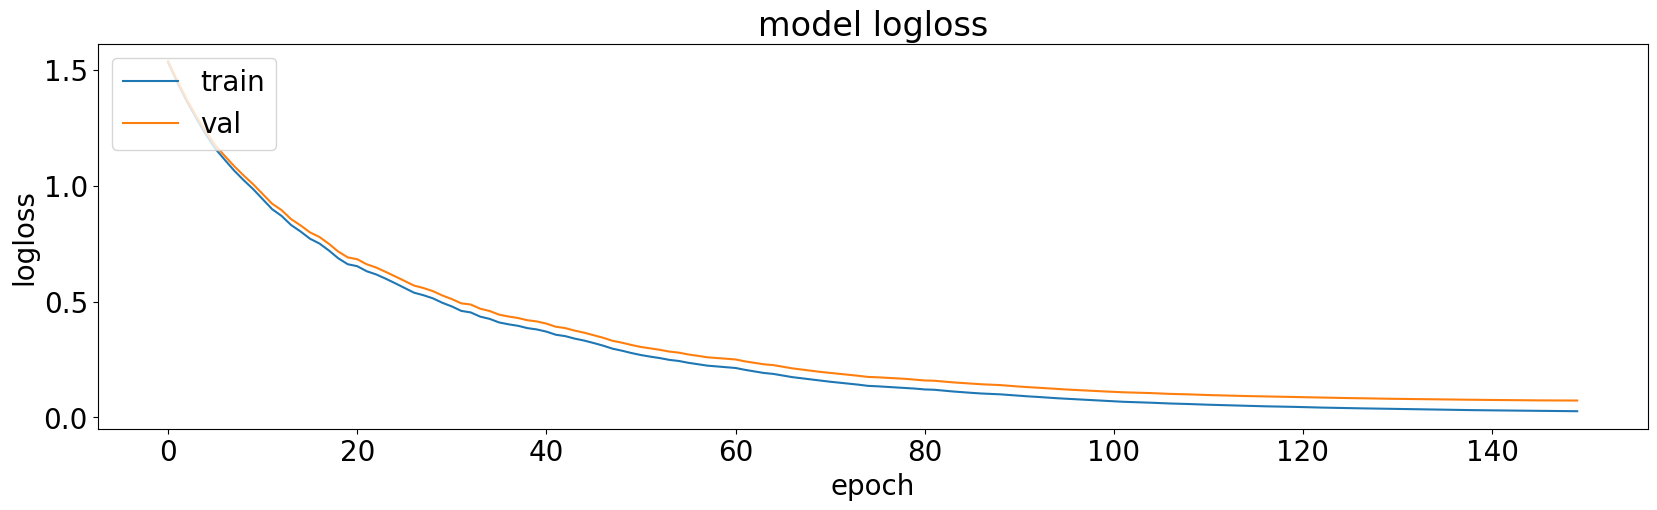

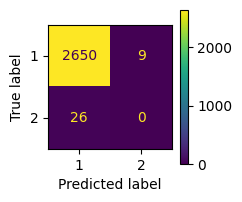

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 15        | 0.4964    | 0.3429    | 0.2688    | 0.04338   | 14.58     | 6.971     | 0.6595    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


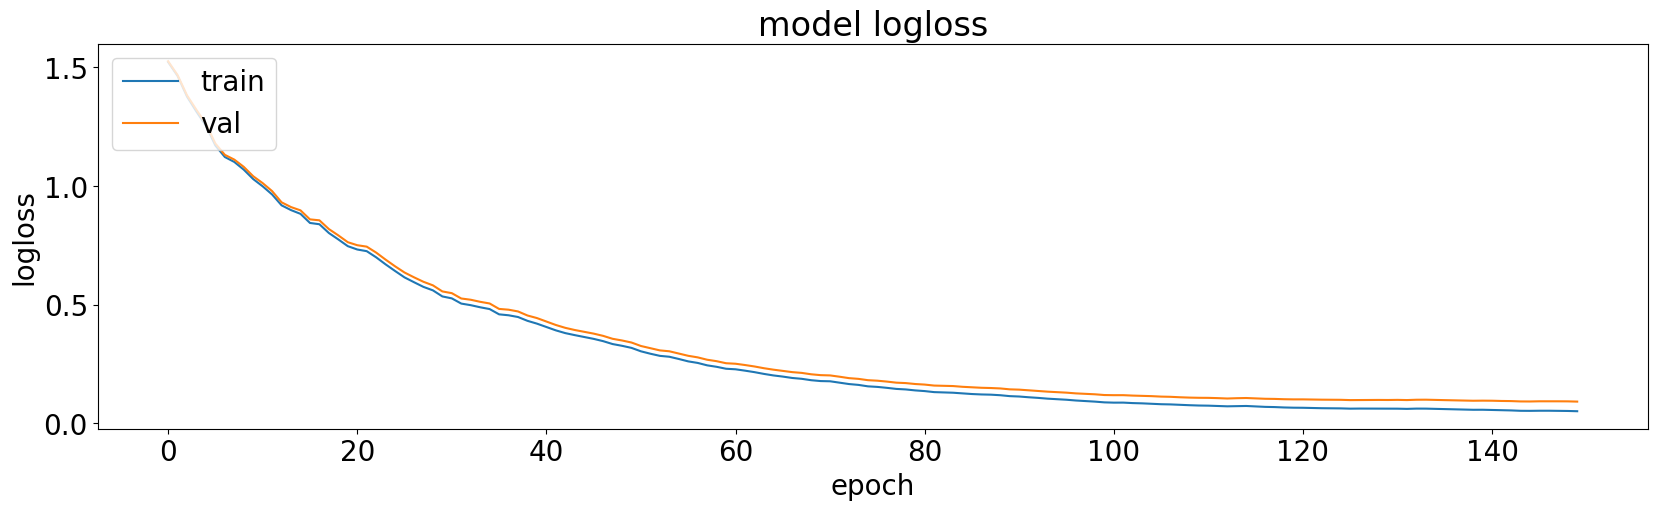

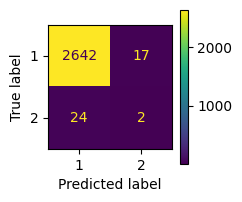

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.11      0.08      0.09        26

    accuracy                           0.98      2685
   macro avg       0.55      0.54      0.54      2685
weighted avg       0.98      0.98      0.98      2685

| 16        | 0.495     | 0.2033    | 0.2848    | 0.04554   | 9.941     | 4.673     | 0.3133    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:15:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


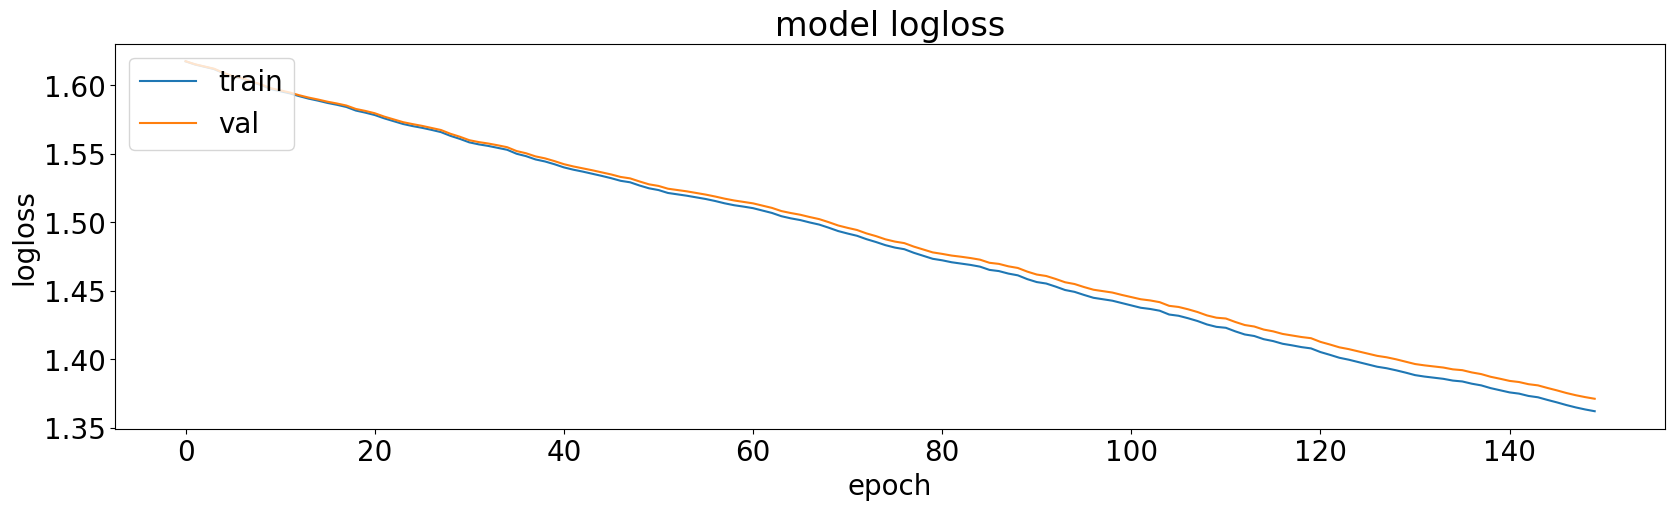

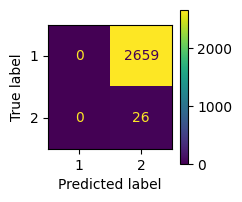

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.01      2685
   macro avg       0.00      0.50      0.01      2685
weighted avg       0.00      0.01      0.00      2685

| 17        | 0.009549  | 0.913     | 0.1721    | 0.001284  | 10.41     | 3.94      | 0.5744    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


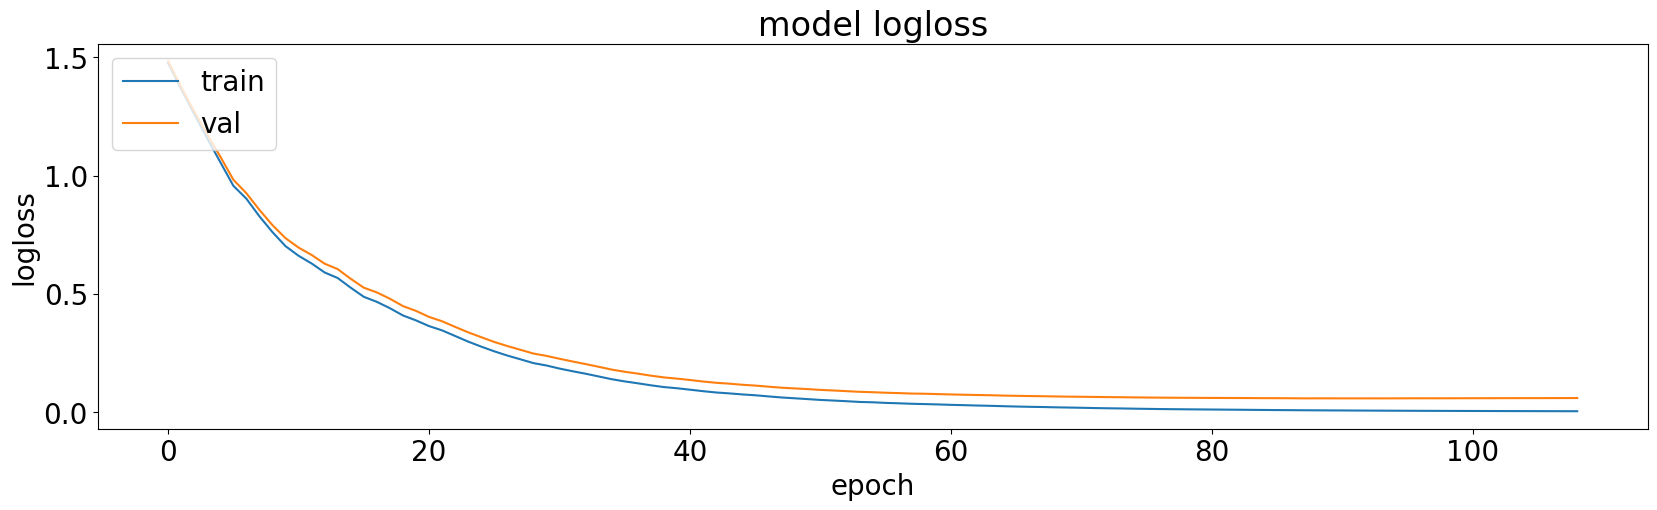

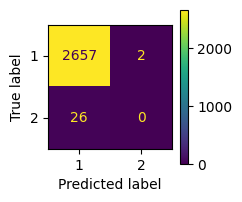

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.99      2685



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


| 18        | 0.4975    | 0.8973    | 0.1072    | 0.09094   | 10.48     | 1.142     | 0.9365    |


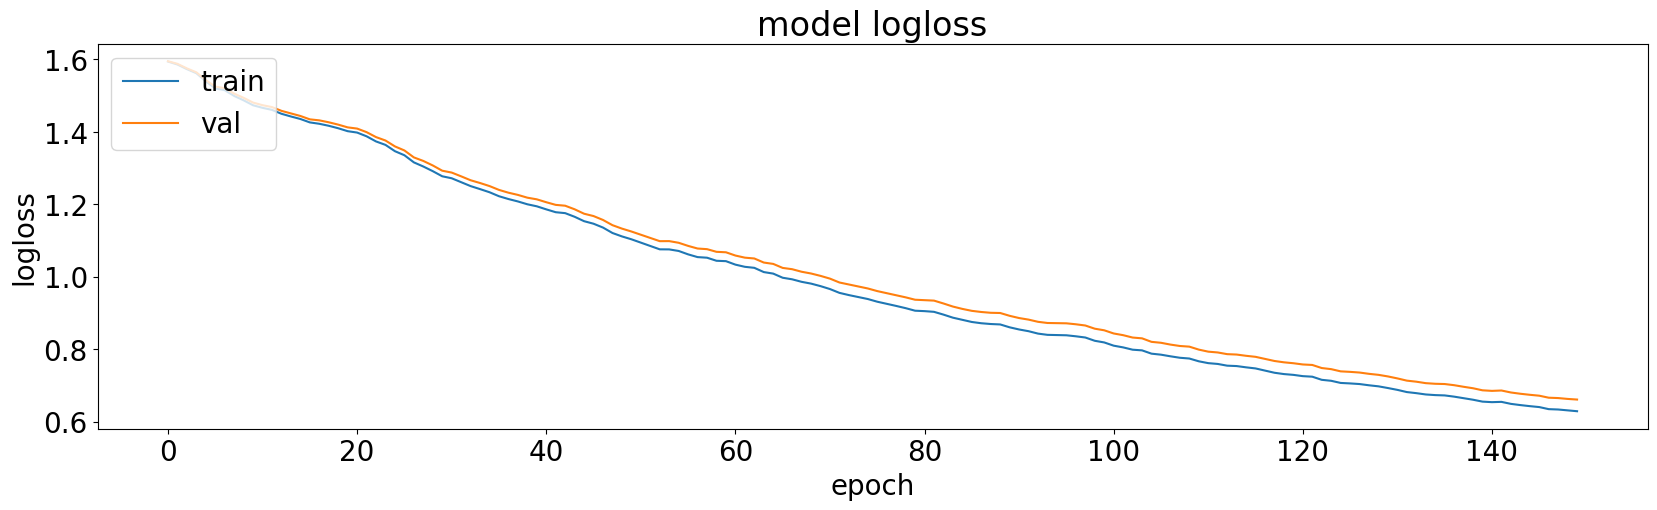

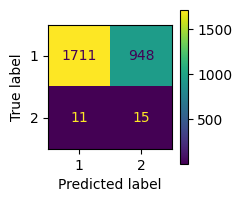

              precision    recall  f1-score   support

           1       0.99      0.64      0.78      2659
           2       0.02      0.58      0.03        26

    accuracy                           0.64      2685
   macro avg       0.50      0.61      0.41      2685
weighted avg       0.98      0.64      0.77      2685

| 19        | 0.4033    | 0.7218    | 0.2992    | 0.01806   | 4.646     | 9.393     | 0.7271    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


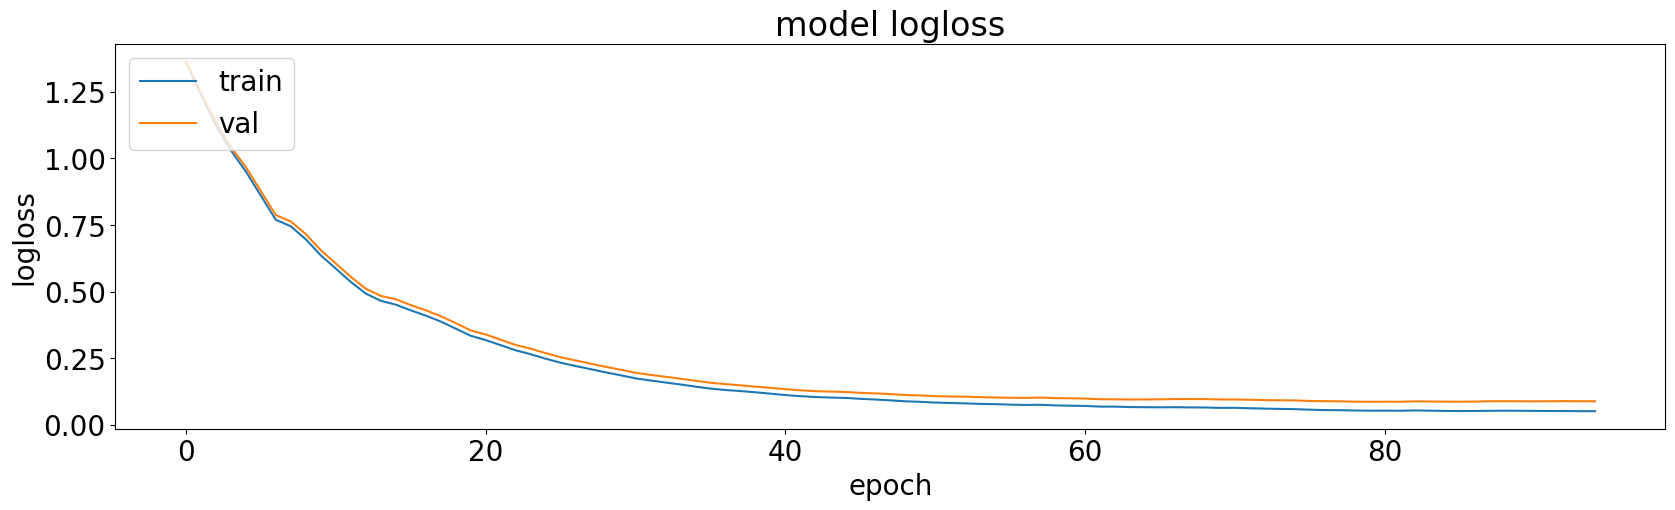

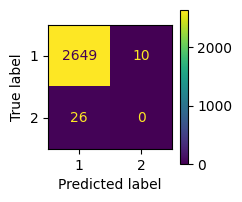

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 20        | 0.4965    | 0.1594    | 0.2266    | 0.07563   | 14.08     | 7.404     | 0.2118    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


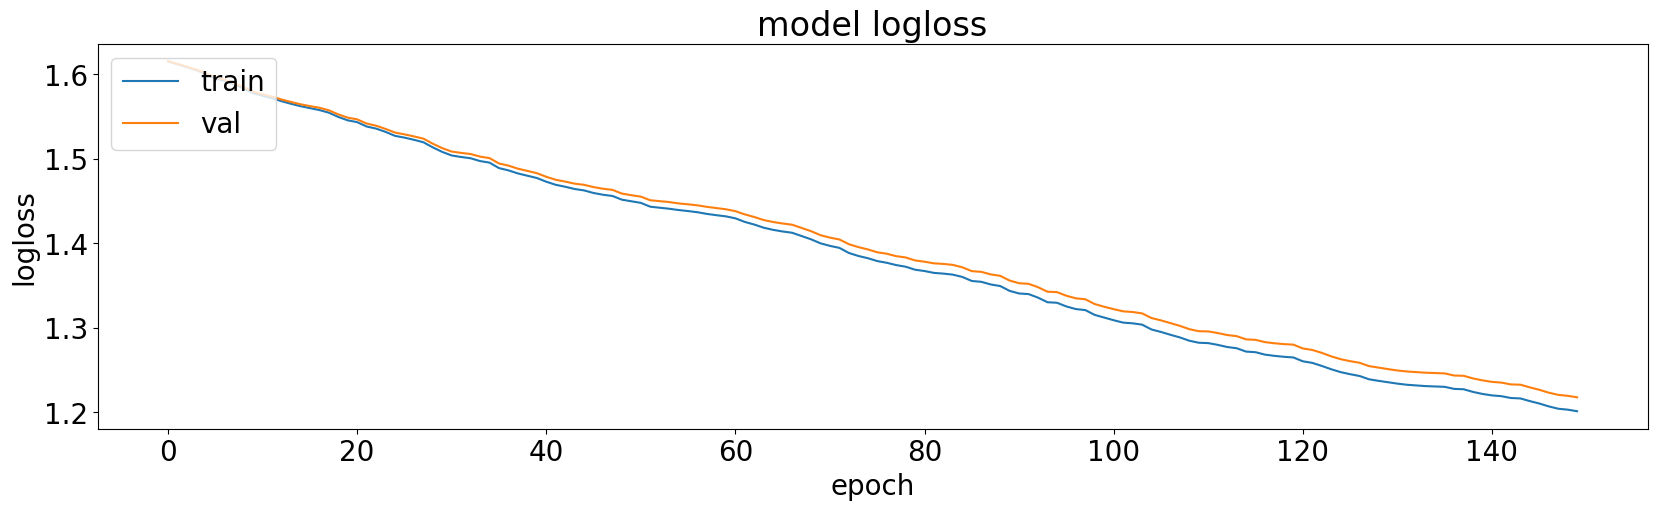

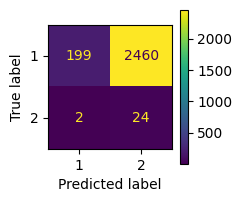

              precision    recall  f1-score   support

           1       0.99      0.07      0.14      2659
           2       0.01      0.92      0.02        26

    accuracy                           0.08      2685
   macro avg       0.50      0.50      0.08      2685
weighted avg       0.98      0.08      0.14      2685

| 21        | 0.07363   | 0.1179    | 0.007863  | 0.003802  | 5.955     | 8.74      | 0.5849    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


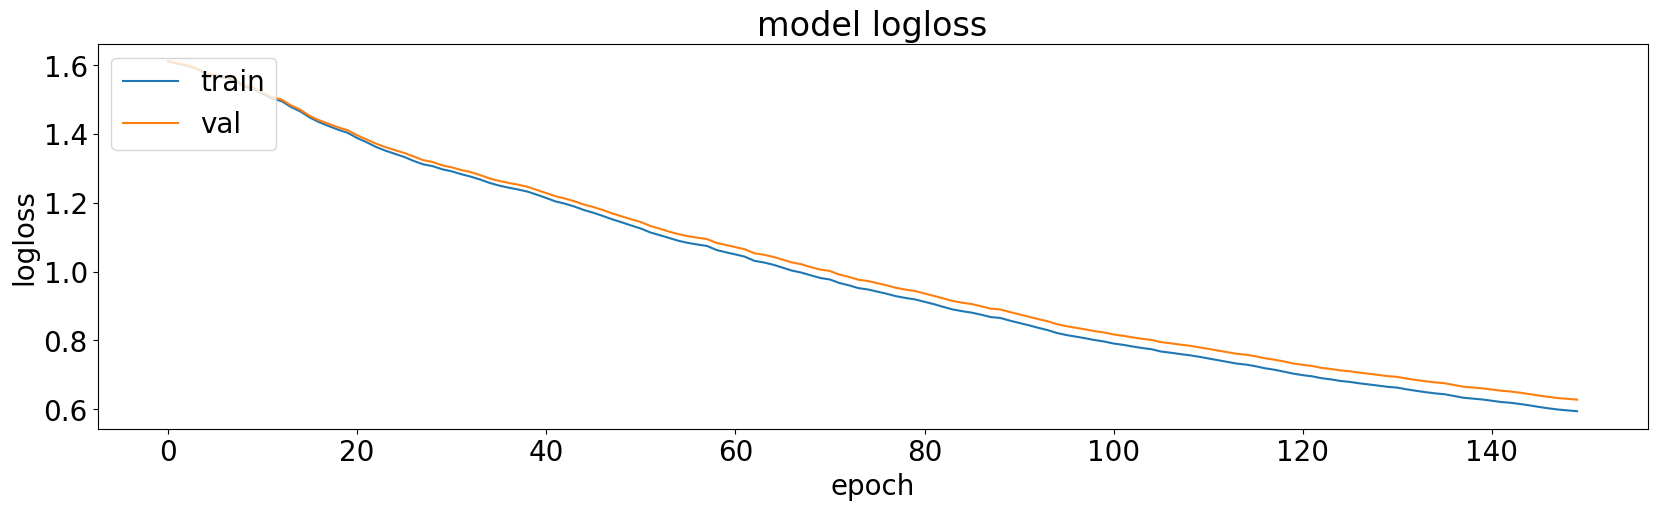

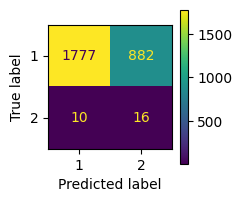

              precision    recall  f1-score   support

           1       0.99      0.67      0.80      2659
           2       0.02      0.62      0.03        26

    accuracy                           0.67      2685
   macro avg       0.51      0.64      0.42      2685
weighted avg       0.98      0.67      0.79      2685

| 22        | 0.4124    | 0.5975    | 0.2526    | 0.01329   | 6.35      | 6.272     | 0.9726    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


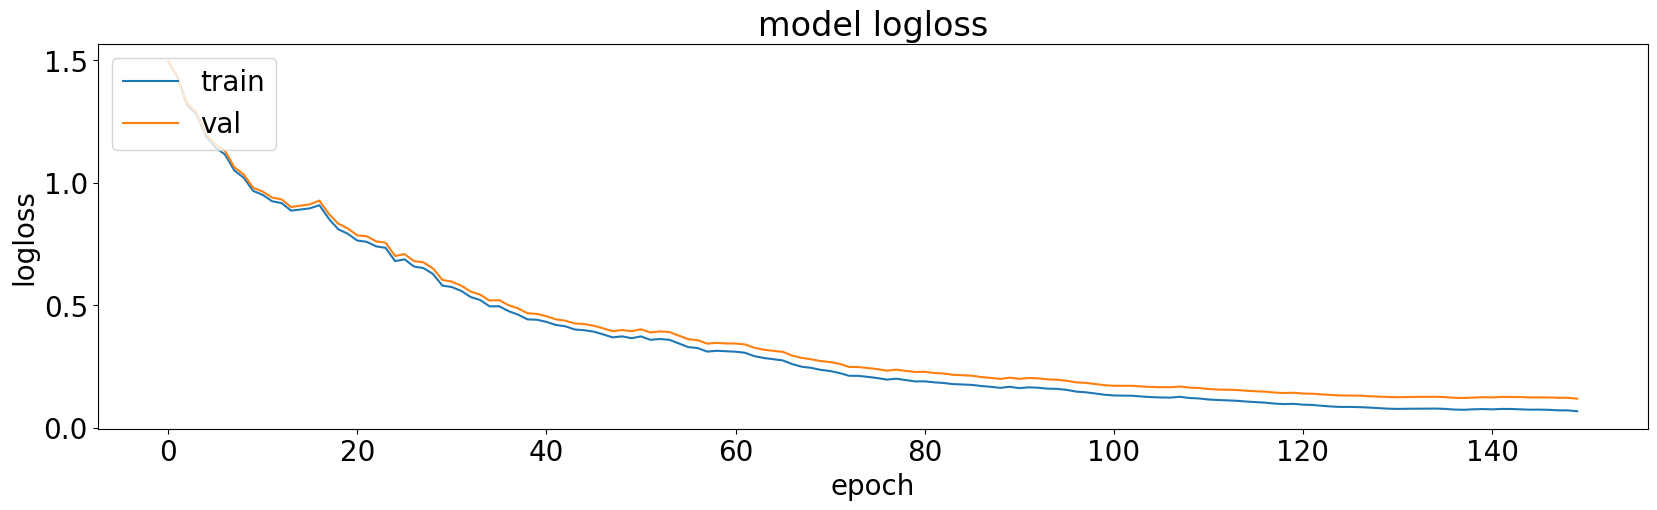

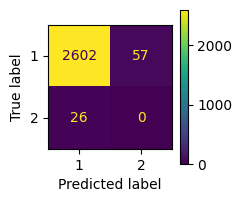

              precision    recall  f1-score   support

           1       0.99      0.98      0.98      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.97      2685
   macro avg       0.50      0.49      0.49      2685
weighted avg       0.98      0.97      0.97      2685

| 23        | 0.5025    | 0.6049    | 0.005594  | 0.08026   | 5.796     | 8.264     | 0.4491    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


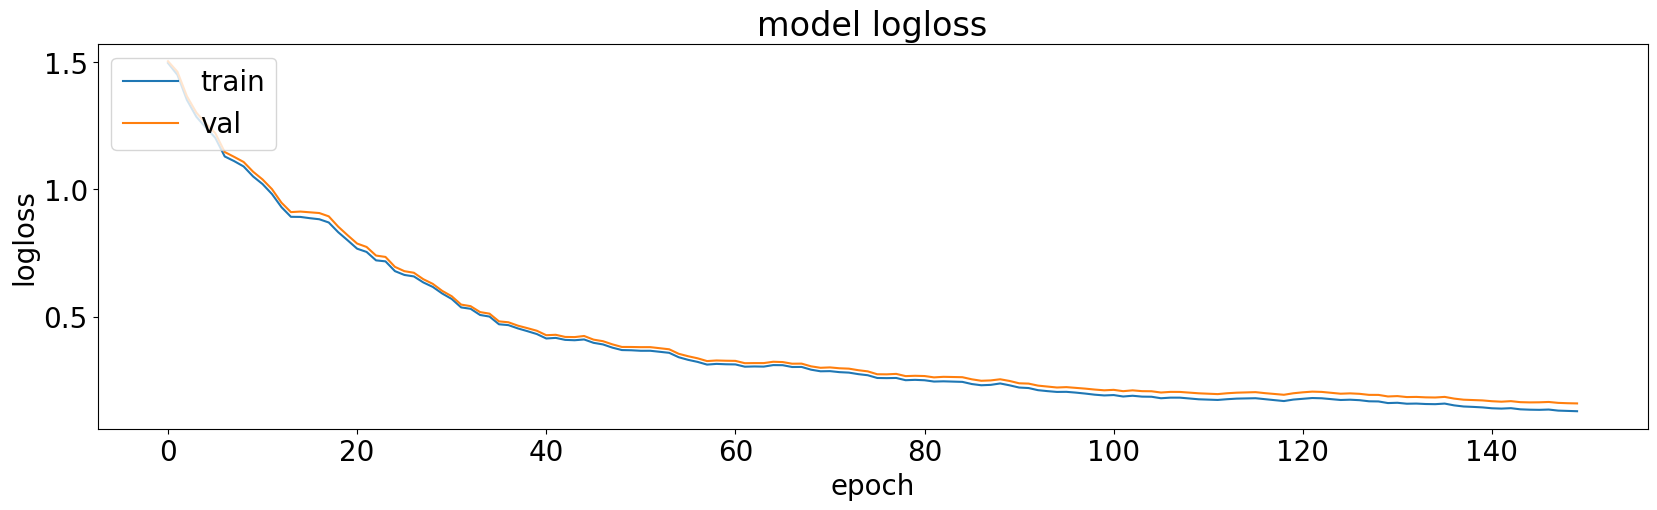

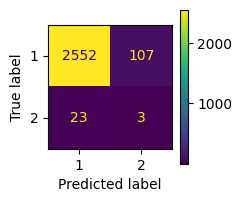

              precision    recall  f1-score   support

           1       0.99      0.96      0.98      2659
           2       0.03      0.12      0.04        26

    accuracy                           0.95      2685
   macro avg       0.51      0.54      0.51      2685
weighted avg       0.98      0.95      0.97      2685

| 24        | 0.516     | 0.8772    | 0.2241    | 0.05607   | 4.637     | 1.539     | 0.2092    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


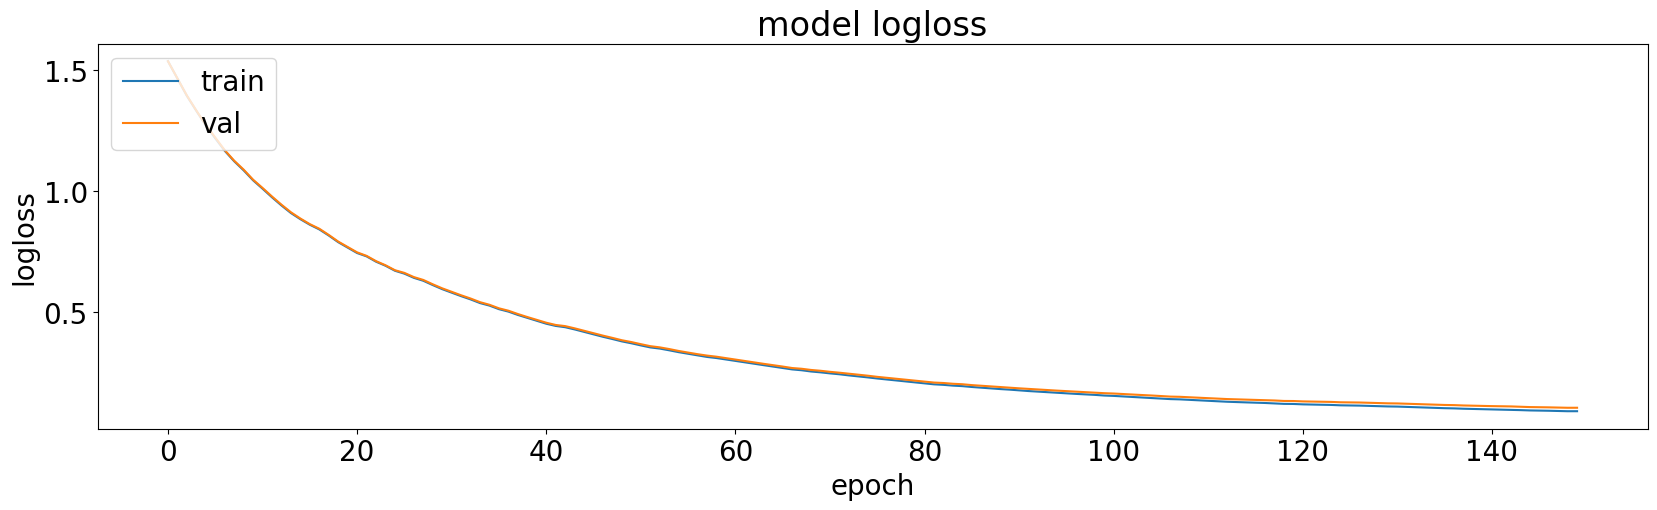

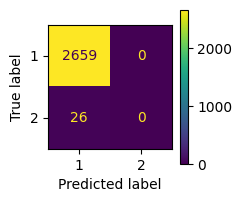

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.99      1.00      1.00      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.99      2685

| 25        | 0.4976    | 0.1401    | 0.03225   | 0.02335   | 11.56     | 6.037     | 0.1113    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


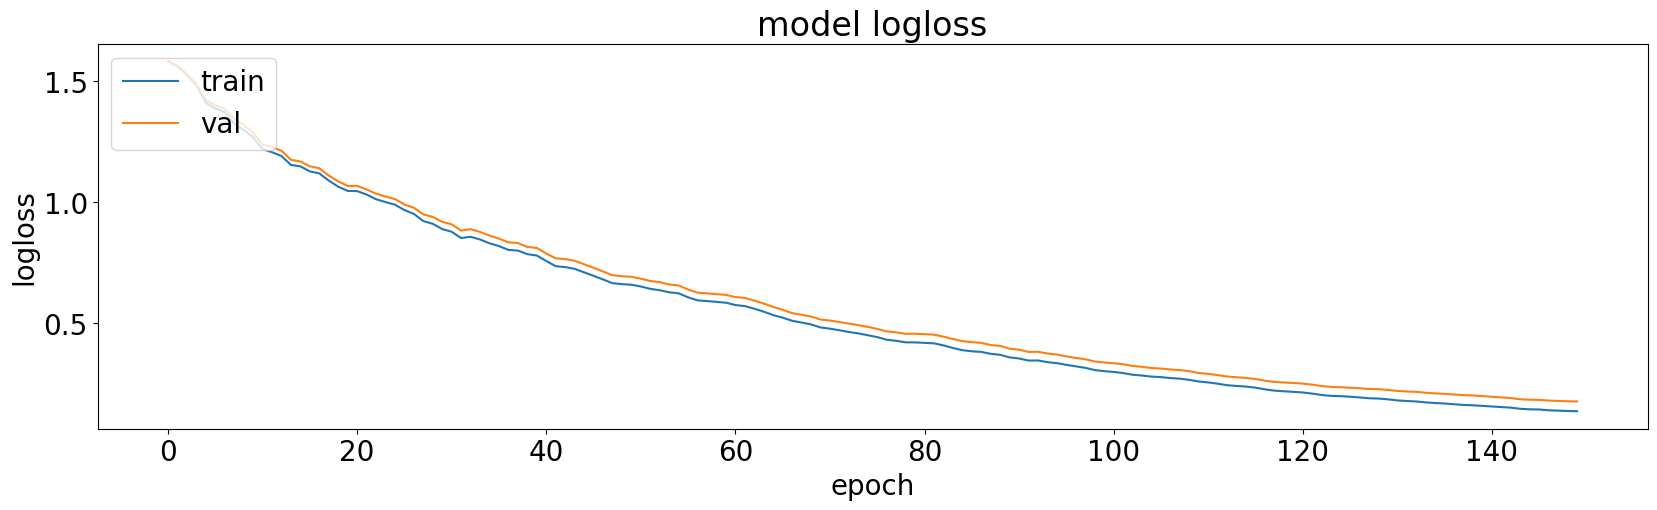

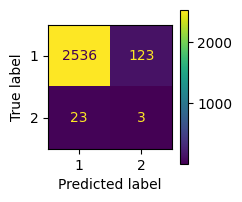

              precision    recall  f1-score   support

           1       0.99      0.95      0.97      2659
           2       0.02      0.12      0.04        26

    accuracy                           0.95      2685
   macro avg       0.51      0.53      0.51      2685
weighted avg       0.98      0.95      0.96      2685

| 26        | 0.5292    | 0.1648    | 0.2902    | 0.05724   | 5.44      | 3.271     | 0.7694    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:16:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


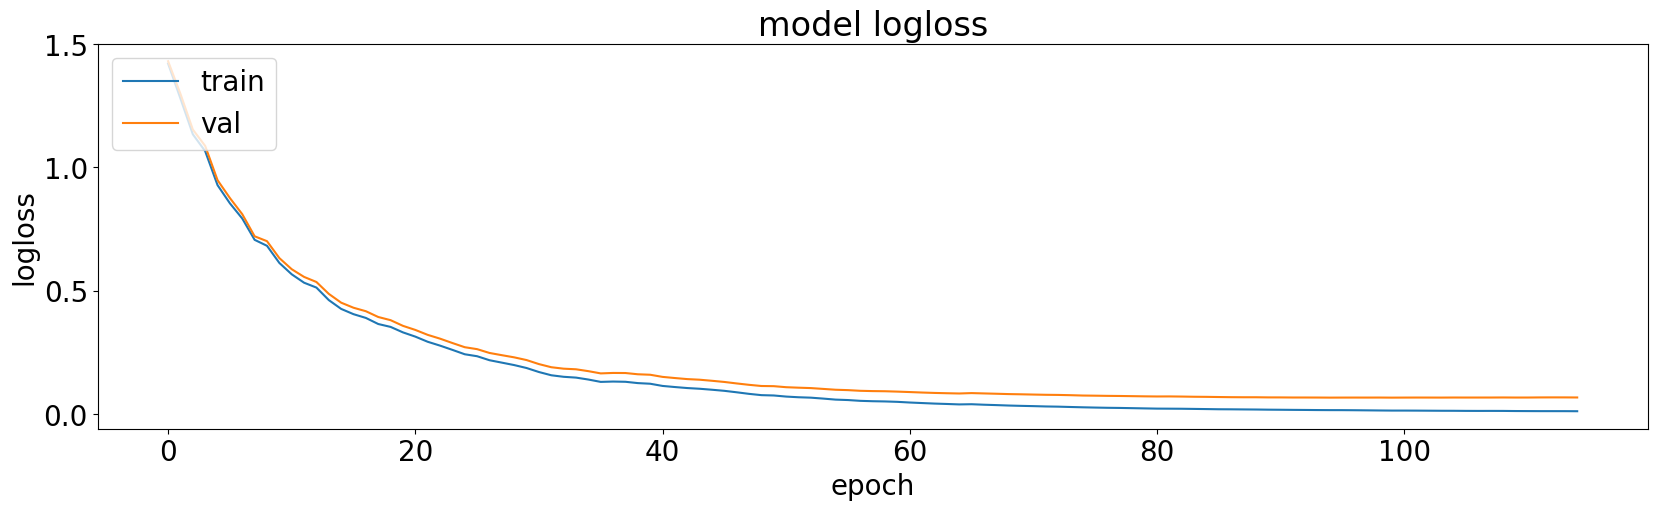

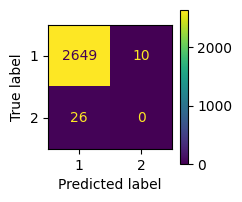

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 27        | 0.4967    | 0.2759    | 0.1744    | 0.09703   | 13.16     | 3.159     | 0.5444    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


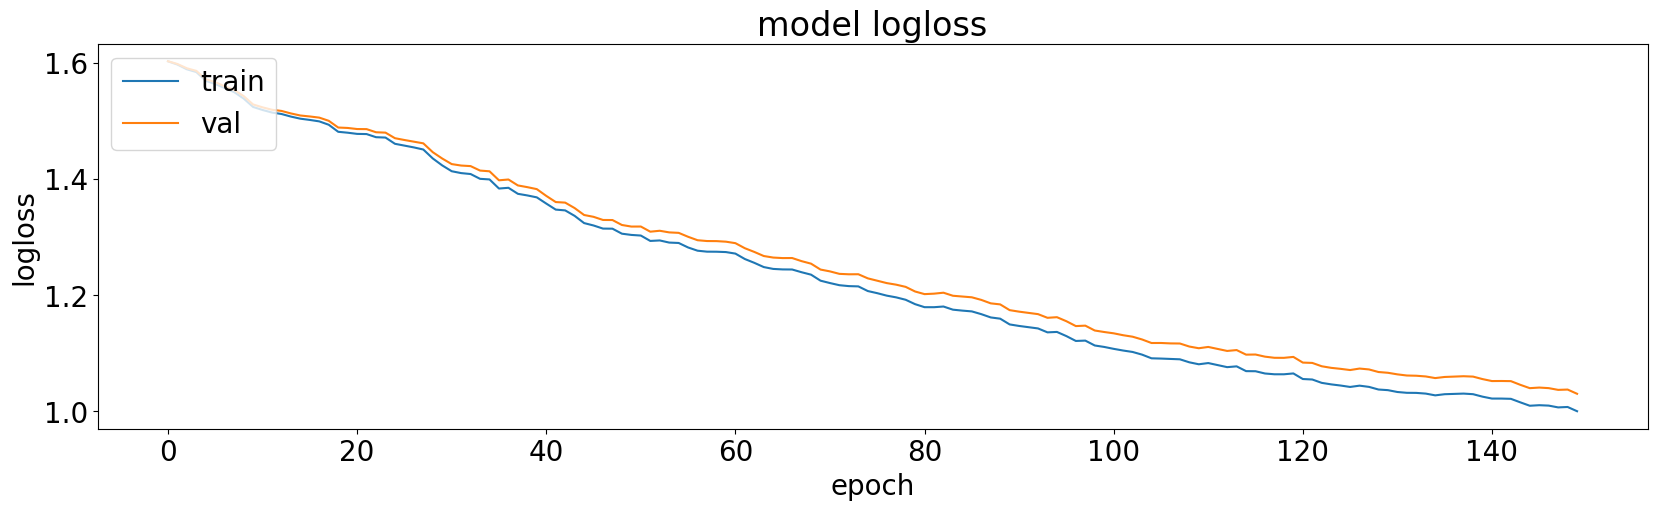

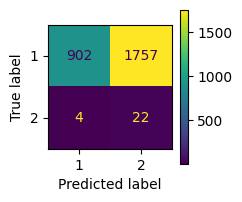

              precision    recall  f1-score   support

           1       1.00      0.34      0.51      2659
           2       0.01      0.85      0.02        26

    accuracy                           0.34      2685
   macro avg       0.50      0.59      0.27      2685
weighted avg       0.99      0.34      0.50      2685

| 28        | 0.2655    | 0.658     | 0.2487    | 0.01652   | 3.223     | 1.63      | 0.5377    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


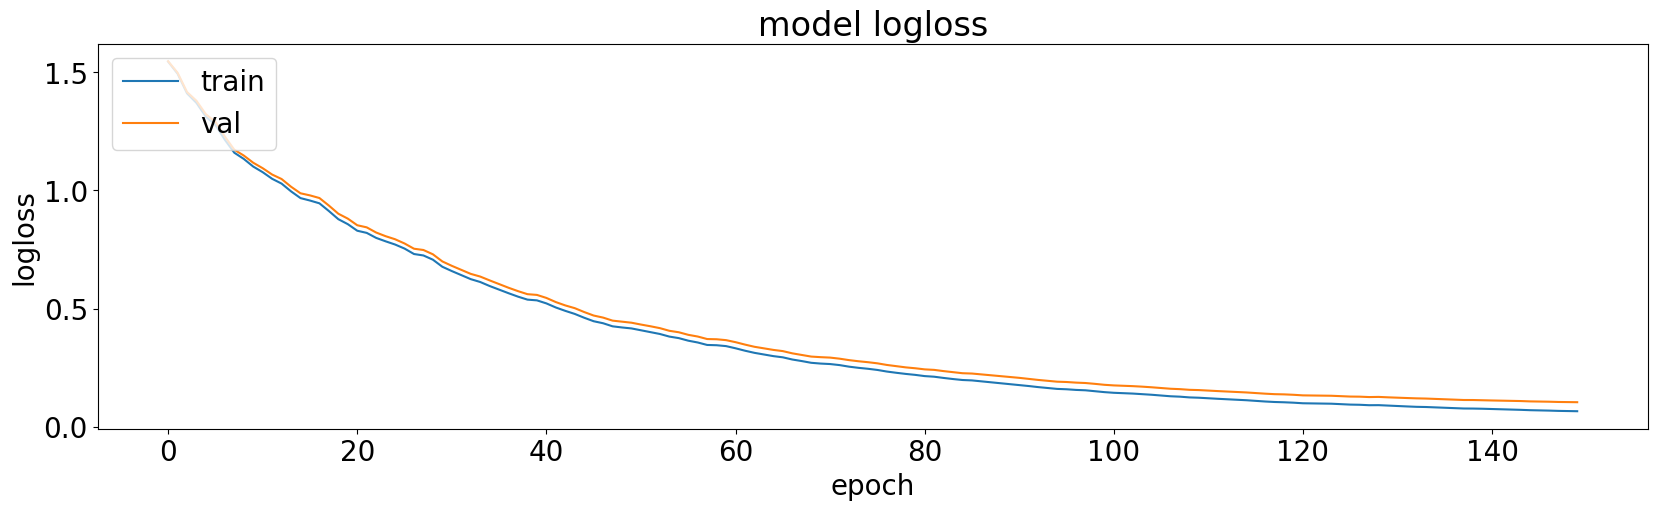

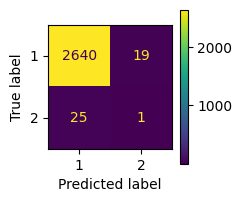

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.05      0.04      0.04        26

    accuracy                           0.98      2685
   macro avg       0.52      0.52      0.52      2685
weighted avg       0.98      0.98      0.98      2685

| 29        | 0.4938    | 0.6457    | 0.1707    | 0.03242   | 14.86     | 6.218     | 0.4421    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


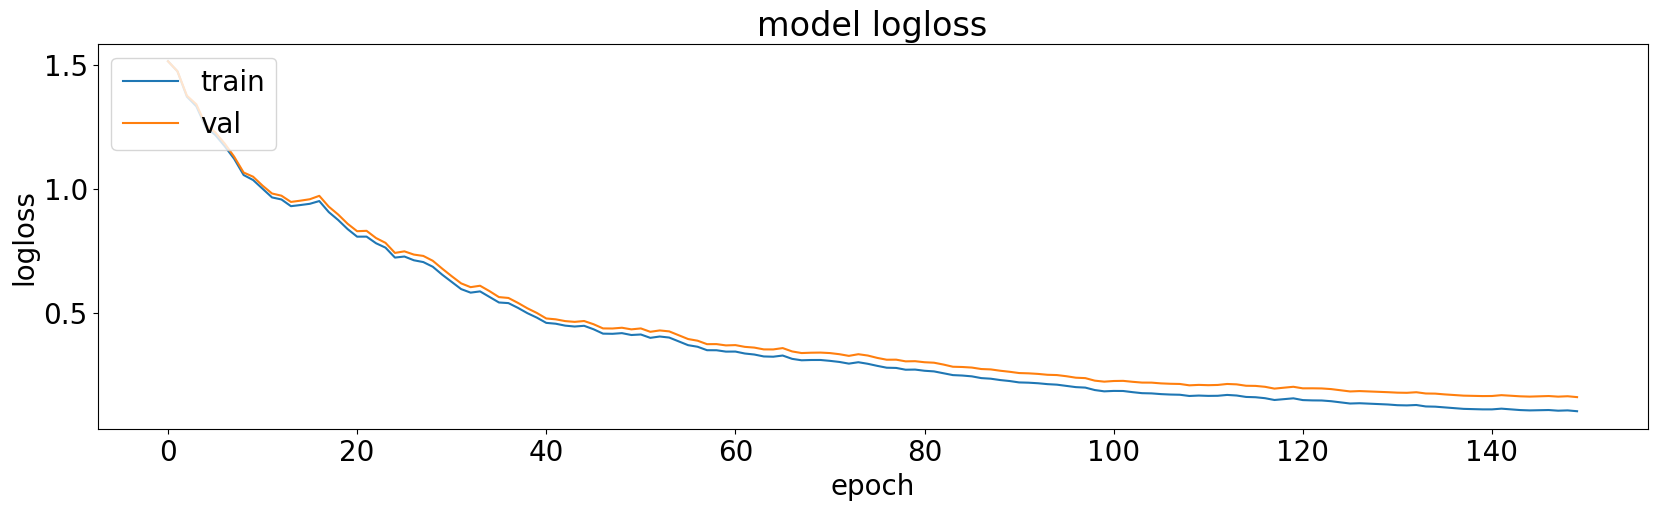

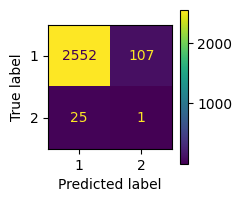

              precision    recall  f1-score   support

           1       0.99      0.96      0.97      2659
           2       0.01      0.04      0.01        26

    accuracy                           0.95      2685
   macro avg       0.50      0.50      0.49      2685
weighted avg       0.98      0.95      0.97      2685

| 30        | 0.5021    | 0.5959    | 0.2236    | 0.06725   | 6.179     | 1.597     | 0.4331    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


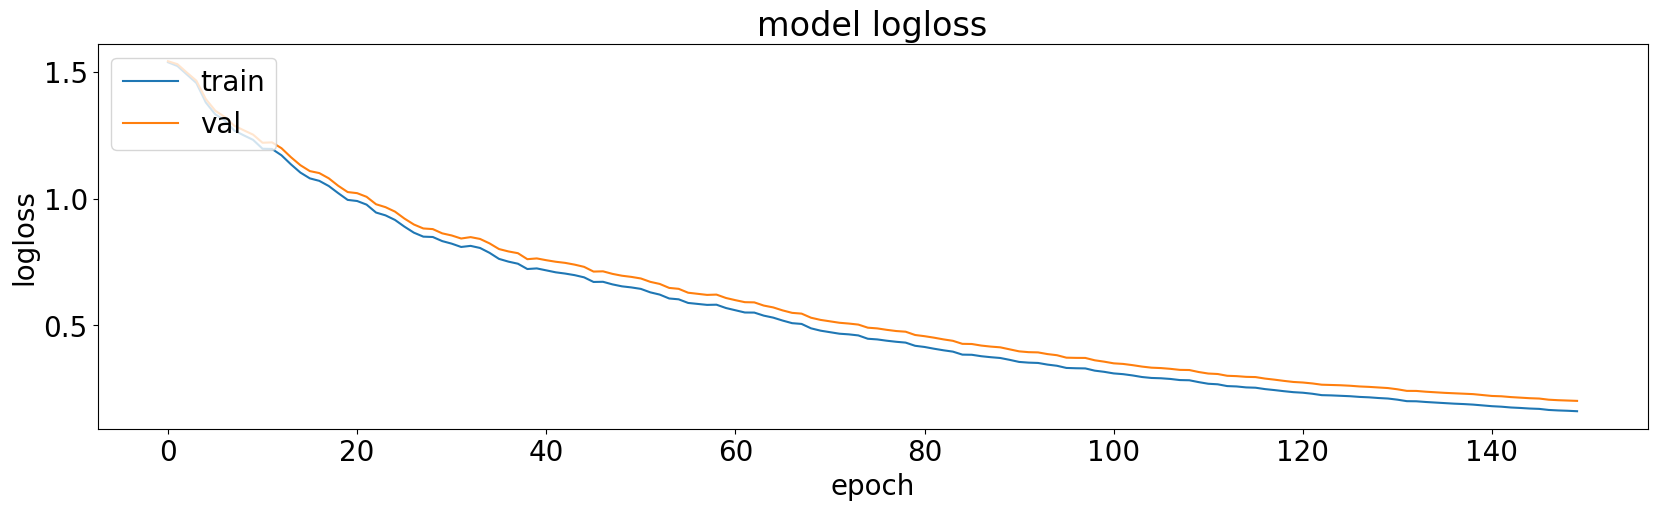

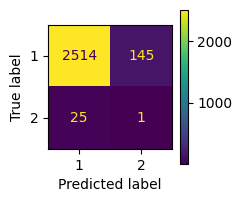

              precision    recall  f1-score   support

           1       0.99      0.95      0.97      2659
           2       0.01      0.04      0.01        26

    accuracy                           0.94      2685
   macro avg       0.50      0.49      0.49      2685
weighted avg       0.98      0.94      0.96      2685

| 31        | 0.5174    | 0.6667    | 0.06305   | 0.07552   | 3.798     | 3.343     | 0.8243    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


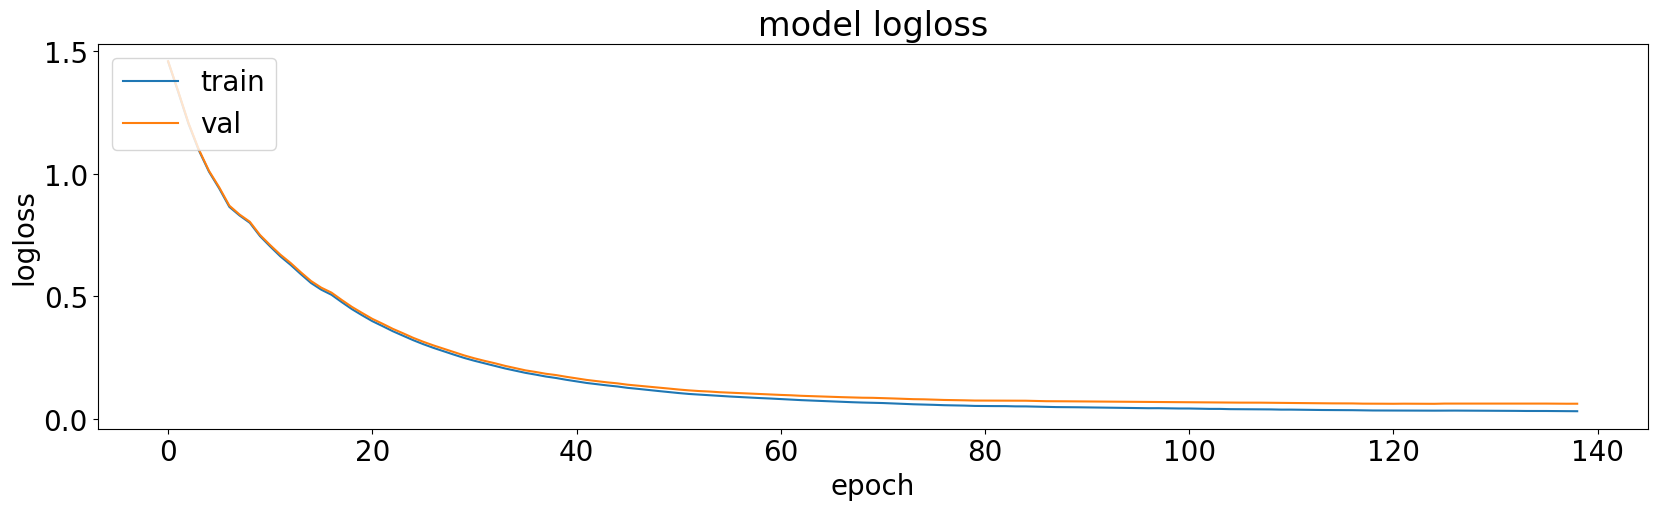

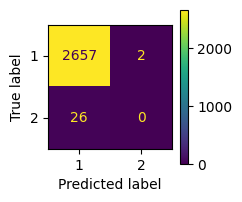

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.99      2685

| 32        | 0.4974    | 0.2741    | 0.1918    | 0.05294   | 14.1      | 3.37      | 0.1594    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


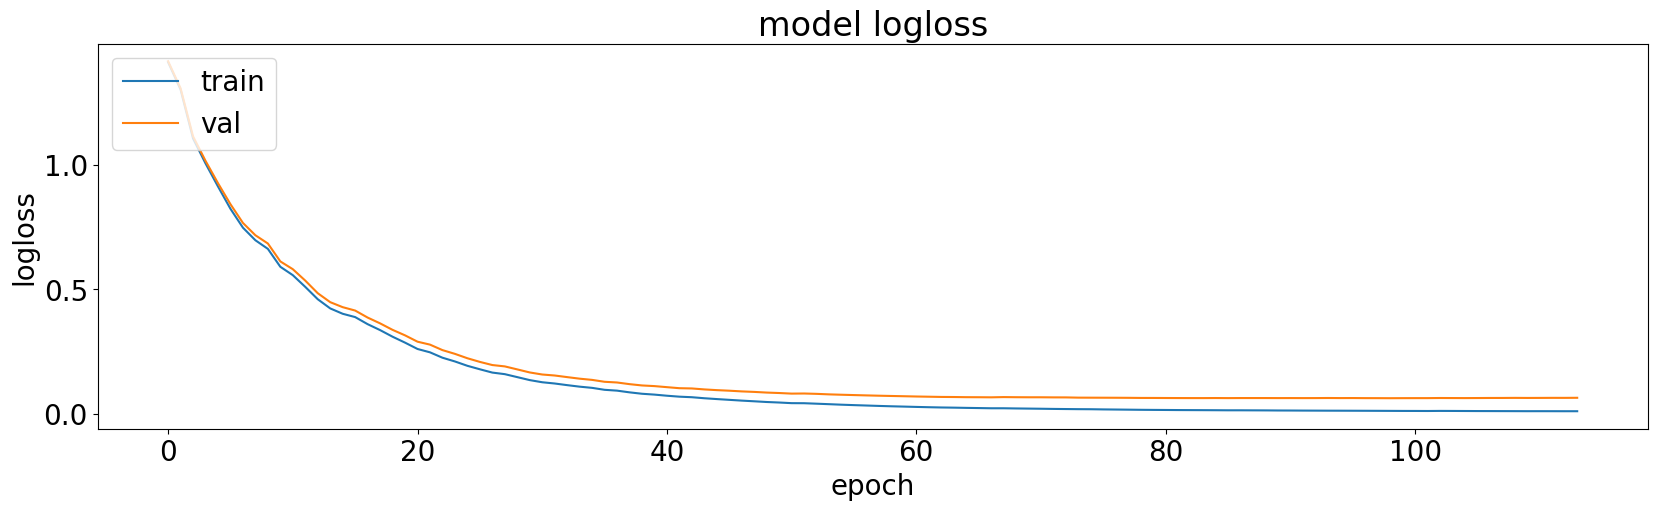

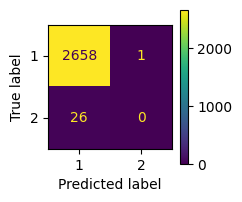

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.99      2685

| 33        | 0.4975    | 0.7616    | 0.2317    | 0.09087   | 14.18     | 1.126     | 0.3109    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


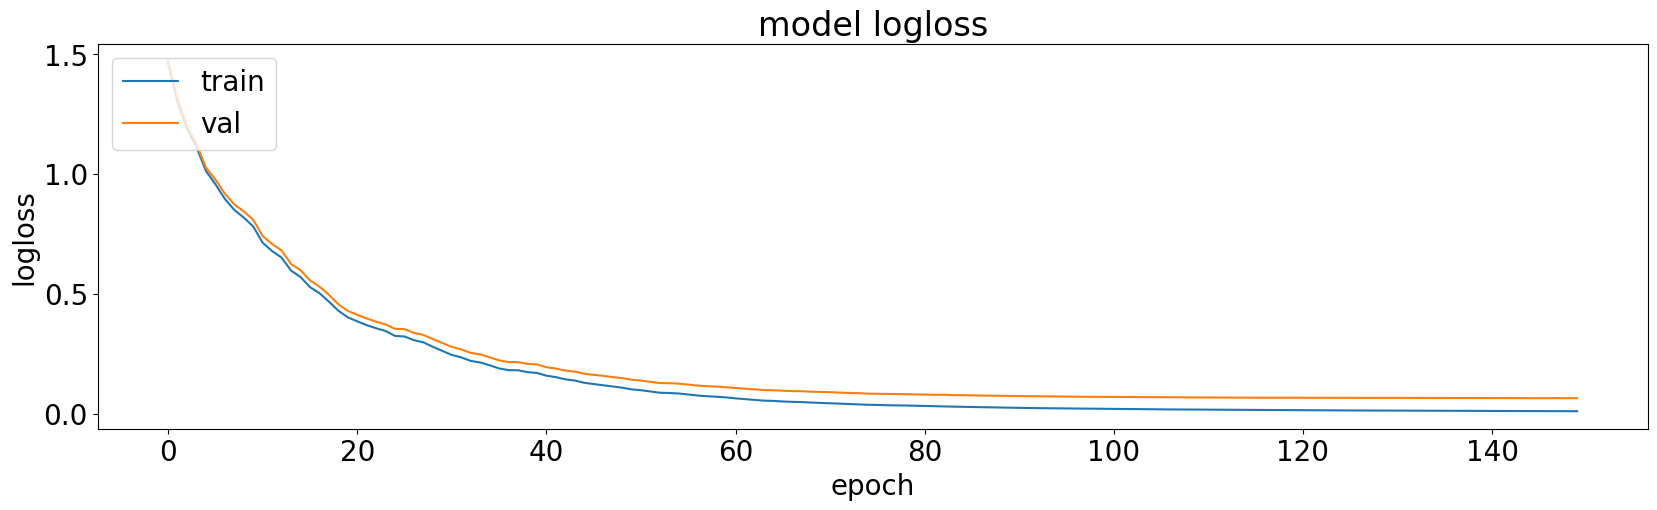

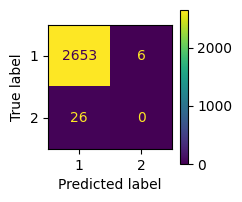

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 34        | 0.4971    | 0.6551    | 0.2847    | 0.09507   | 9.68      | 9.24      | 0.6774    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


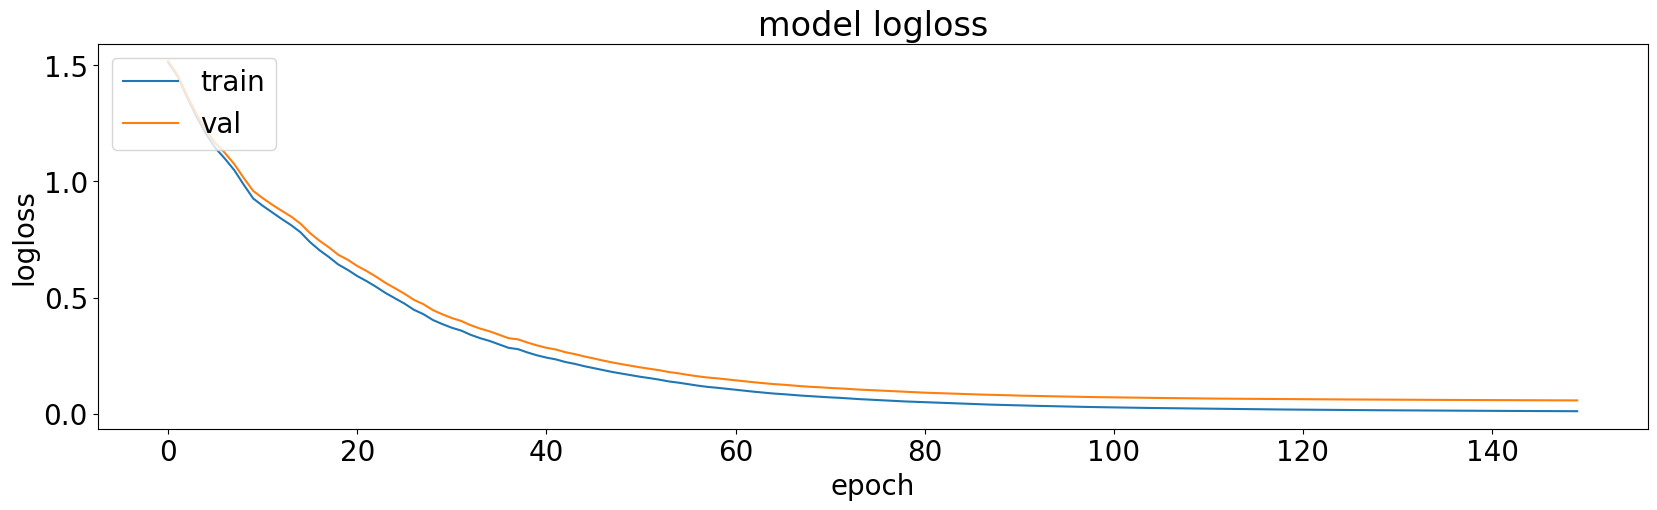

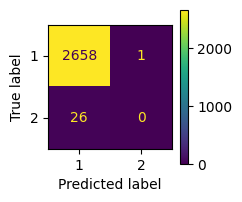

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.99      2685

| 35        | 0.4974    | 0.451     | 0.1458    | 0.06083   | 9.595     | 9.336     | 0.9269    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


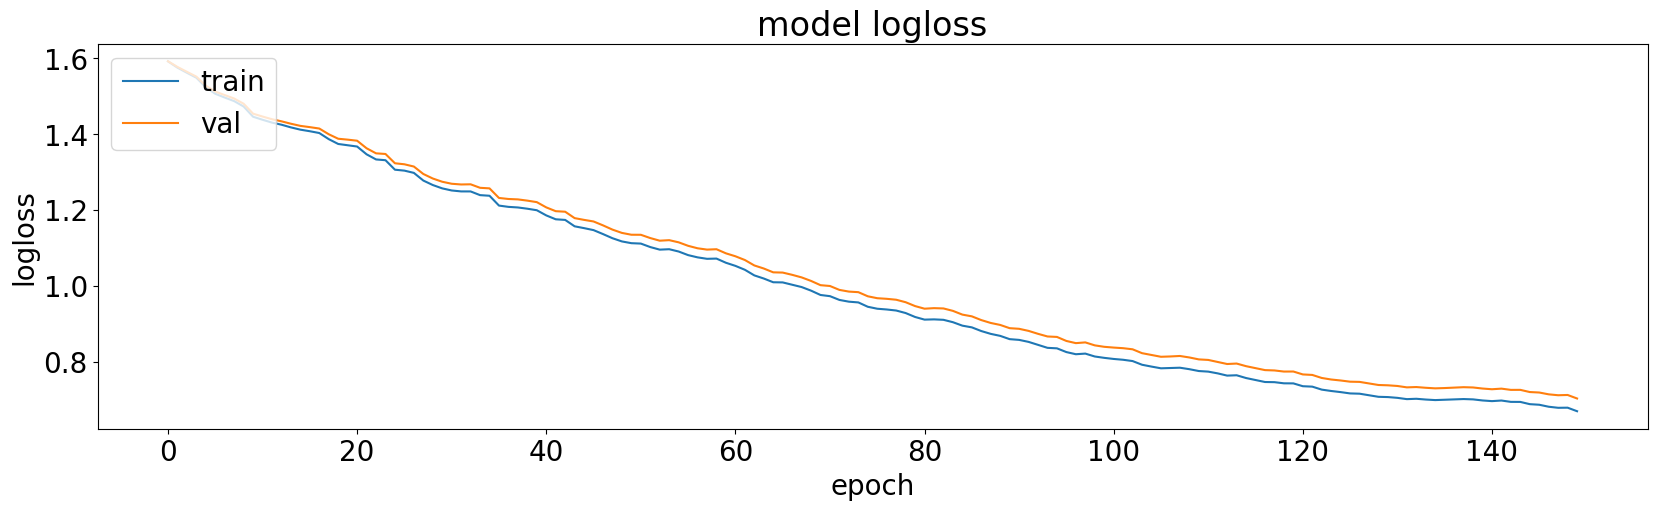

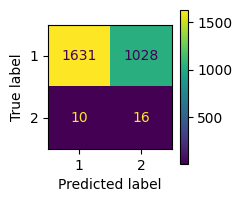

              precision    recall  f1-score   support

           1       0.99      0.61      0.76      2659
           2       0.02      0.62      0.03        26

    accuracy                           0.61      2685
   macro avg       0.50      0.61      0.39      2685
weighted avg       0.98      0.61      0.75      2685

| 36        | 0.3881    | 0.4554    | 0.289     | 0.01822   | 4.516     | 2.216     | 0.5551    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


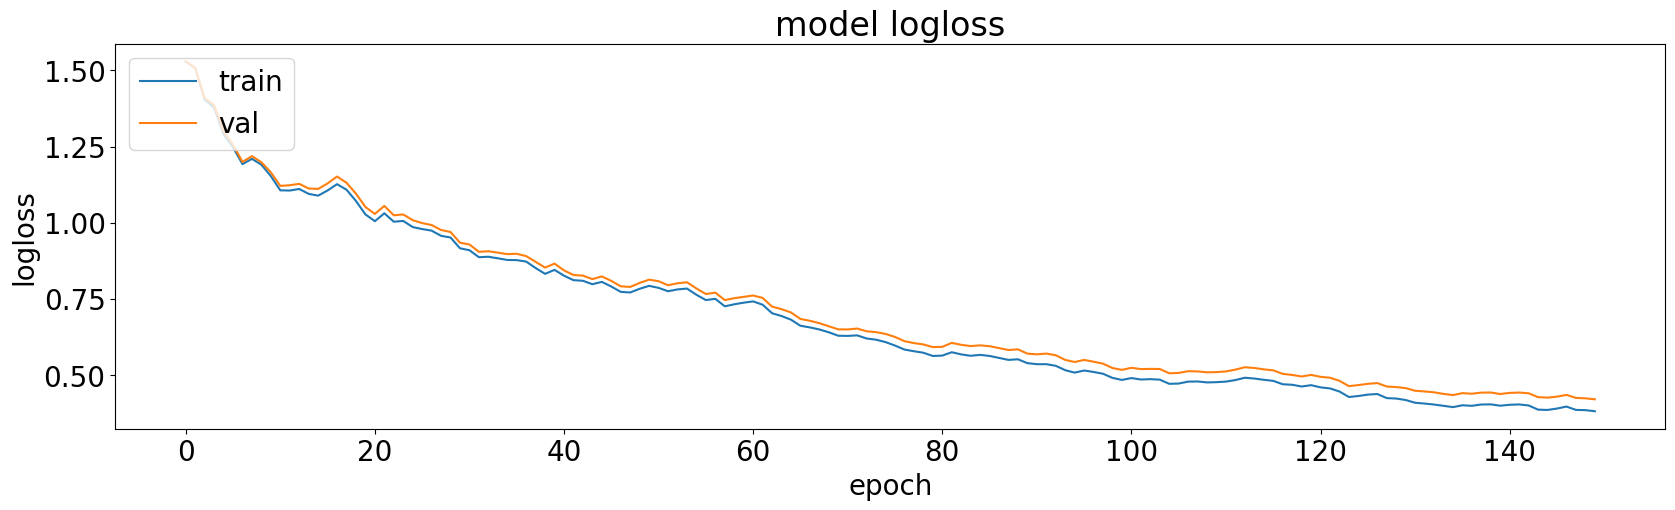

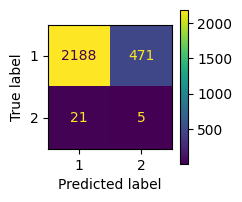

              precision    recall  f1-score   support

           1       0.99      0.82      0.90      2659
           2       0.01      0.19      0.02        26

    accuracy                           0.82      2685
   macro avg       0.50      0.51      0.46      2685
weighted avg       0.98      0.82      0.89      2685

| 37        | 0.4614    | 0.1194    | 0.2844    | 0.08288   | 3.18      | 2.586     | 0.3989    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


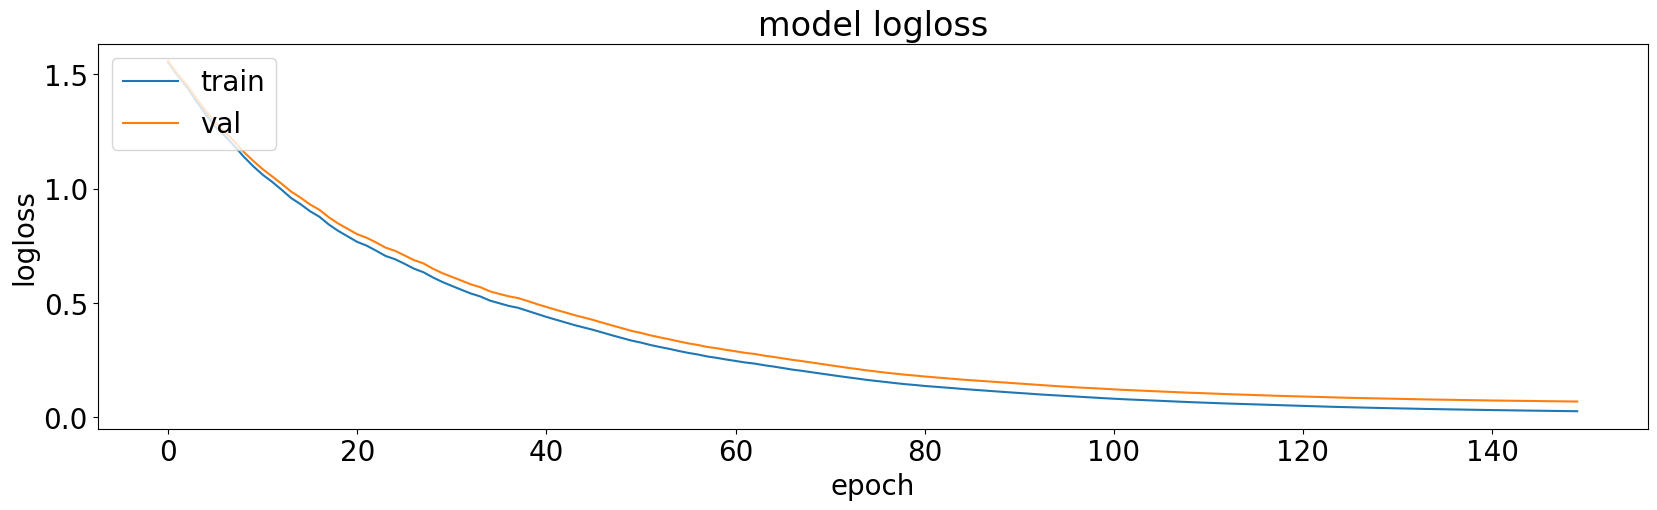

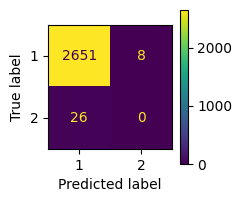

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 38        | 0.5232    | 0.2179    | 0.2428    | 0.03513   | 14.28     | 6.238     | 0.8909    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:17:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


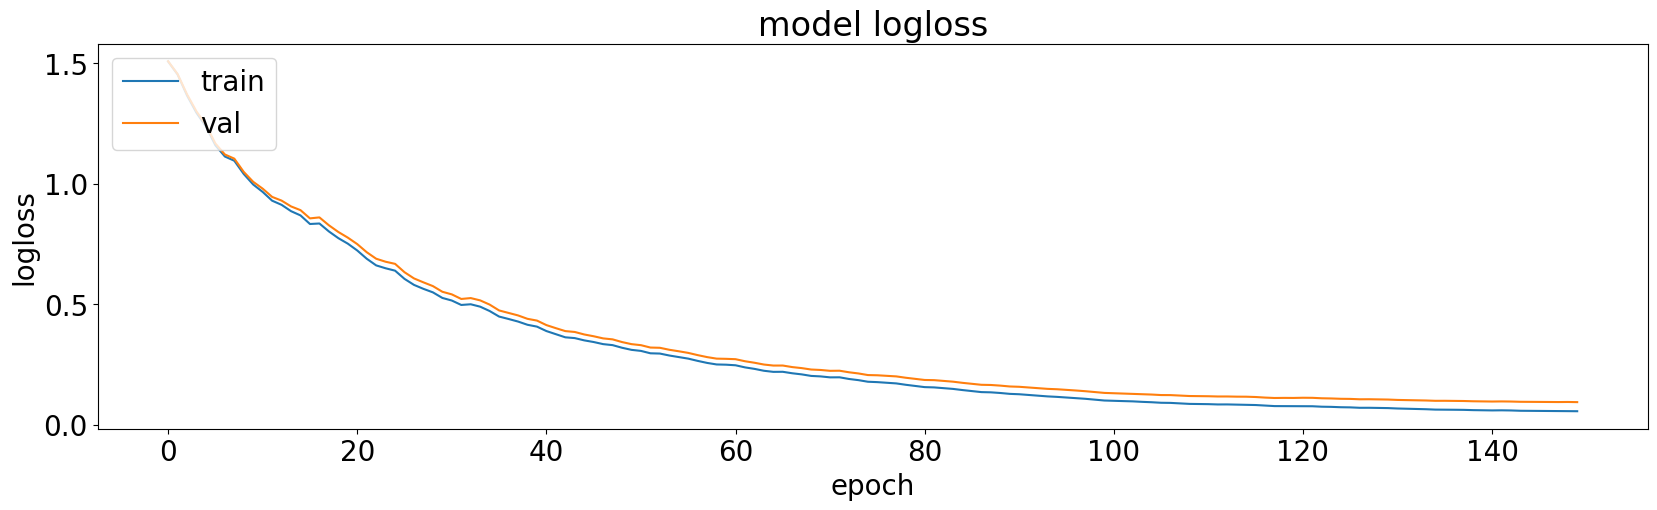

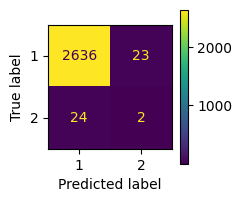

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.08      0.08      0.08        26

    accuracy                           0.98      2685
   macro avg       0.54      0.53      0.53      2685
weighted avg       0.98      0.98      0.98      2685

| 39        | 0.4947    | 0.8603    | 0.2716    | 0.04653   | 9.556     | 8.187     | 0.3571    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


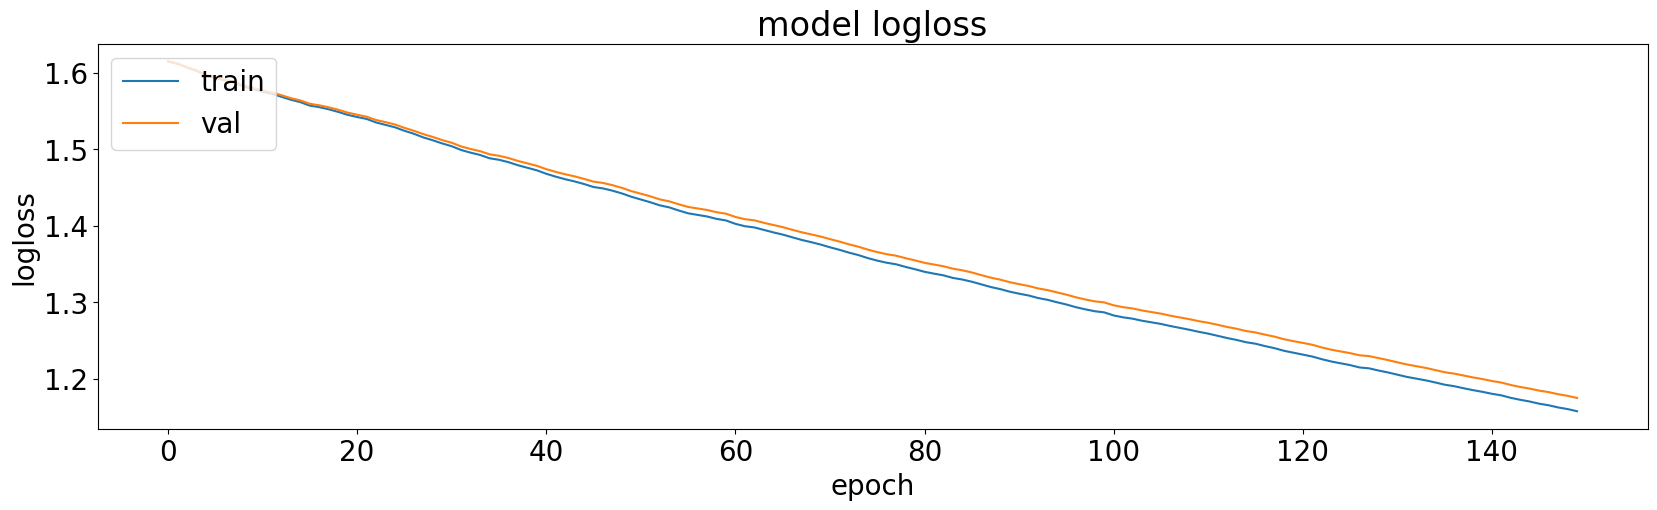

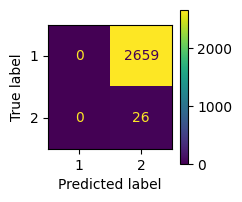

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.01      2685
   macro avg       0.00      0.50      0.01      2685
weighted avg       0.00      0.01      0.00      2685

| 40        | 0.009549  | 0.5412    | 0.1797    | 0.002538  | 10.12     | 4.903     | 0.8266    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


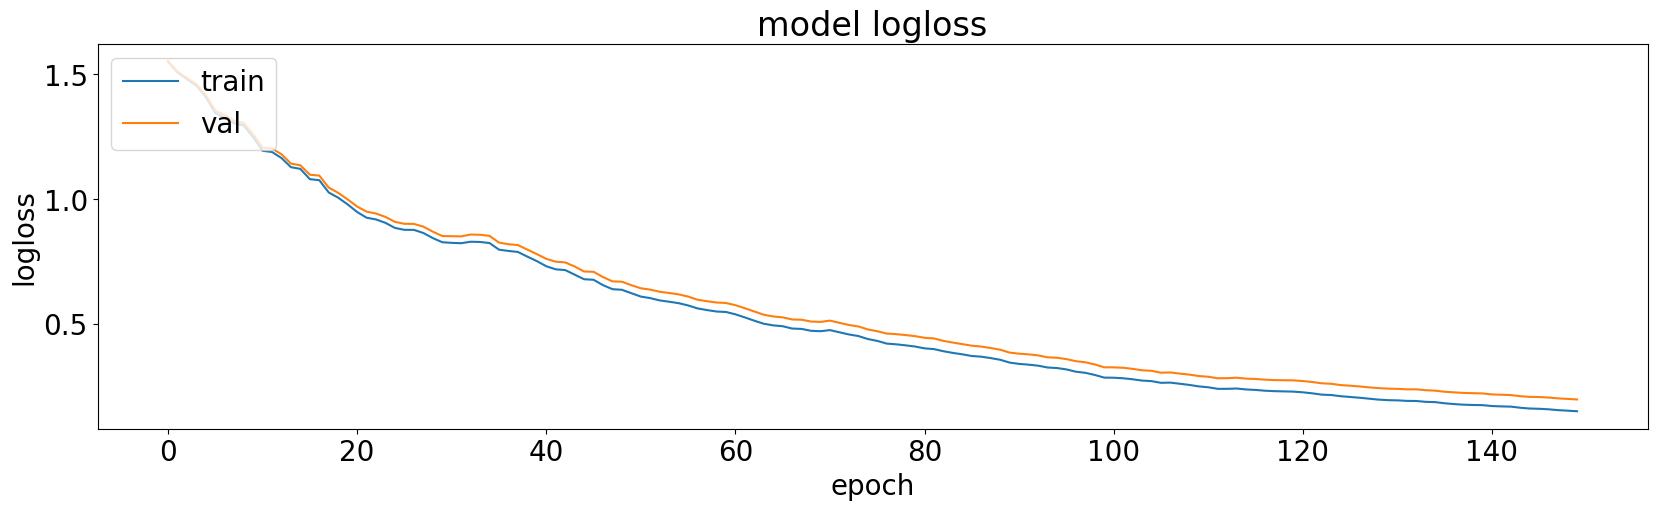

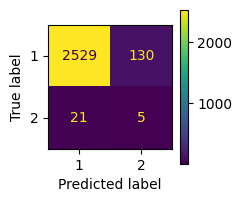

              precision    recall  f1-score   support

           1       0.99      0.95      0.97      2659
           2       0.04      0.19      0.06        26

    accuracy                           0.94      2685
   macro avg       0.51      0.57      0.52      2685
weighted avg       0.98      0.94      0.96      2685

| 41        | 0.4983    | 0.3837    | 0.2679    | 0.05821   | 5.208     | 8.091     | 0.6508    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


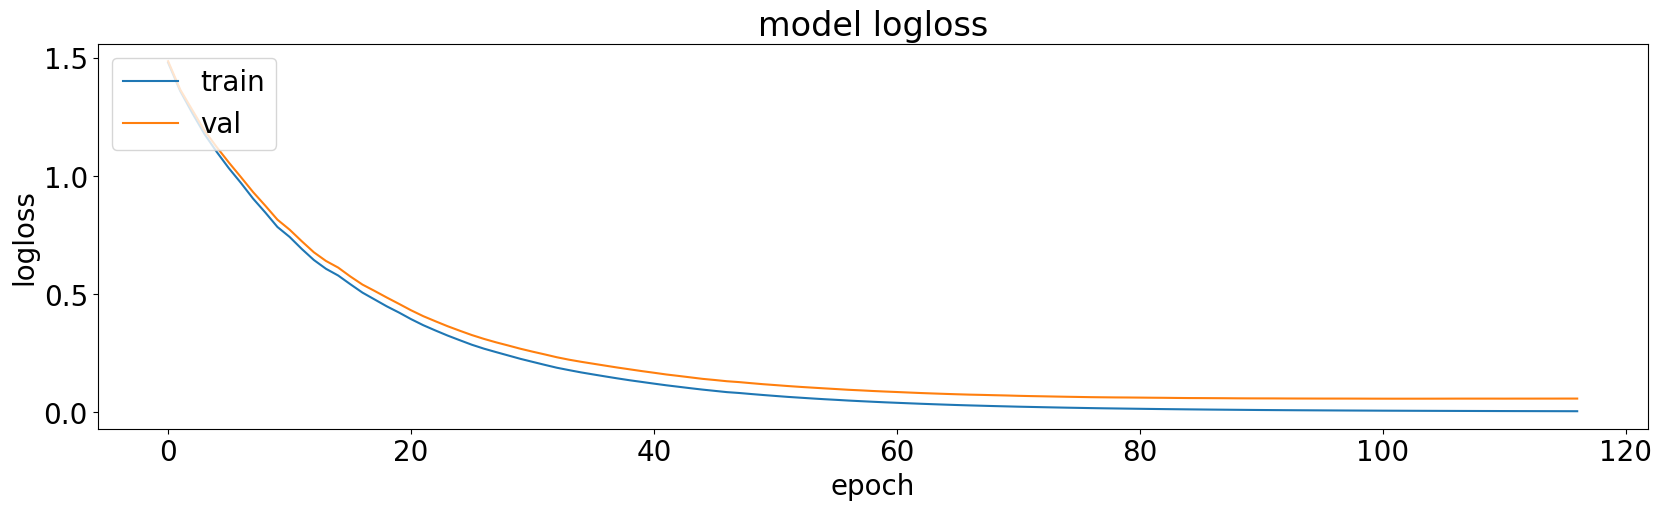

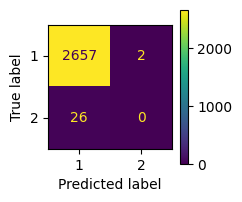

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.99      2685

| 42        | 0.497     | 0.1485    | 0.1261    | 0.06823   | 14.02     | 1.004     | 0.9791    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


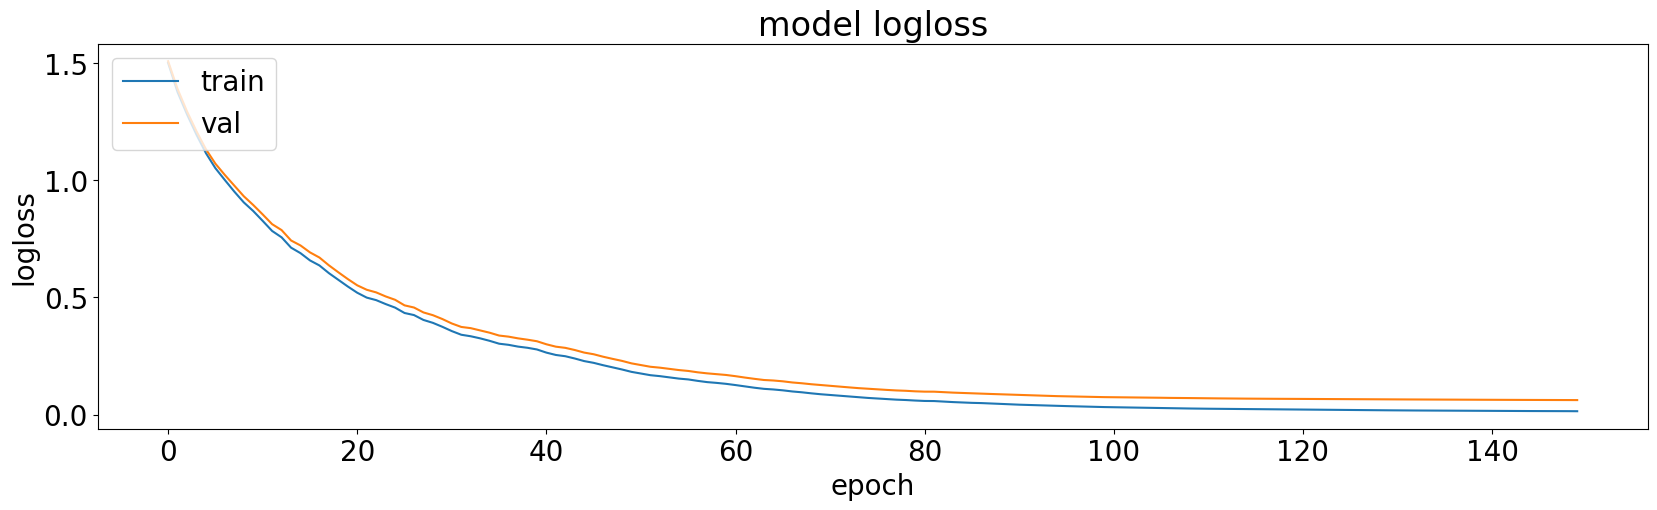

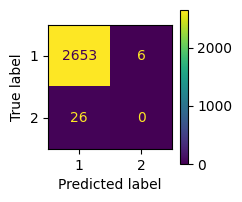

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 43        | 0.5343    | 0.4389    | 0.2921    | 0.06087   | 12.95     | 6.172     | 0.6653    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


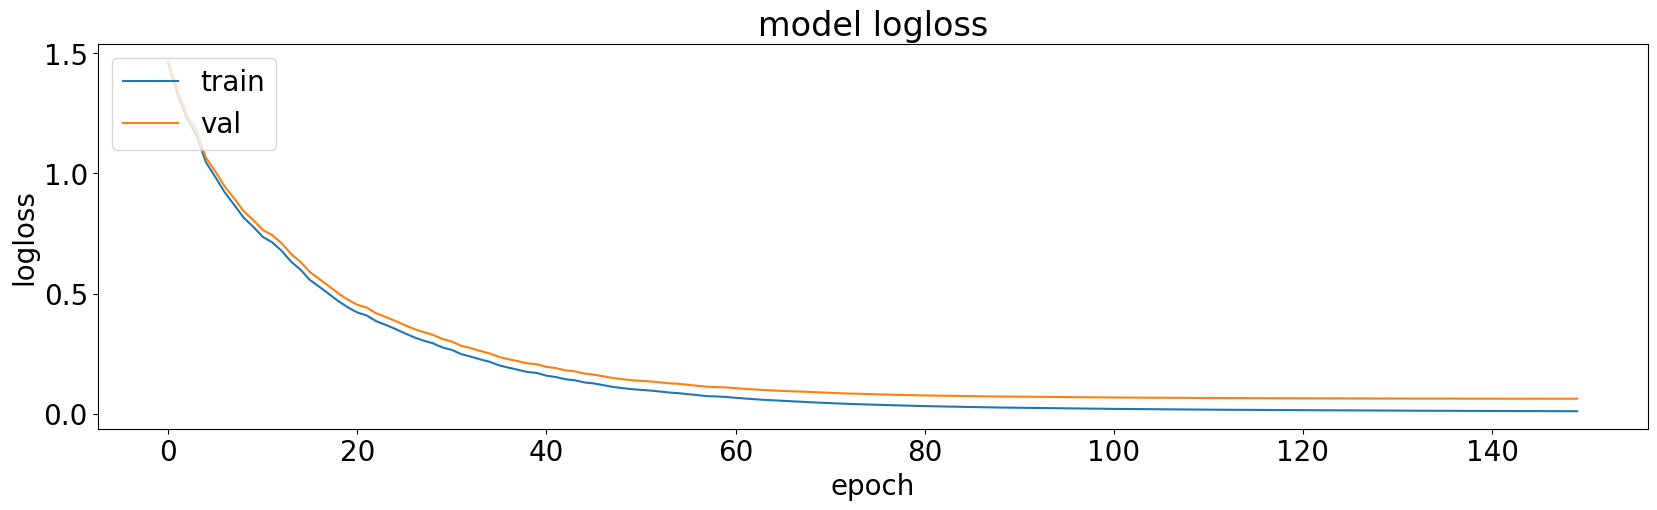

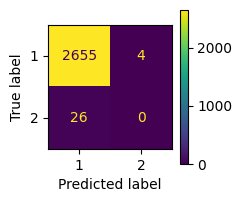

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 44        | 0.4972    | 0.357     | 0.1761    | 0.07525   | 13.3      | 7.796     | 0.7283    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


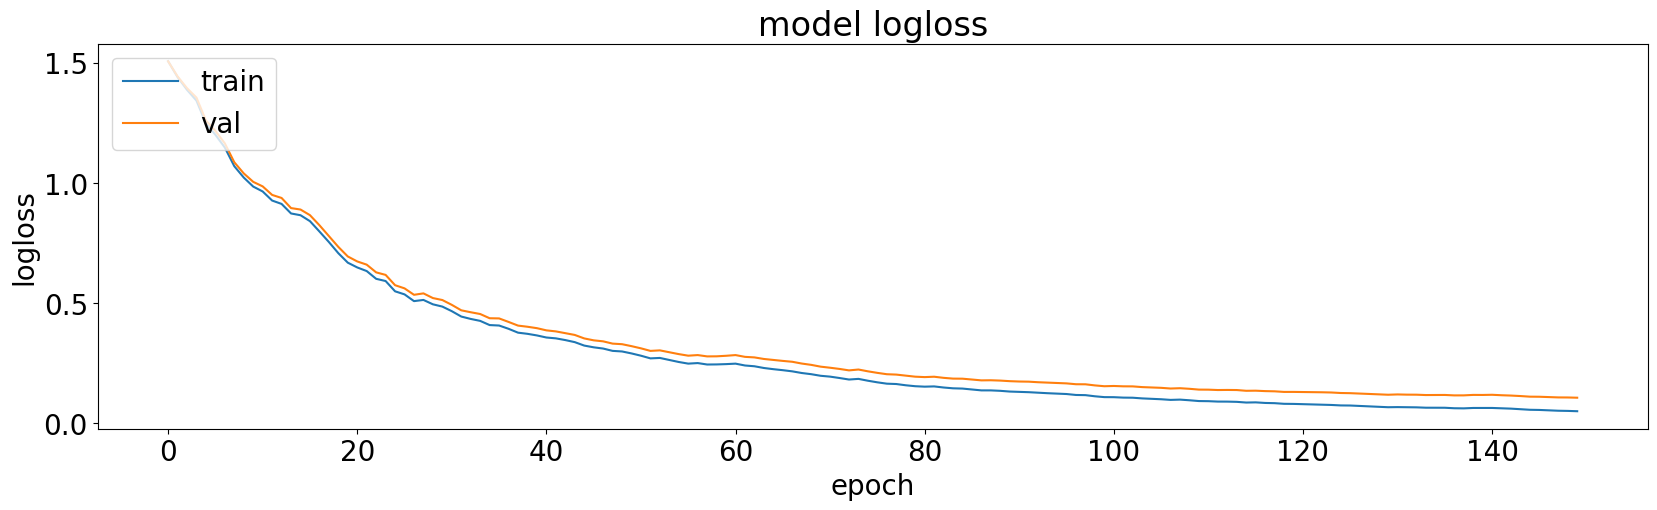

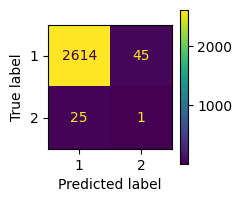

              precision    recall  f1-score   support

           1       0.99      0.98      0.99      2659
           2       0.02      0.04      0.03        26

    accuracy                           0.97      2685
   macro avg       0.51      0.51      0.51      2685
weighted avg       0.98      0.97      0.98      2685

| 45        | 0.4918    | 0.878     | 0.0968    | 0.06741   | 8.41      | 4.439     | 0.4697    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


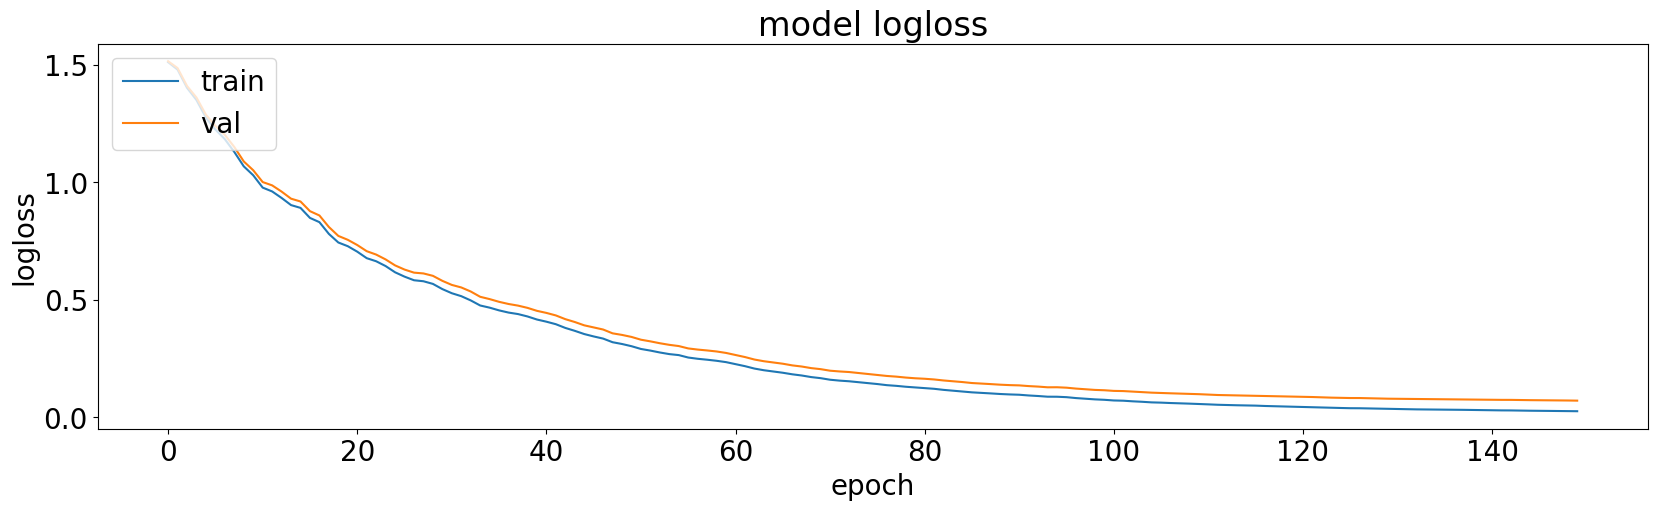

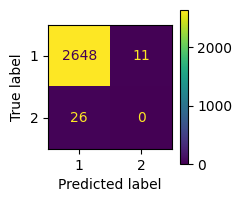

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 46        | 0.5259    | 0.4613    | 0.09522   | 0.06257   | 8.163     | 9.764     | 0.71      |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:18:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


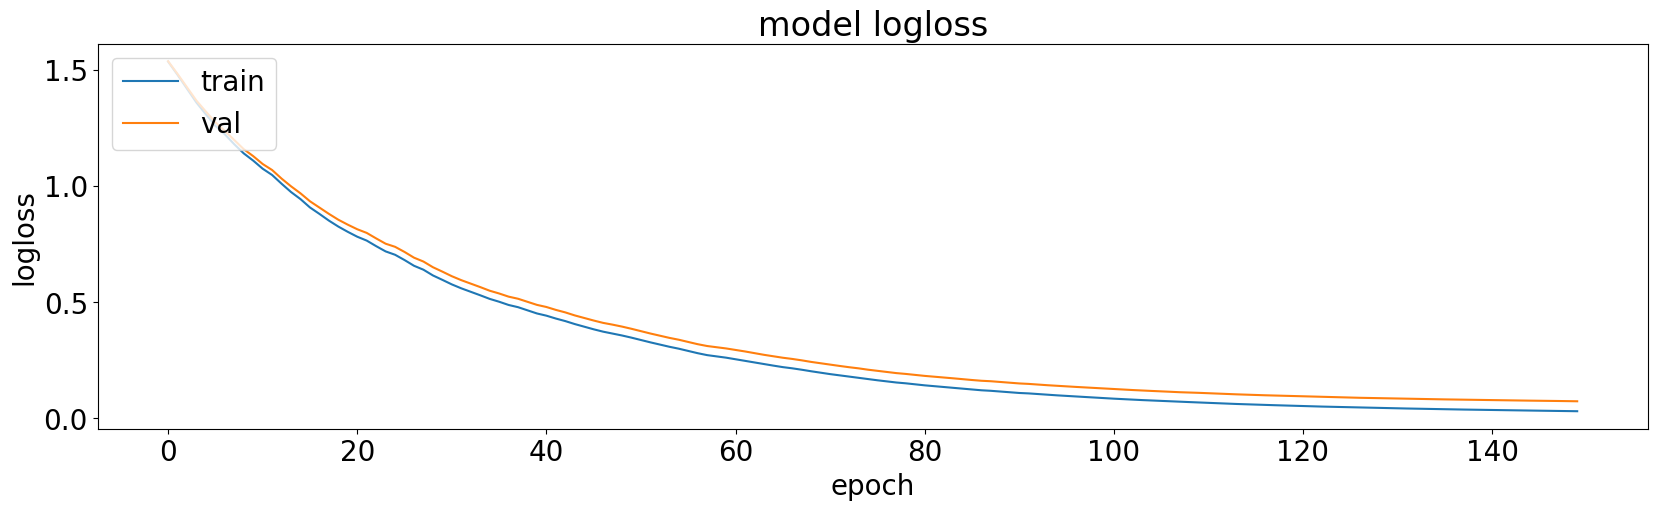

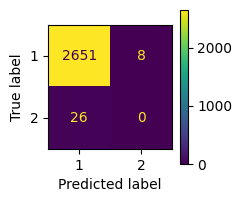

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 47        | 0.4962    | 0.2787    | 0.128     | 0.03499   | 12.57     | 8.92      | 0.9135    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


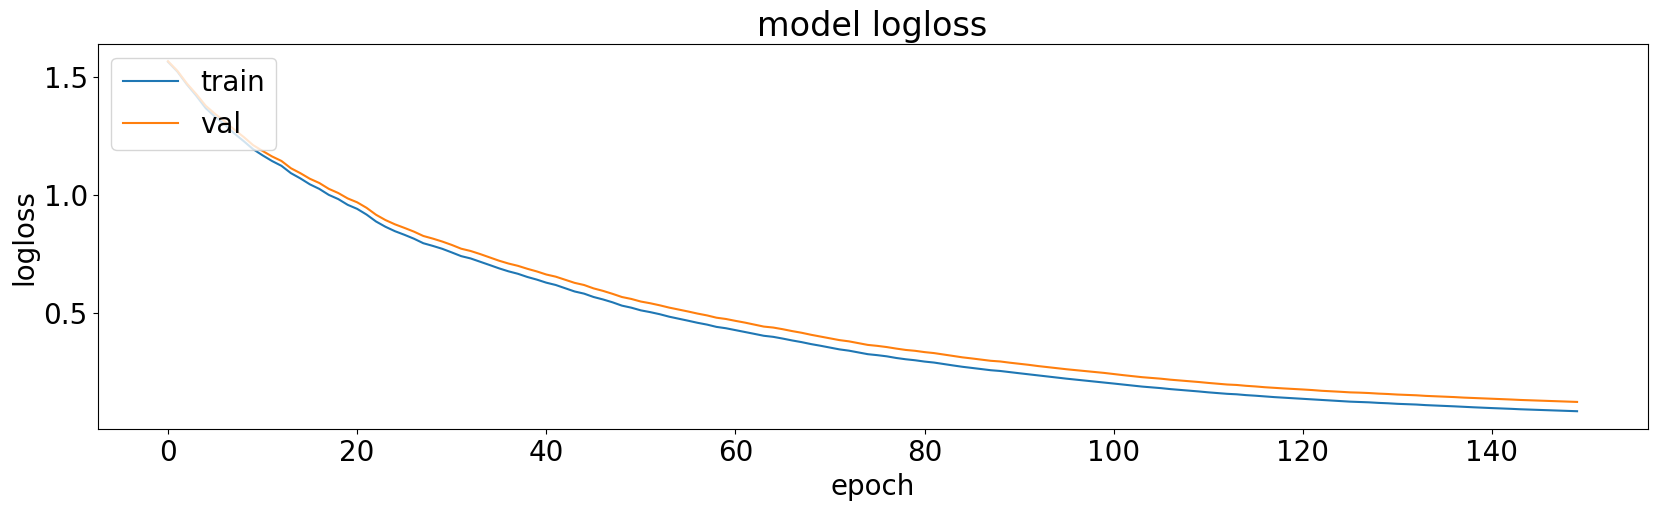

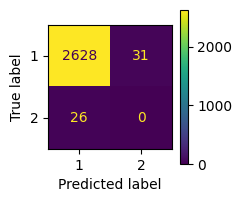

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.98      2685
   macro avg       0.50      0.49      0.49      2685
weighted avg       0.98      0.98      0.98      2685

| 48        | 0.5223    | 0.6964    | 0.08106   | 0.02598   | 13.26     | 5.749     | 0.8219    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


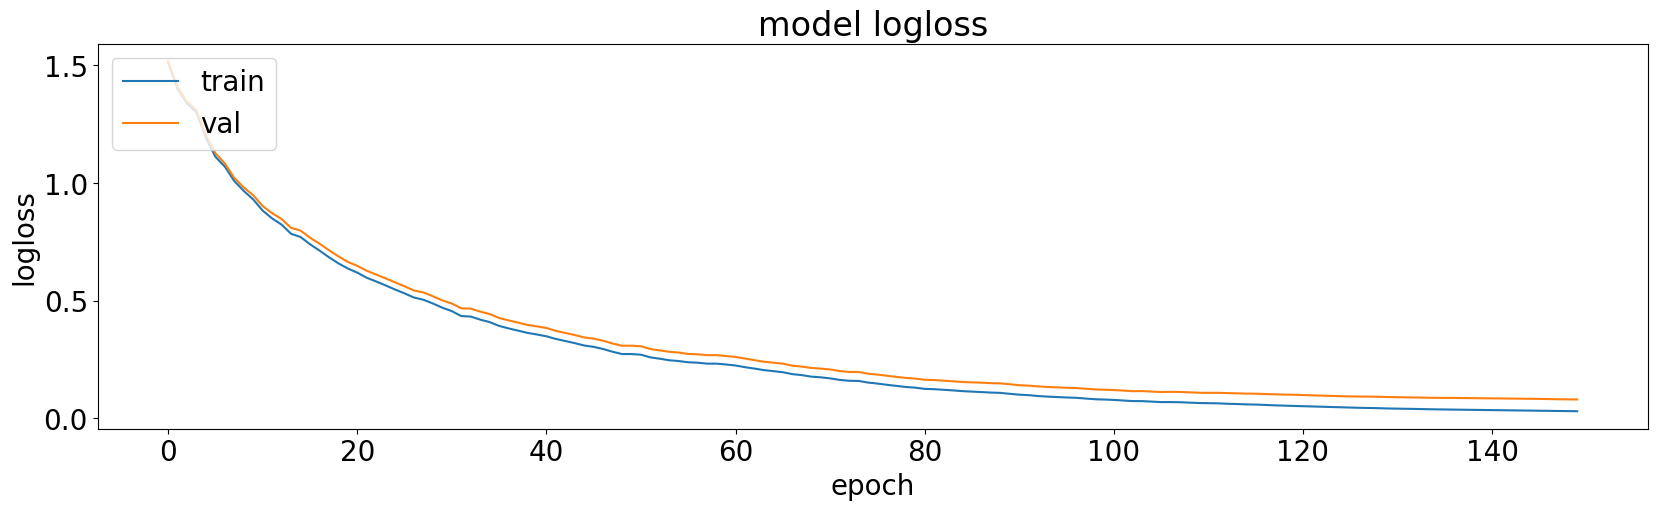

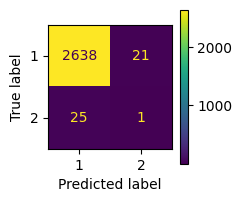

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.05      0.04      0.04        26

    accuracy                           0.98      2685
   macro avg       0.52      0.52      0.52      2685
weighted avg       0.98      0.98      0.98      2685

| 49        | 0.4955    | 0.6152    | 0.2199    | 0.05238   | 12.25     | 6.12      | 0.5191    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


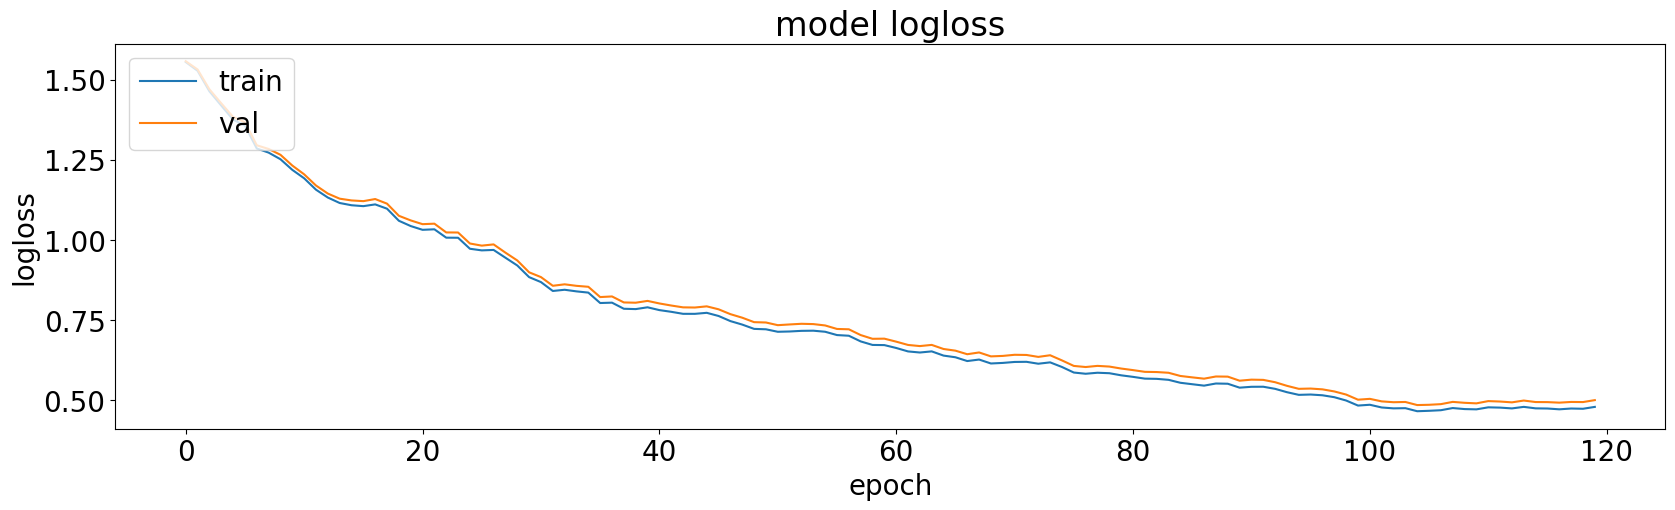

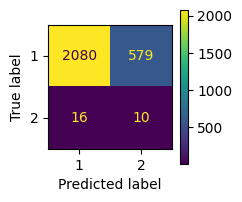

              precision    recall  f1-score   support

           1       0.99      0.78      0.87      2659
           2       0.02      0.38      0.03        26

    accuracy                           0.78      2685
   macro avg       0.50      0.58      0.45      2685
weighted avg       0.98      0.78      0.87      2685

| 50        | 0.4475    | 0.4084    | 0.02046   | 0.03841   | 3.956     | 9.845     | 0.2635    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


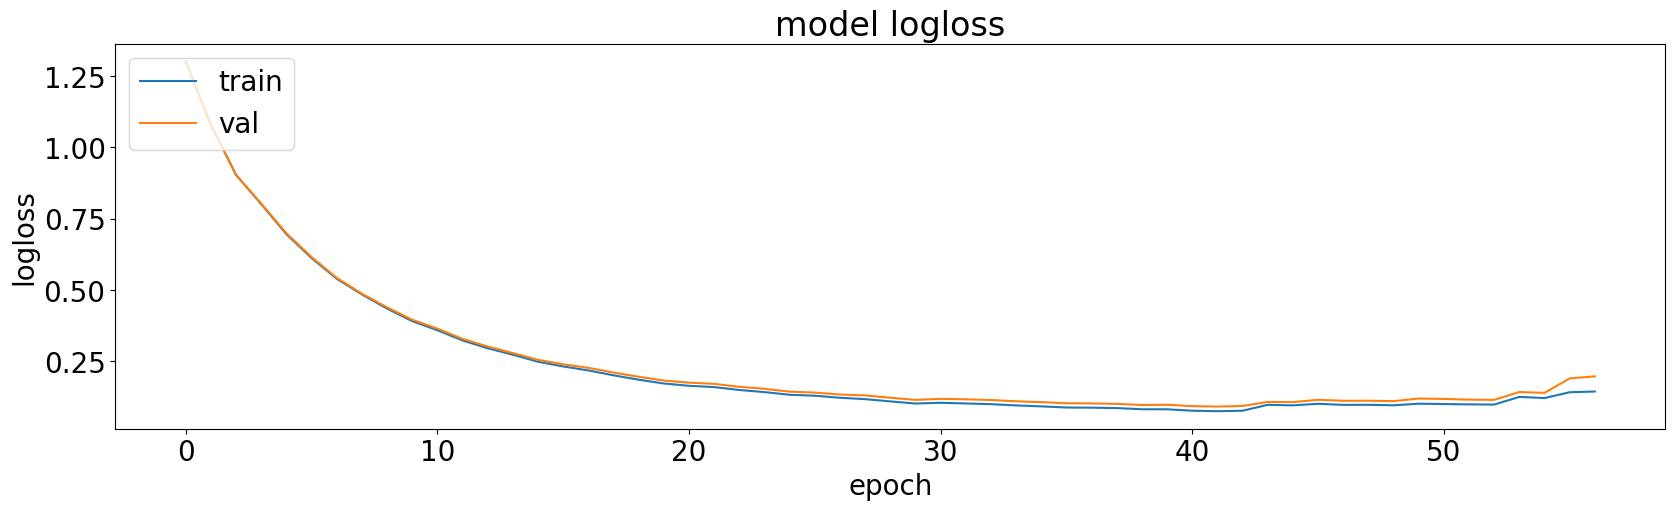

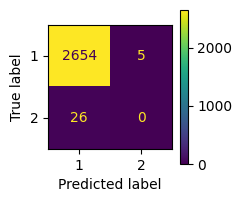

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 51        | 0.524     | 0.1       | 0.3       | 0.1       | 9.225     | 4.628     | 0.1       |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


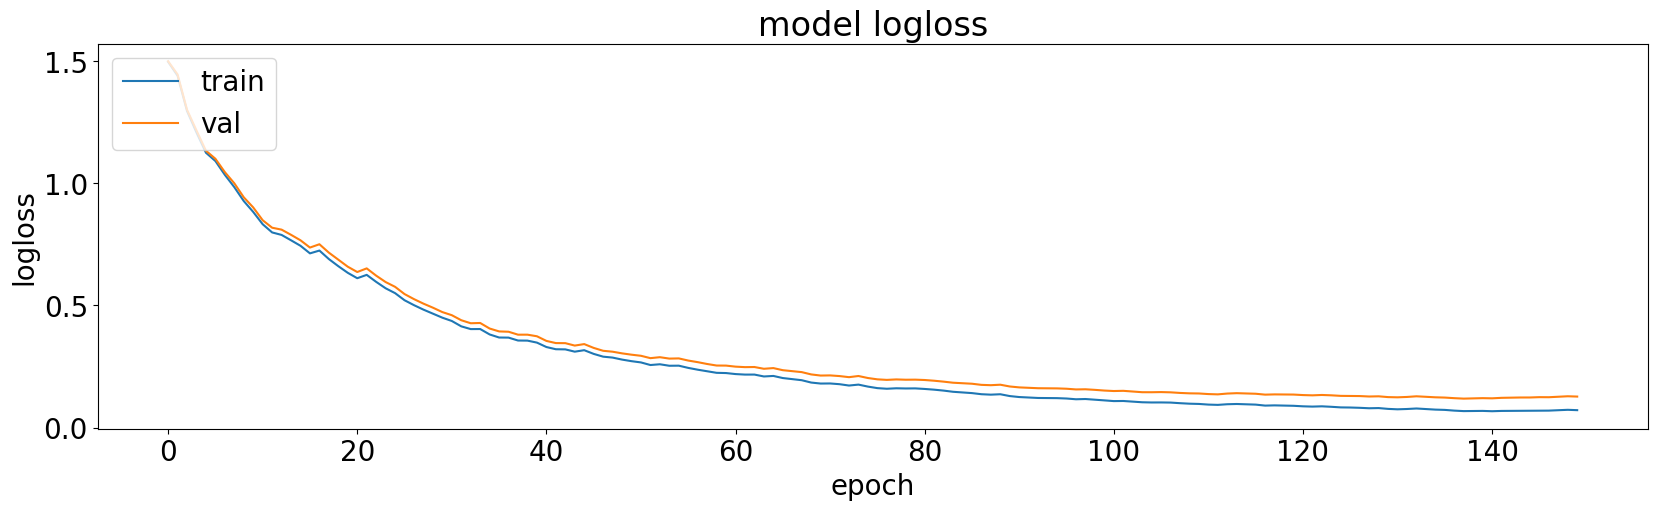

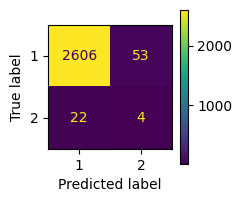

              precision    recall  f1-score   support

           1       0.99      0.98      0.99      2659
           2       0.07      0.15      0.10        26

    accuracy                           0.97      2685
   macro avg       0.53      0.57      0.54      2685
weighted avg       0.98      0.97      0.98      2685

| 52        | 0.5033    | 0.6379    | 0.09552   | 0.06664   | 8.381     | 2.55      | 0.3726    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


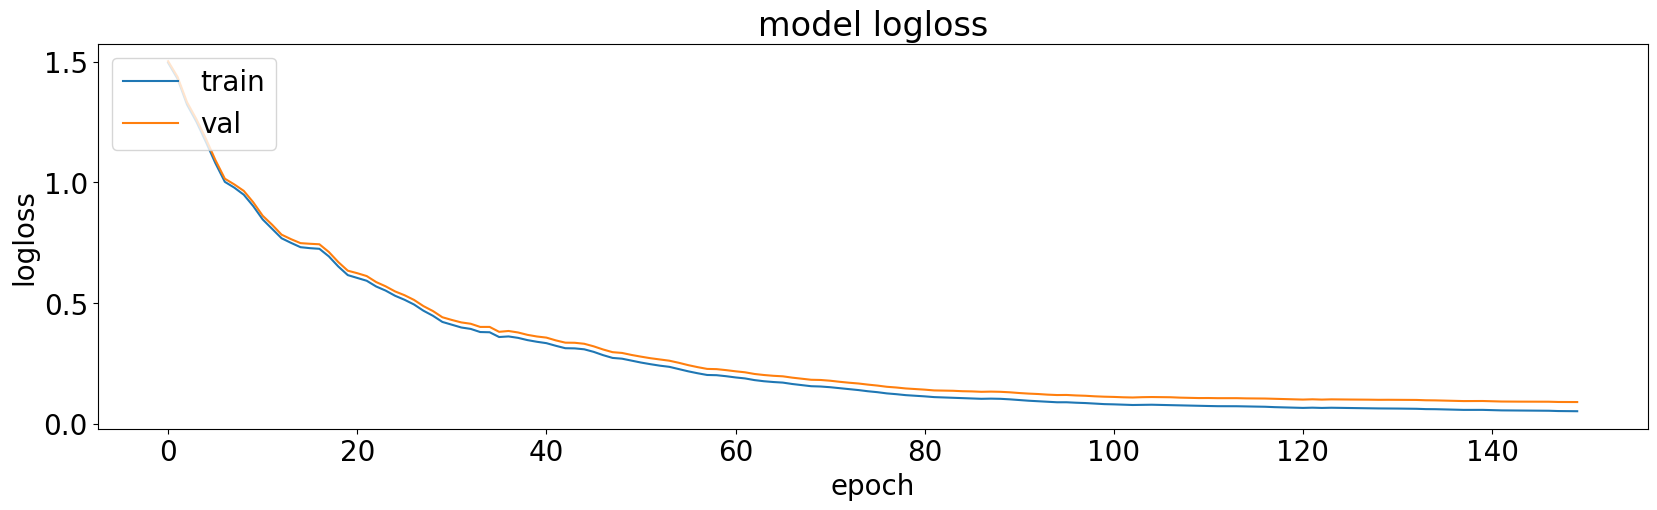

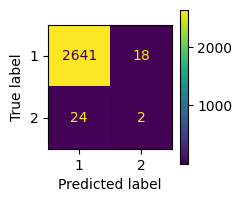

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.10      0.08      0.09        26

    accuracy                           0.98      2685
   macro avg       0.55      0.54      0.54      2685
weighted avg       0.98      0.98      0.98      2685

| 53        | 0.4956    | 0.6989    | 0.2341    | 0.05264   | 10.05     | 9.195     | 0.268     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


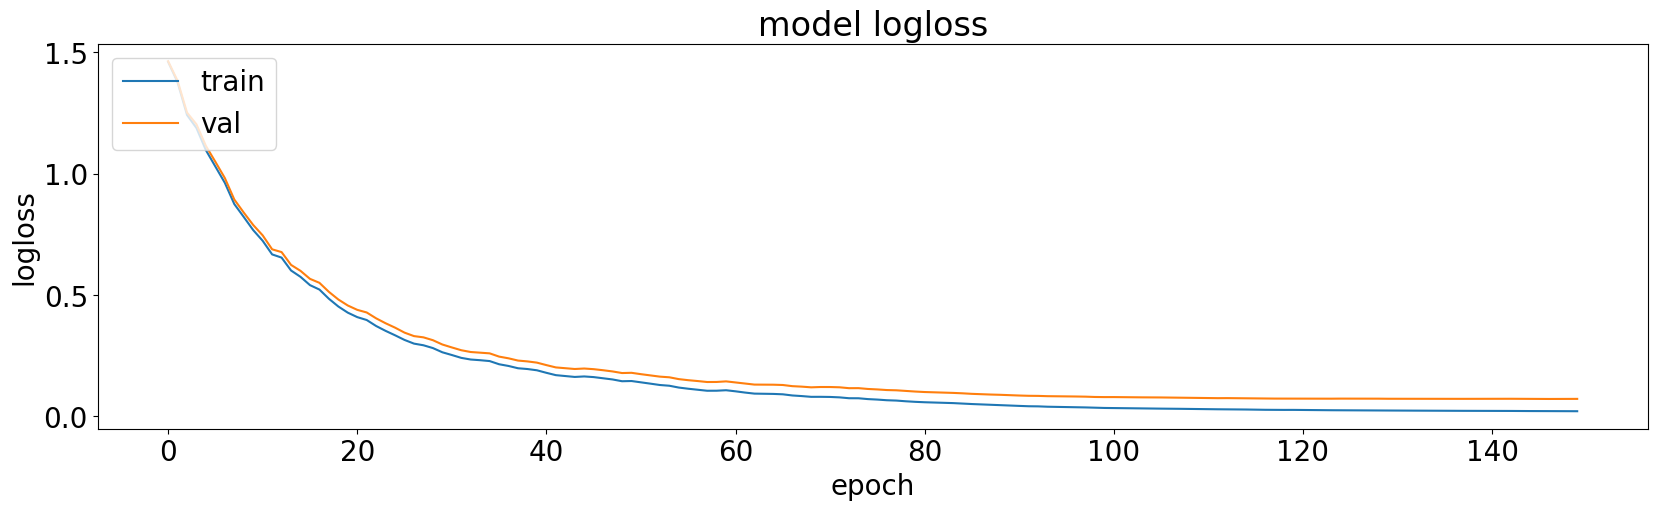

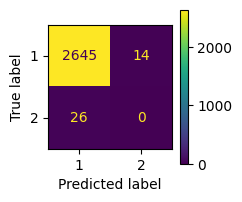

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 54        | 0.4962    | 0.4686    | 0.03669   | 0.07327   | 13.42     | 6.966     | 0.4555    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


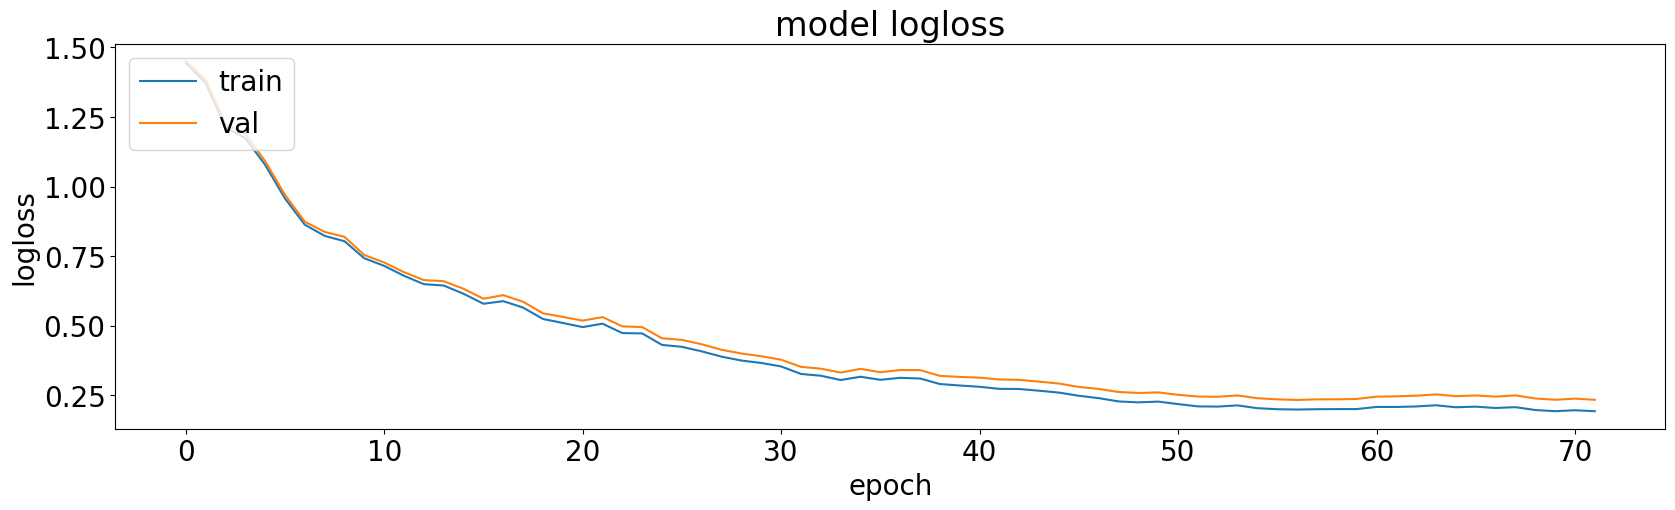

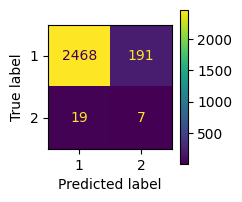

              precision    recall  f1-score   support

           1       0.99      0.93      0.96      2659
           2       0.04      0.27      0.06        26

    accuracy                           0.92      2685
   macro avg       0.51      0.60      0.51      2685
weighted avg       0.98      0.92      0.95      2685



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


| 55        | 0.4961    | 1.0       | 0.0       | 0.1       | 5.521     | 7.624     | 0.2834    |


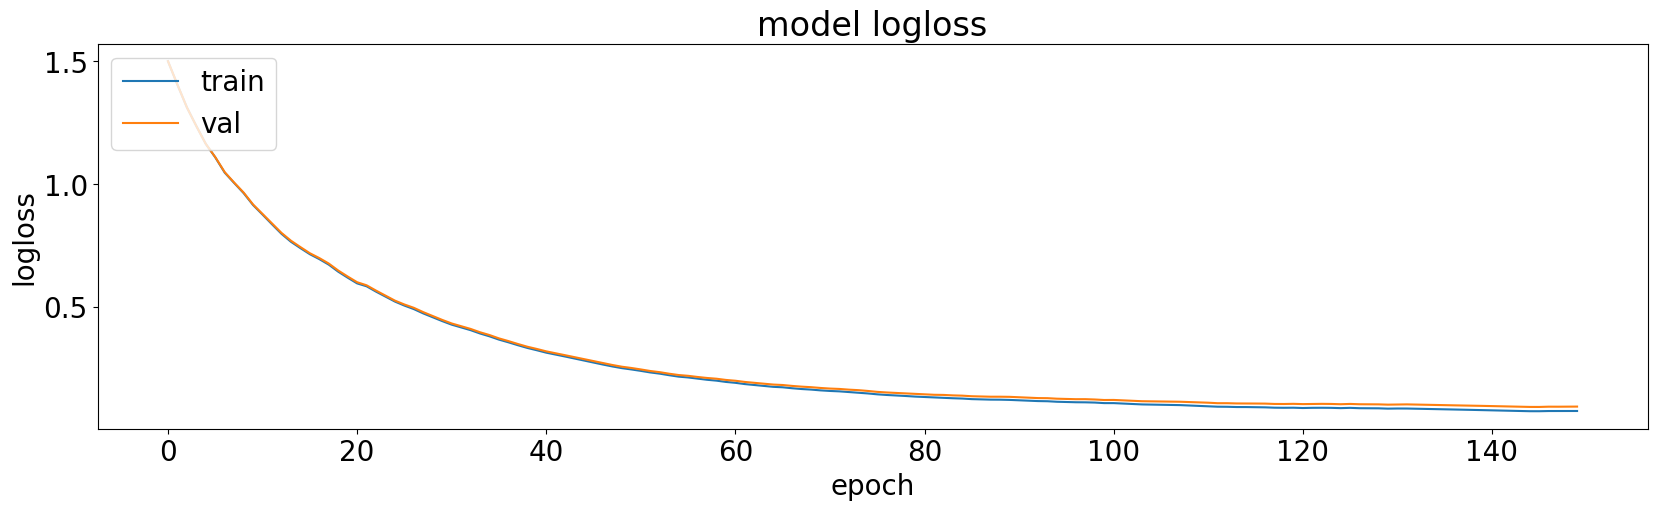

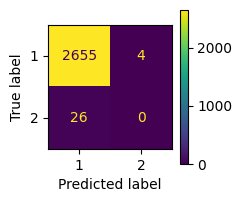

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 56        | 0.4975    | 0.7246    | 0.1721    | 0.03358   | 11.52     | 8.177     | 0.1273    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:19:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


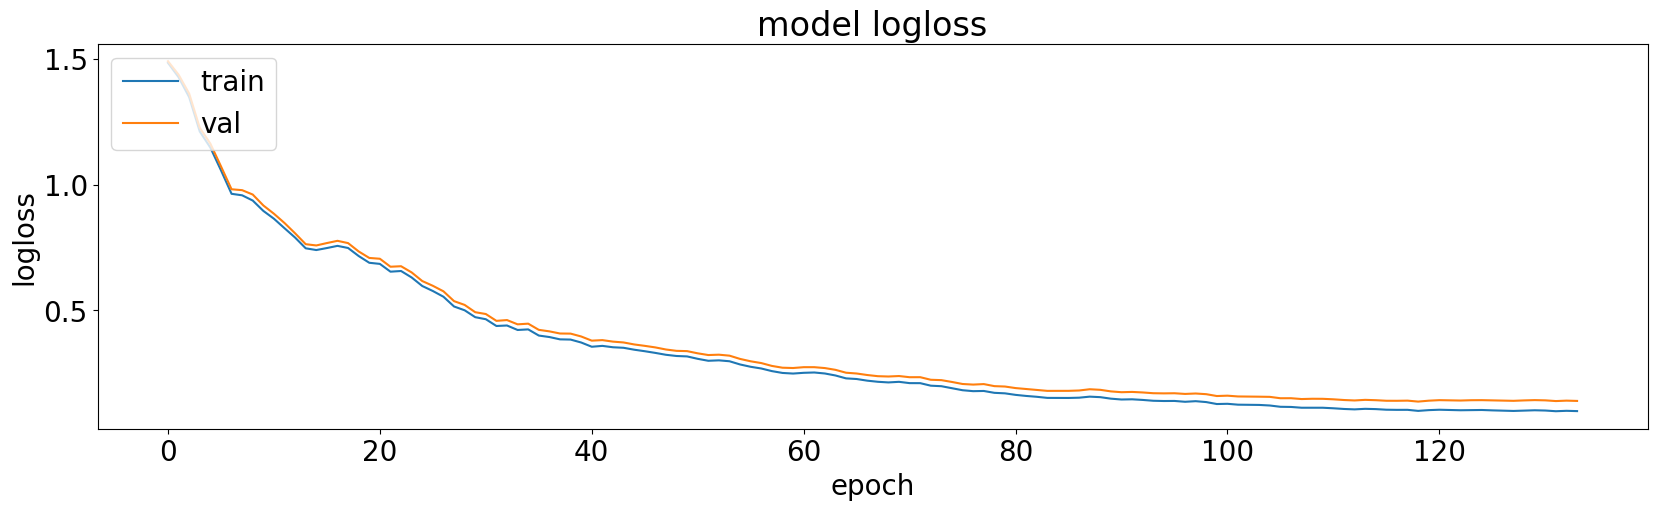

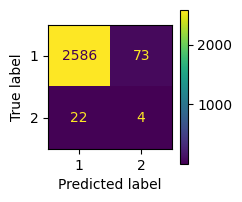

              precision    recall  f1-score   support

           1       0.99      0.97      0.98      2659
           2       0.05      0.15      0.08        26

    accuracy                           0.96      2685
   macro avg       0.52      0.56      0.53      2685
weighted avg       0.98      0.96      0.97      2685

| 57        | 0.4988    | 0.6519    | 0.1775    | 0.0695    | 5.525     | 1.017     | 0.2605    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


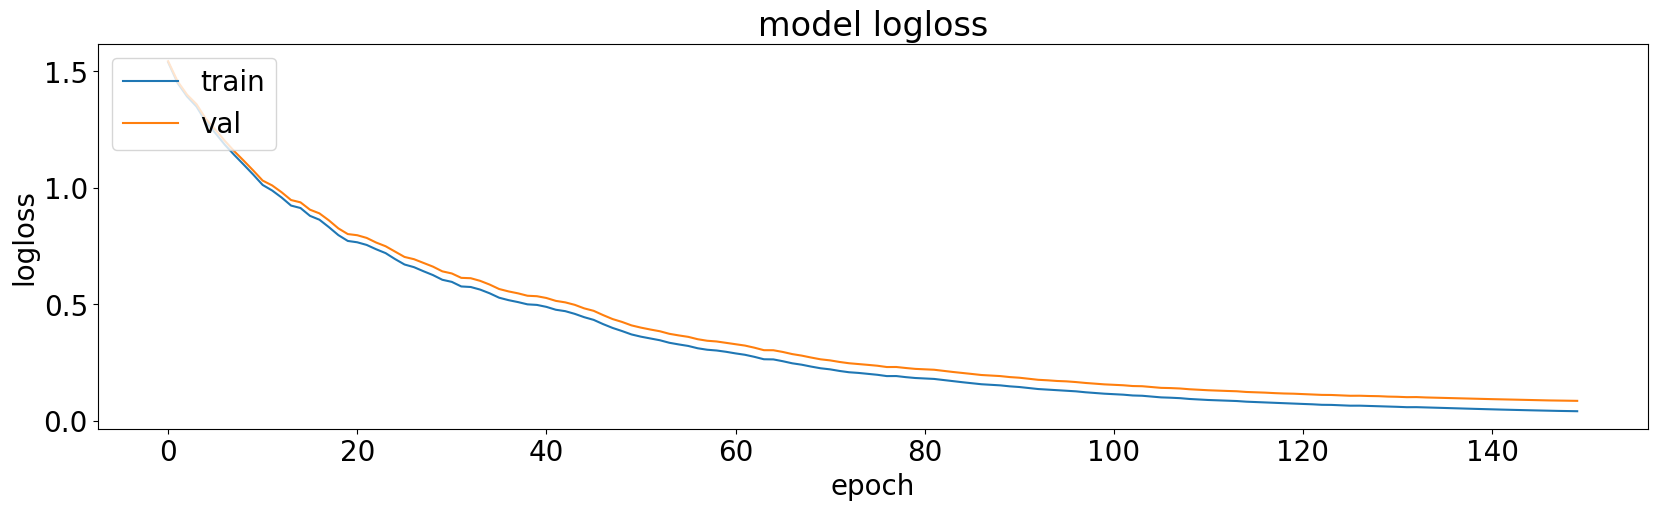

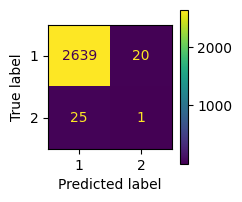

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.05      0.04      0.04        26

    accuracy                           0.98      2685
   macro avg       0.52      0.52      0.52      2685
weighted avg       0.98      0.98      0.98      2685

| 58        | 0.5175    | 0.6159    | 0.1892    | 0.0468    | 9.597     | 9.264     | 0.6881    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


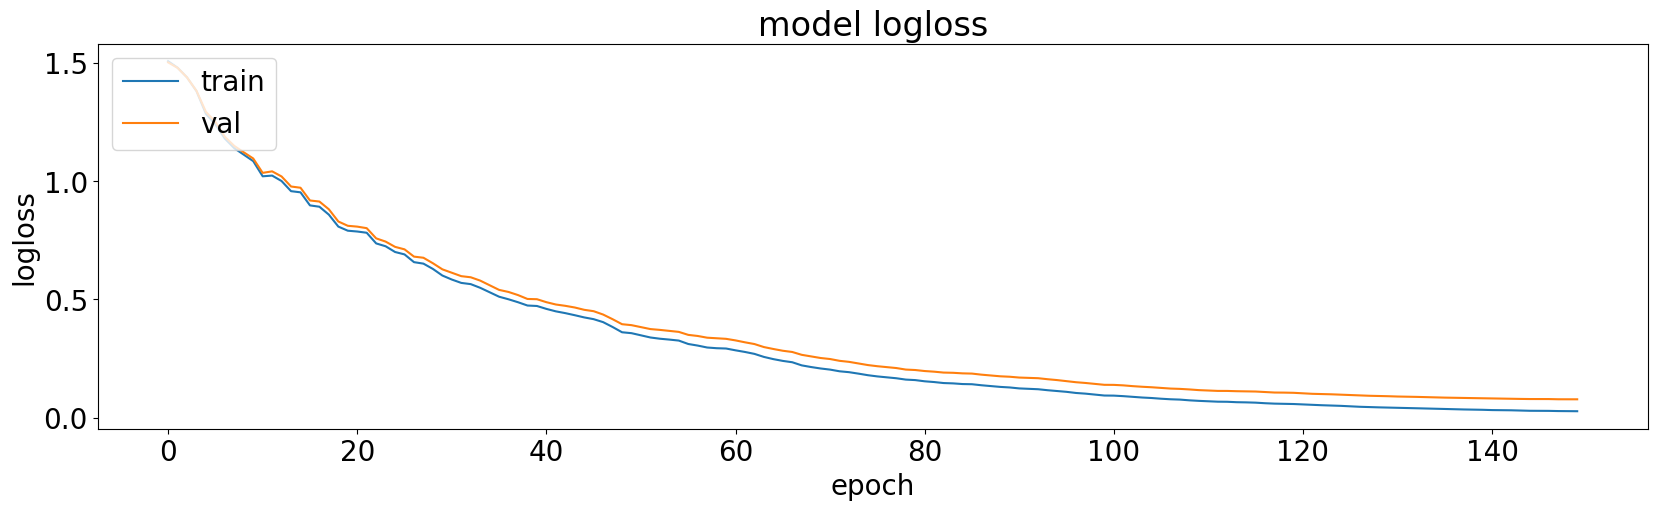

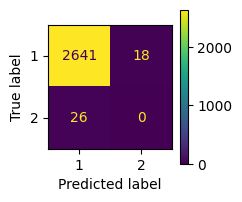

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.98      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.98      0.98      2685

| 59        | 0.5169    | 0.2482    | 0.06131   | 0.1       | 4.5       | 3.842     | 0.7412    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


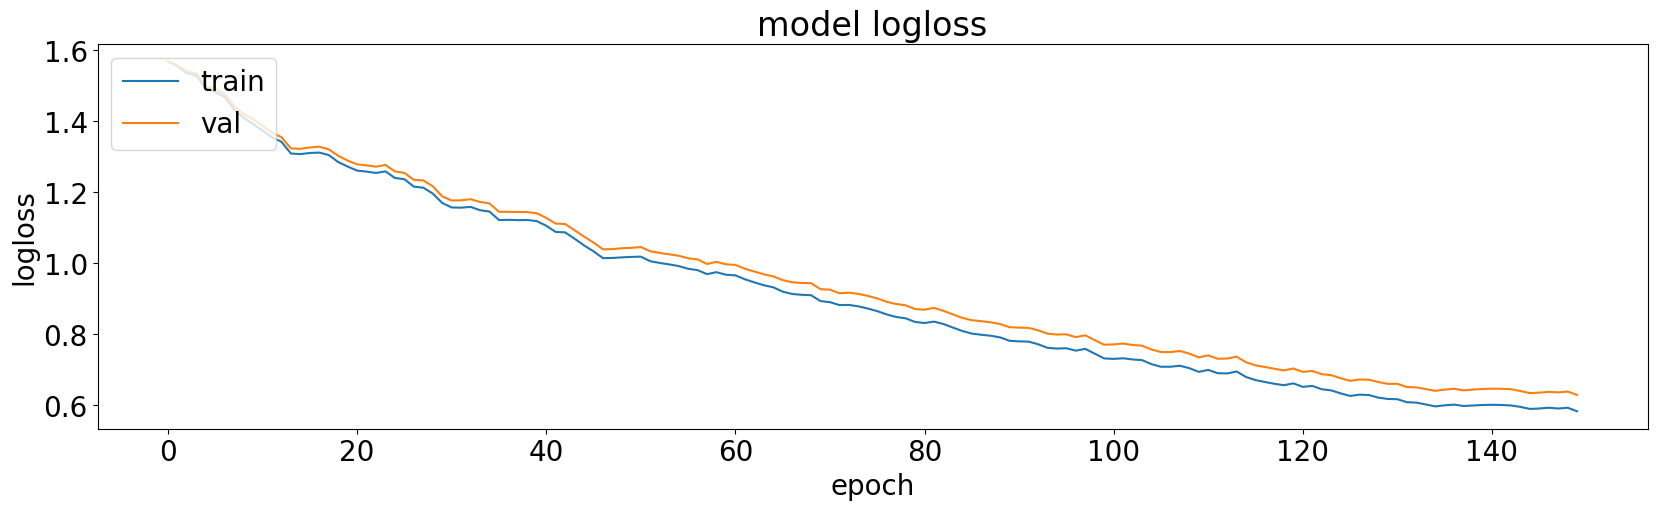

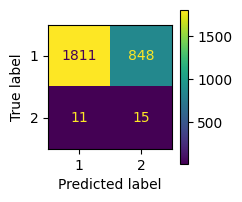

              precision    recall  f1-score   support

           1       0.99      0.68      0.81      2659
           2       0.02      0.58      0.03        26

    accuracy                           0.68      2685
   macro avg       0.51      0.63      0.42      2685
weighted avg       0.98      0.68      0.80      2685

| 60        | 0.4151    | 0.2298    | 0.2612    | 0.04821   | 3.465     | 3.997     | 0.5378    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


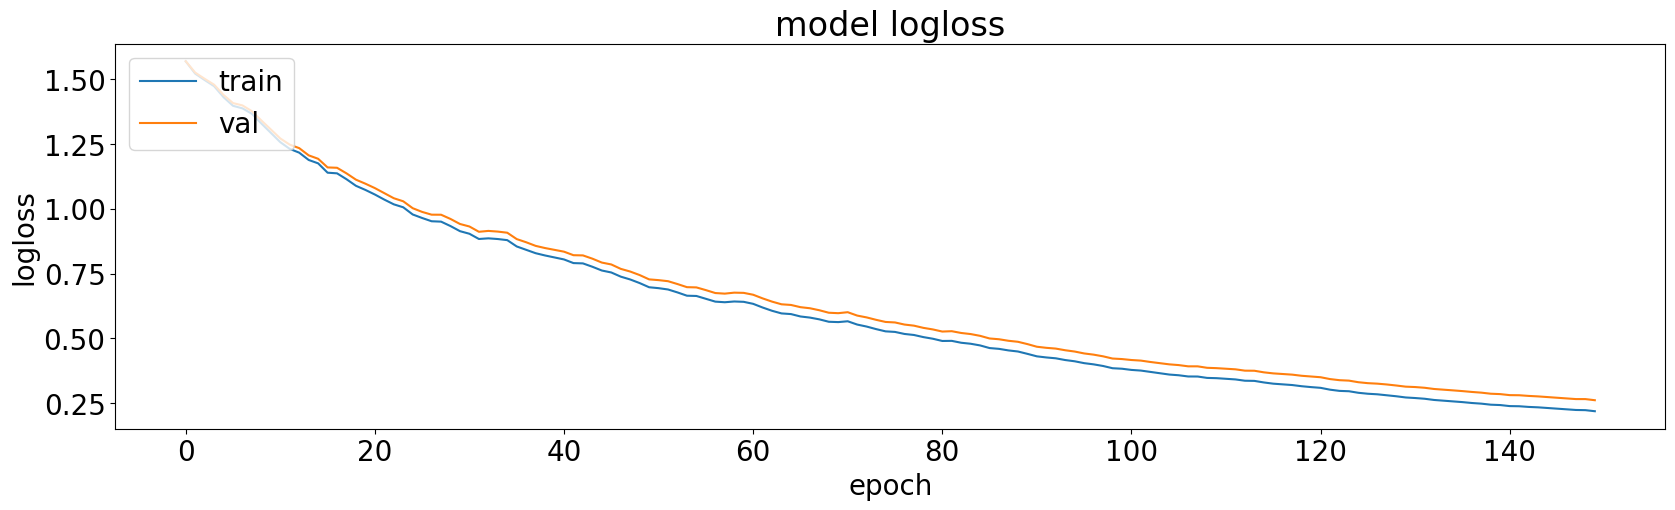

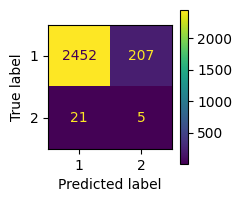

              precision    recall  f1-score   support

           1       0.99      0.92      0.96      2659
           2       0.02      0.19      0.04        26

    accuracy                           0.92      2685
   macro avg       0.51      0.56      0.50      2685
weighted avg       0.98      0.92      0.95      2685

| 61        | 0.4964    | 0.99      | 0.2238    | 0.03293   | 7.491     | 3.935     | 0.6227    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


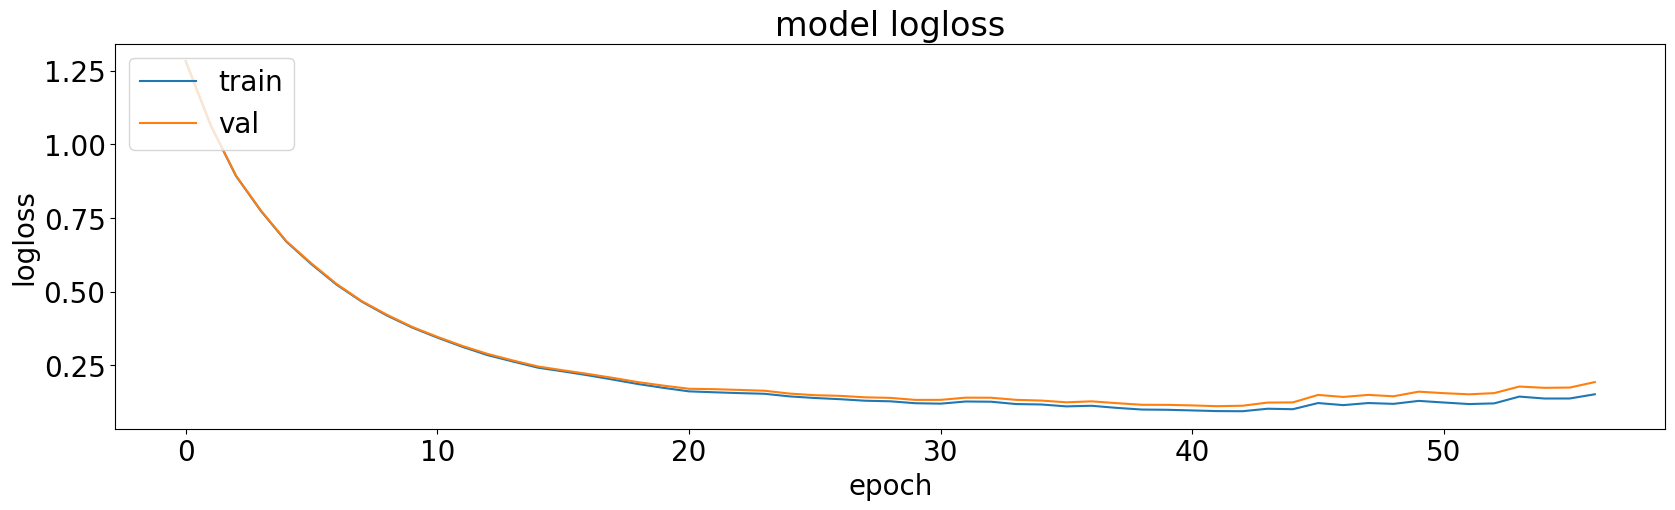

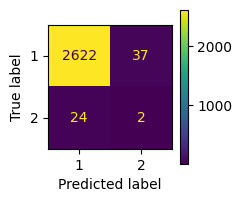

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.05      0.08      0.06        26

    accuracy                           0.98      2685
   macro avg       0.52      0.53      0.53      2685
weighted avg       0.98      0.98      0.98      2685

| 62        | 0.5157    | 0.1       | 0.3       | 0.1       | 13.71     | 5.875     | 0.1       |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


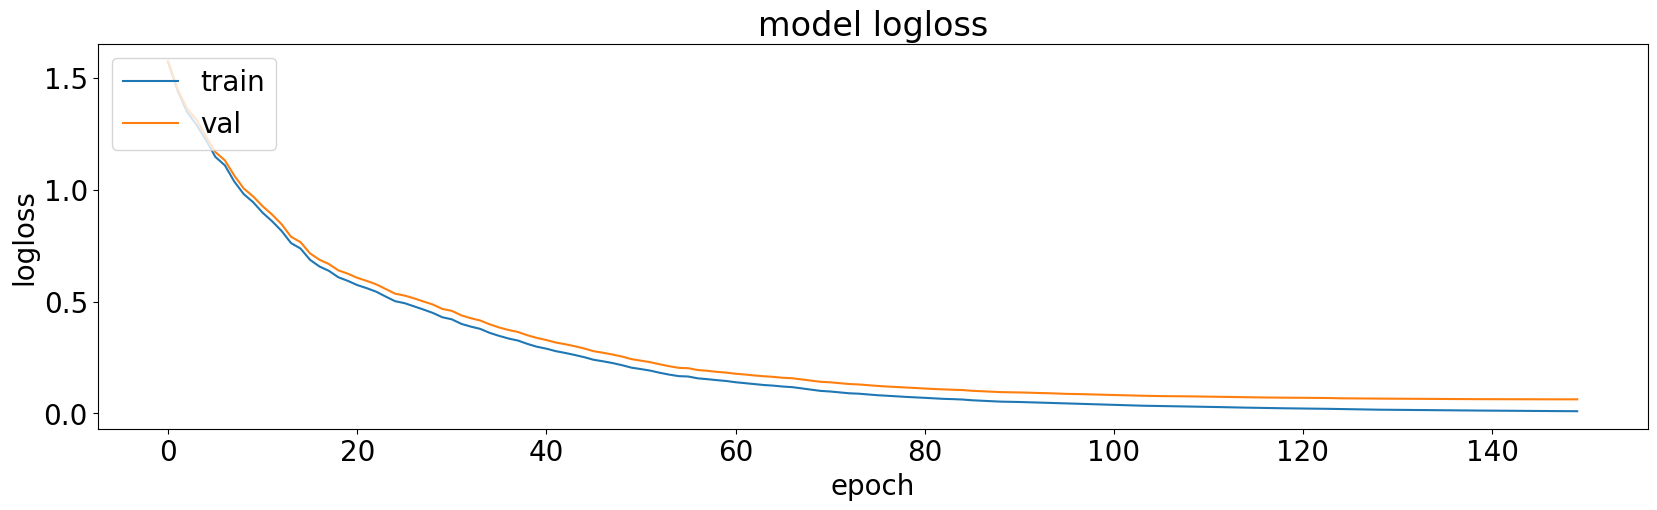

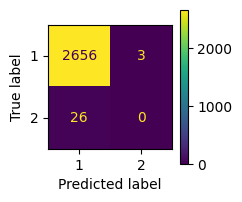

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 63        | 0.4971    | 0.9202    | 0.3       | 0.1       | 6.214     | 1.0       | 1.0       |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


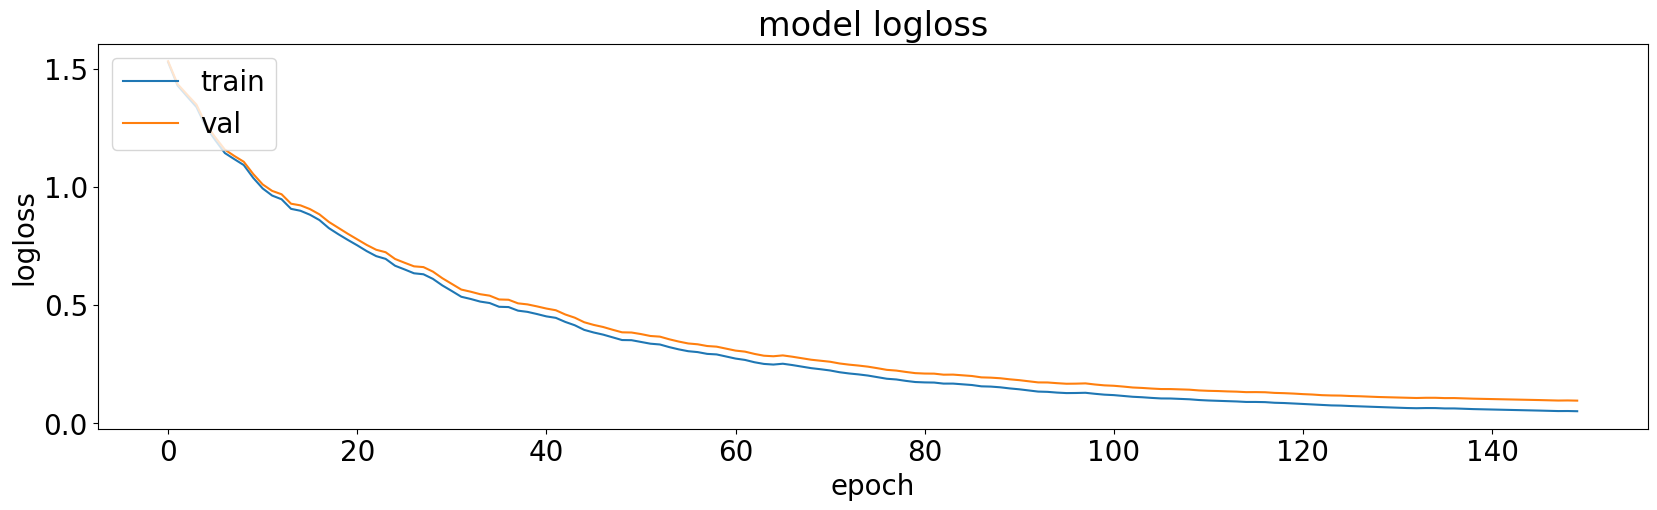

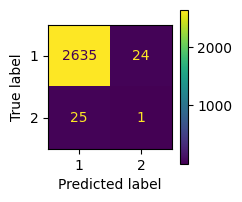

              precision    recall  f1-score   support

           1       0.99      0.99      0.99      2659
           2       0.04      0.04      0.04        26

    accuracy                           0.98      2685
   macro avg       0.52      0.51      0.52      2685
weighted avg       0.98      0.98      0.98      2685

| 64        | 0.5147    | 0.115     | 0.1304    | 0.04432   | 12.05     | 7.293     | 0.497     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


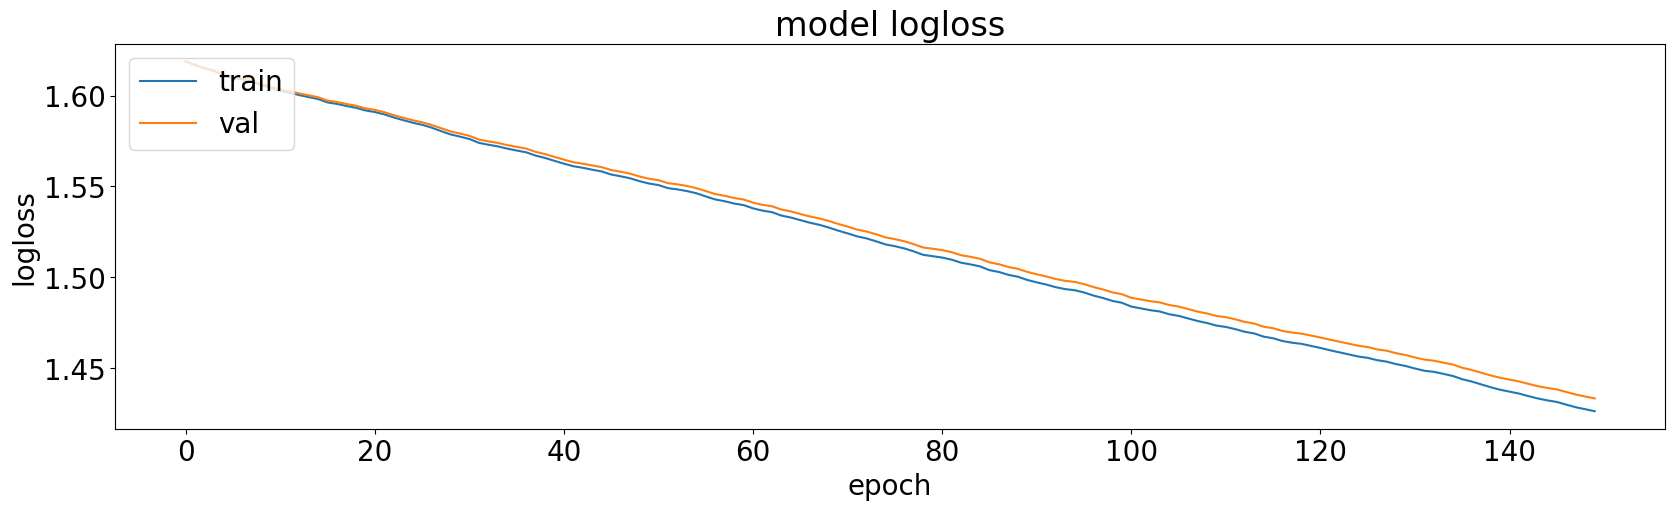

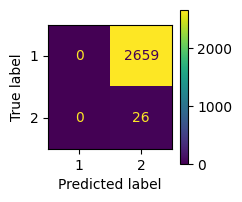

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.01      2685
   macro avg       0.00      0.50      0.01      2685
weighted avg       0.00      0.01      0.00      2685

| 65        | 0.009549  | 1.0       | 0.0       | 0.001     | 8.973     | 10.0      | 0.7601    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


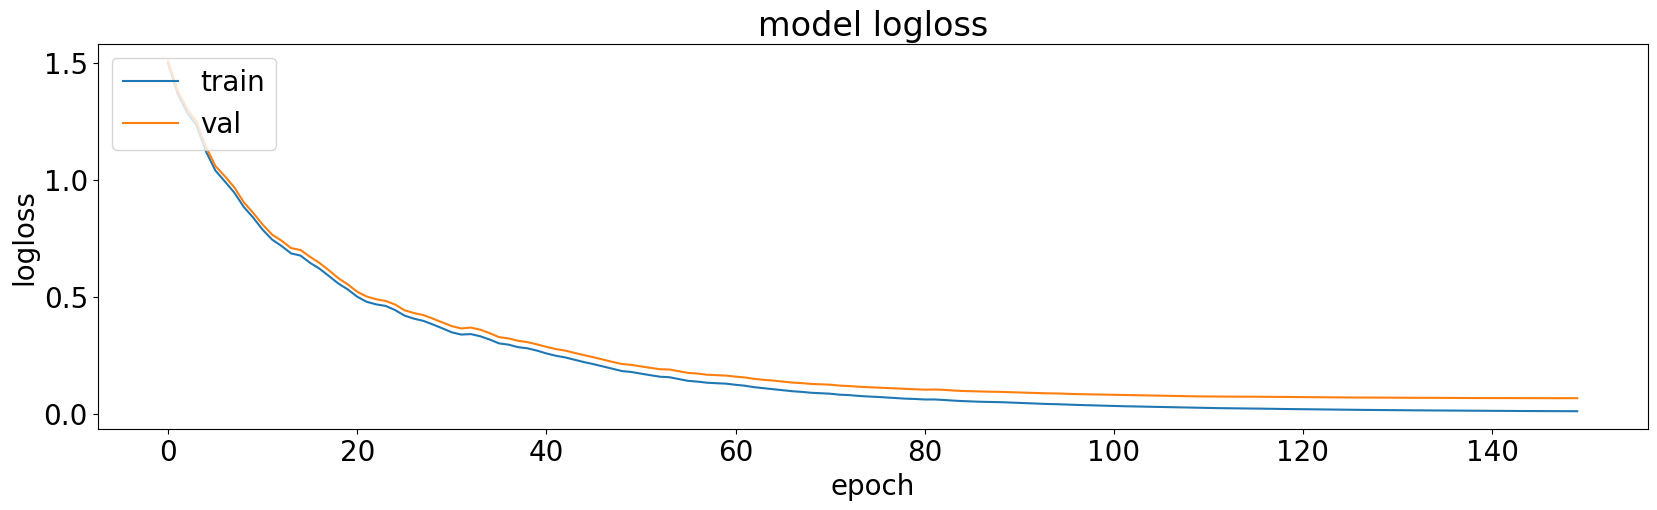

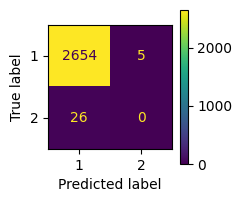

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 66        | 0.4971    | 0.1688    | 0.2012    | 0.0694    | 11.23     | 3.519     | 0.6554    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:20:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


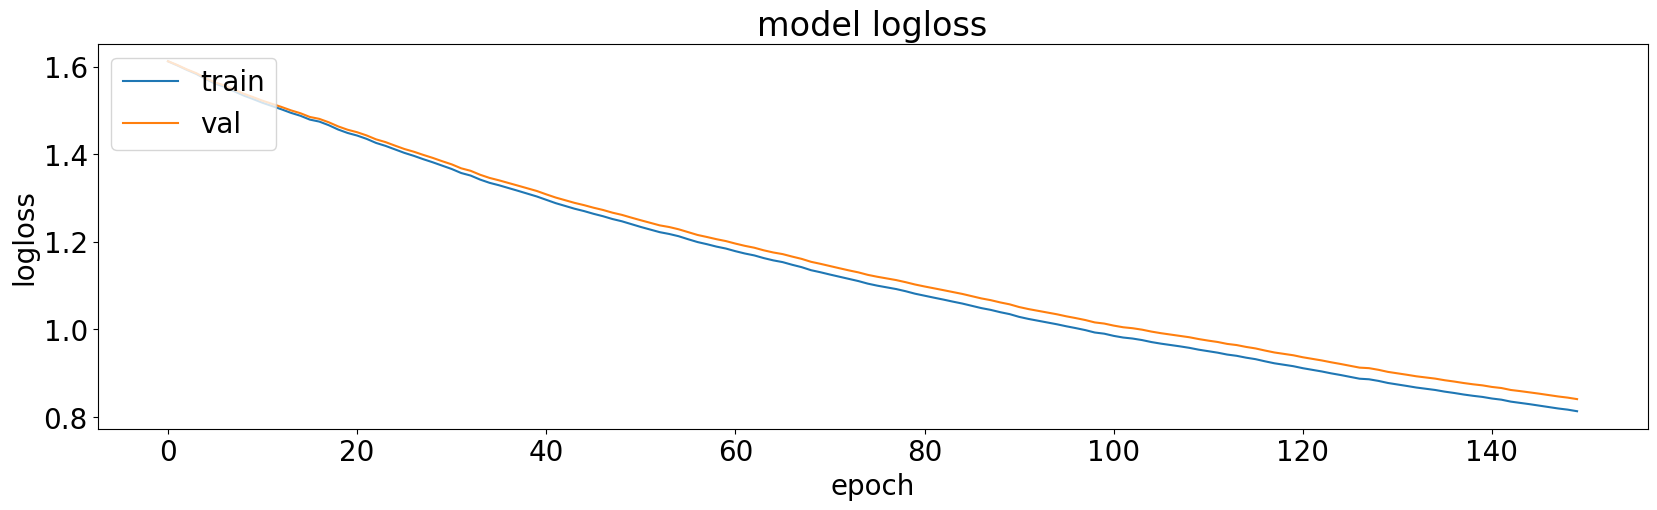

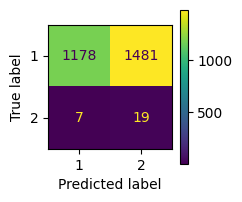

              precision    recall  f1-score   support

           1       0.99      0.44      0.61      2659
           2       0.01      0.73      0.02        26

    accuracy                           0.45      2685
   macro avg       0.50      0.59      0.32      2685
weighted avg       0.98      0.45      0.61      2685

| 67        | 0.3122    | 0.8485    | 0.002209  | 0.004879  | 12.69     | 1.813     | 0.7808    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:21:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


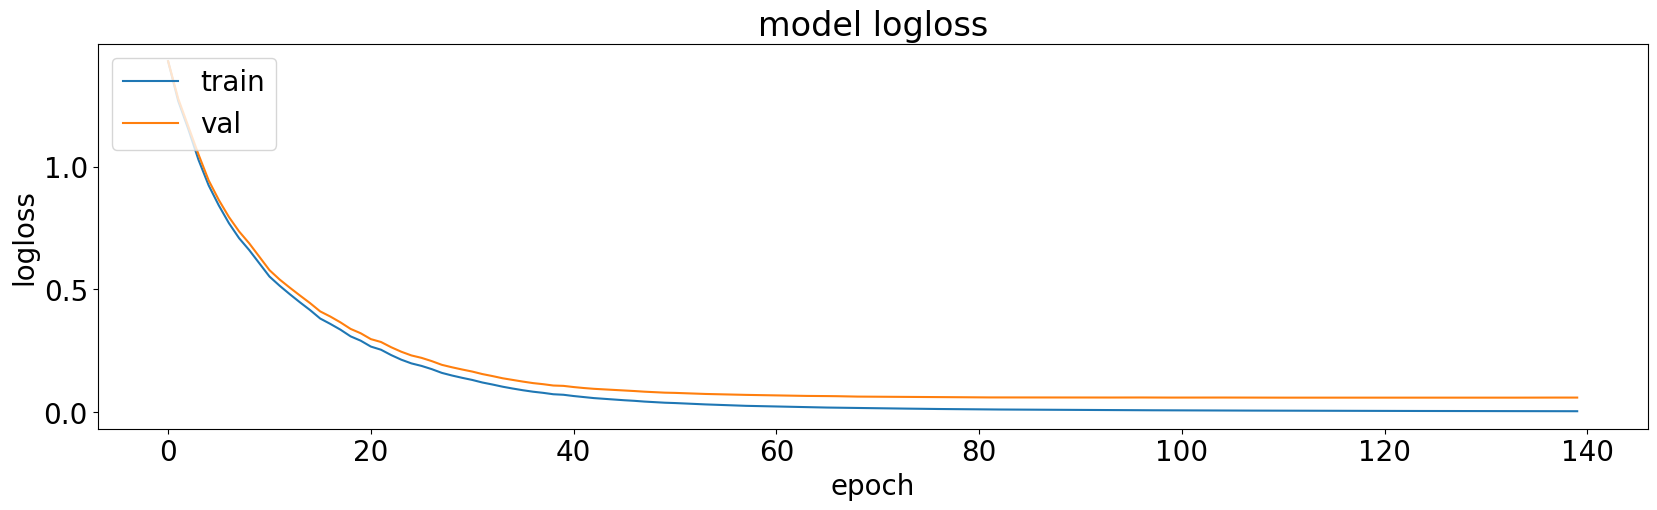

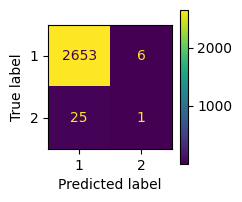

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.14      0.04      0.06        26

    accuracy                           0.99      2685
   macro avg       0.57      0.52      0.53      2685
weighted avg       0.98      0.99      0.99      2685

| 68        | 0.4972    | 0.1       | 0.0       | 0.1       | 13.55     | 6.213     | 0.7955    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:21:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


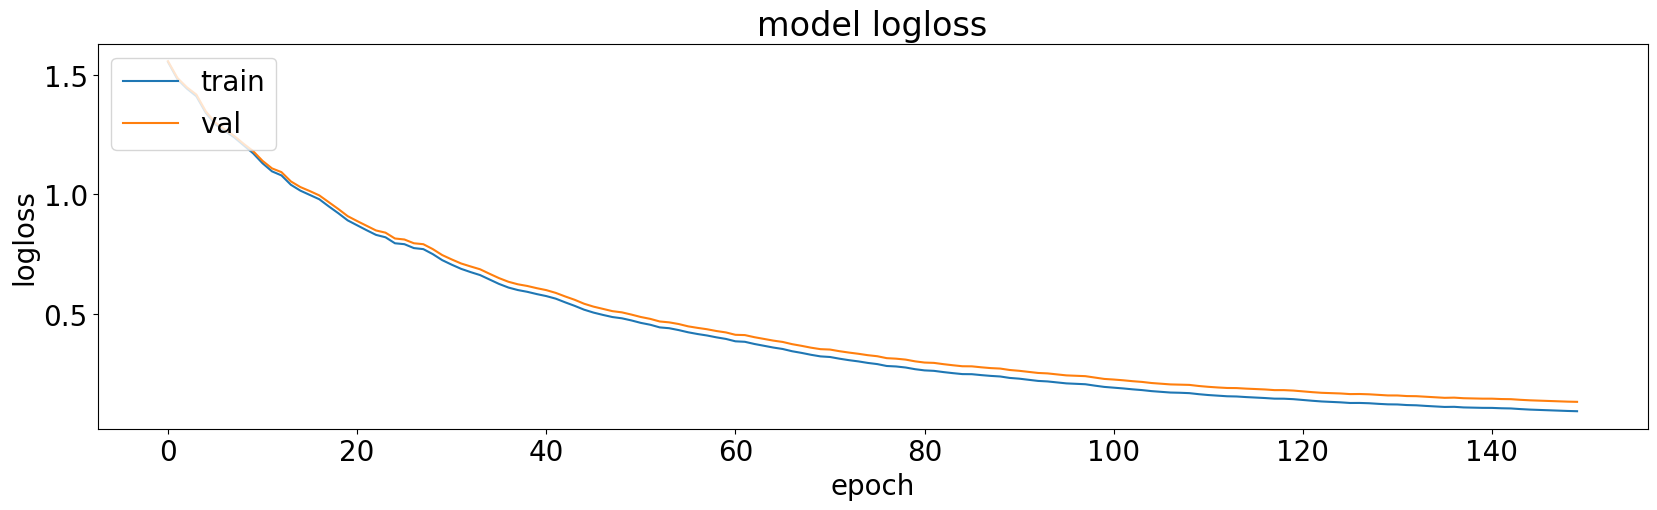

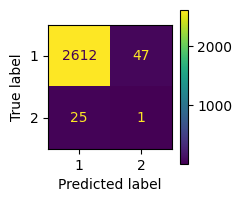

              precision    recall  f1-score   support

           1       0.99      0.98      0.99      2659
           2       0.02      0.04      0.03        26

    accuracy                           0.97      2685
   macro avg       0.51      0.51      0.51      2685
weighted avg       0.98      0.97      0.98      2685

| 69        | 0.4909    | 0.683     | 0.2962    | 0.03027   | 13.77     | 6.179     | 0.511     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:21:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


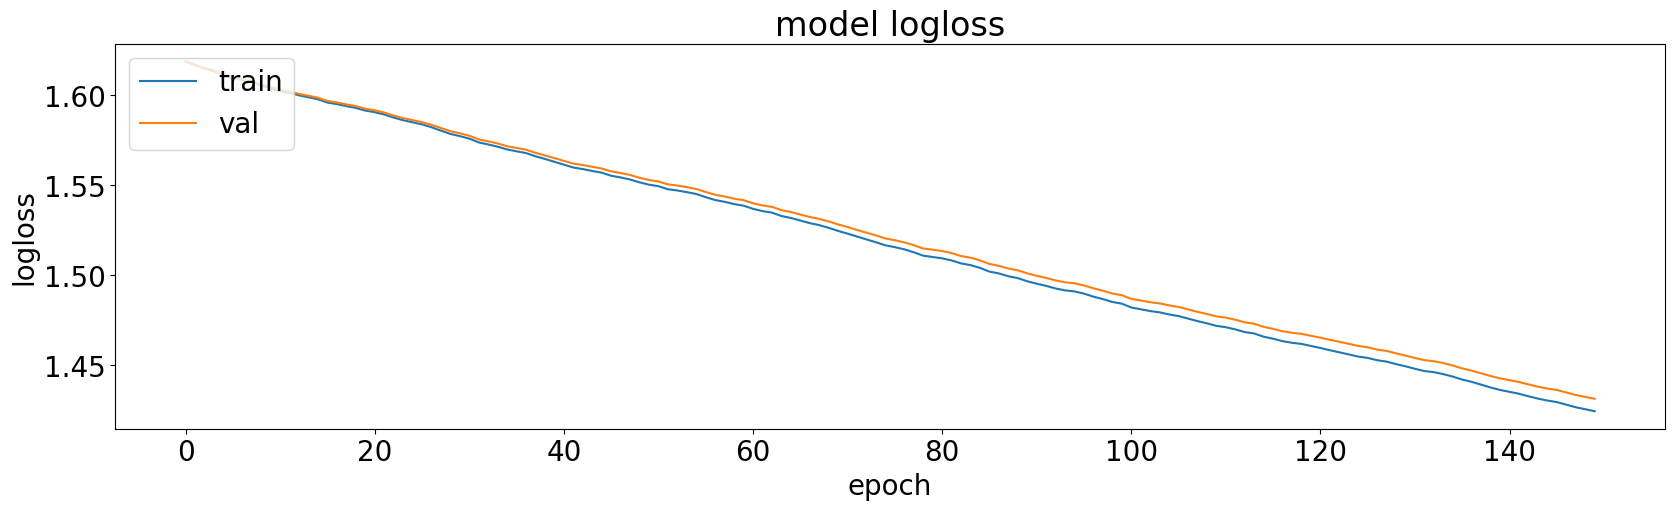

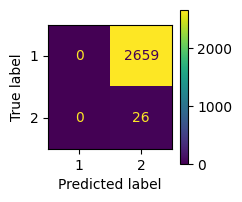

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.01      2685
   macro avg       0.00      0.50      0.01      2685
weighted avg       0.00      0.01      0.00      2685

| 70        | 0.009549  | 0.1       | 0.0       | 0.001     | 8.802     | 4.474     | 0.762     |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:21:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


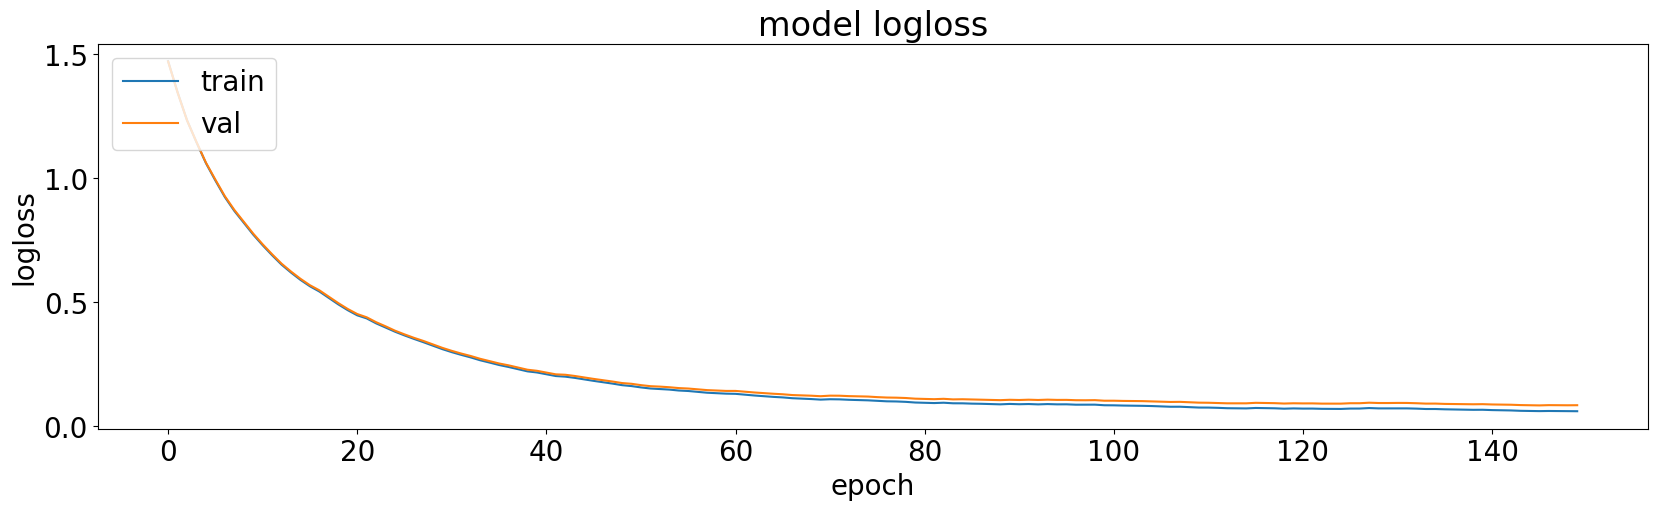

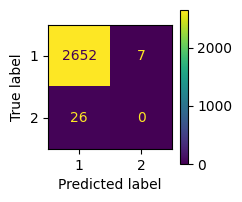

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 71        | 0.4969    | 0.1535    | 0.1979    | 0.04322   | 14.11     | 6.556     | 0.1081    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:21:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


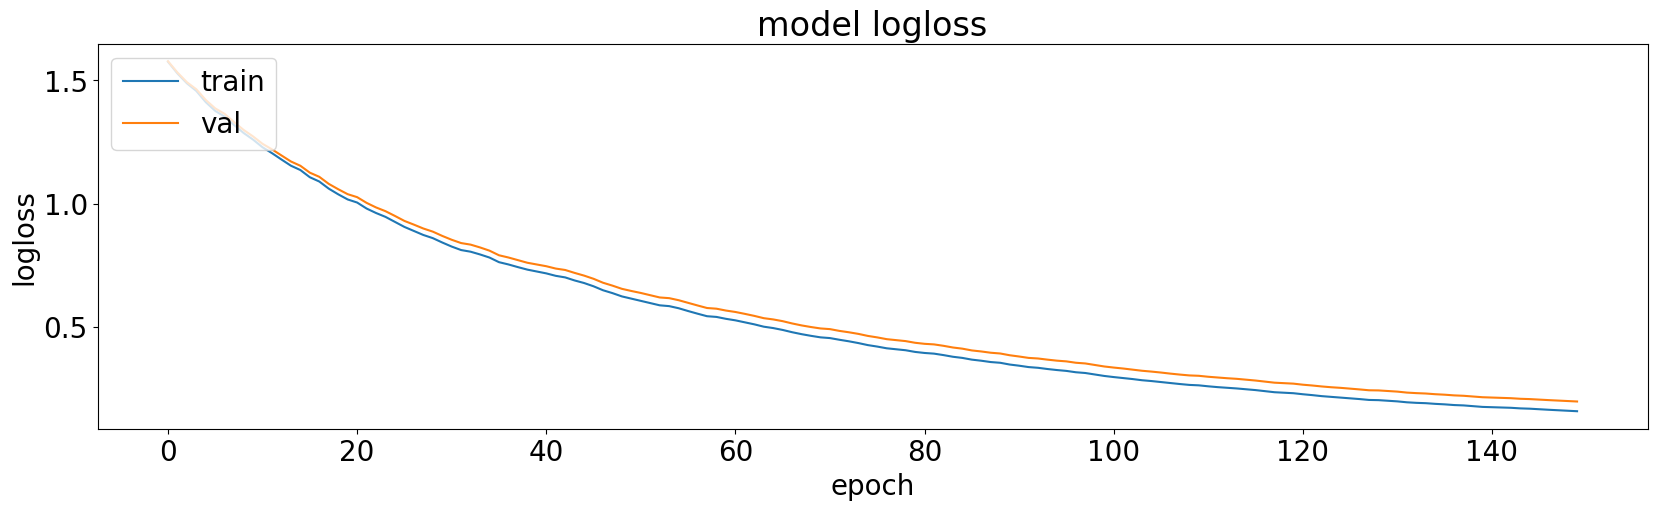

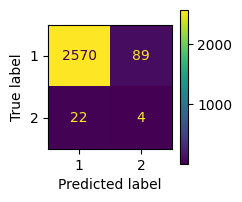

              precision    recall  f1-score   support

           1       0.99      0.97      0.98      2659
           2       0.04      0.15      0.07        26

    accuracy                           0.96      2685
   macro avg       0.52      0.56      0.52      2685
weighted avg       0.98      0.96      0.97      2685

| 72        | 0.4983    | 0.2555    | 0.08281   | 0.02256   | 12.67     | 6.777     | 0.6809    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:21:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


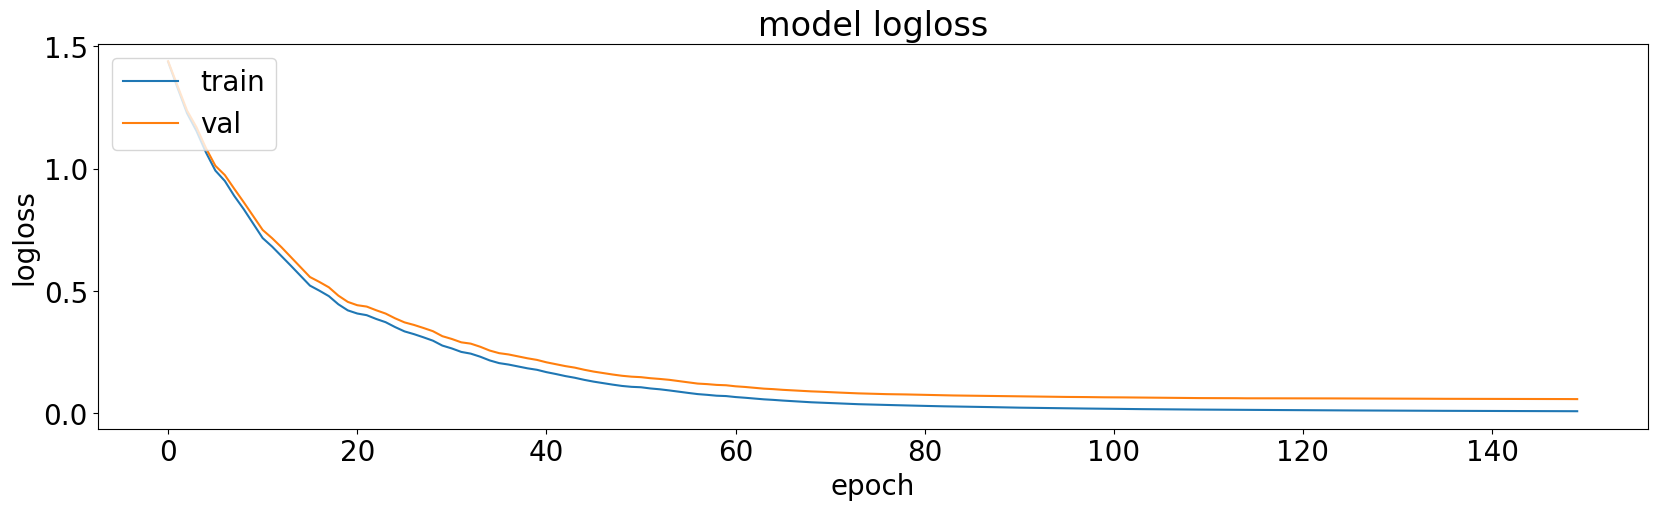

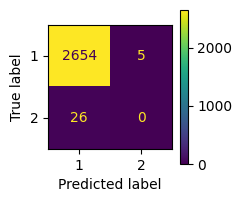

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 73        | 0.4974    | 0.5351    | 0.2281    | 0.08129   | 12.37     | 8.884     | 0.7409    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:21:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


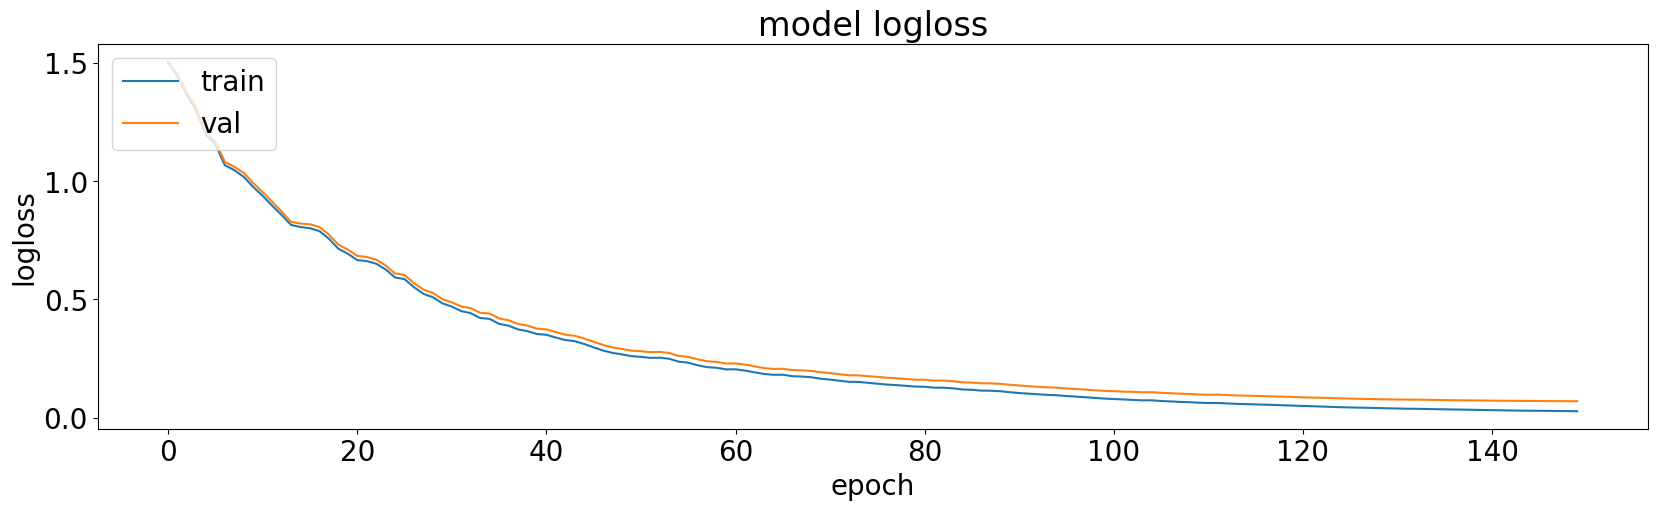

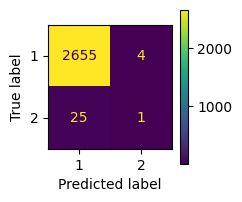

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.20      0.04      0.06        26

    accuracy                           0.99      2685
   macro avg       0.60      0.52      0.53      2685
weighted avg       0.98      0.99      0.99      2685

| 74        | 0.497     | 0.4406    | 0.02482   | 0.05121   | 8.094     | 1.261     | 0.2404    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:22:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


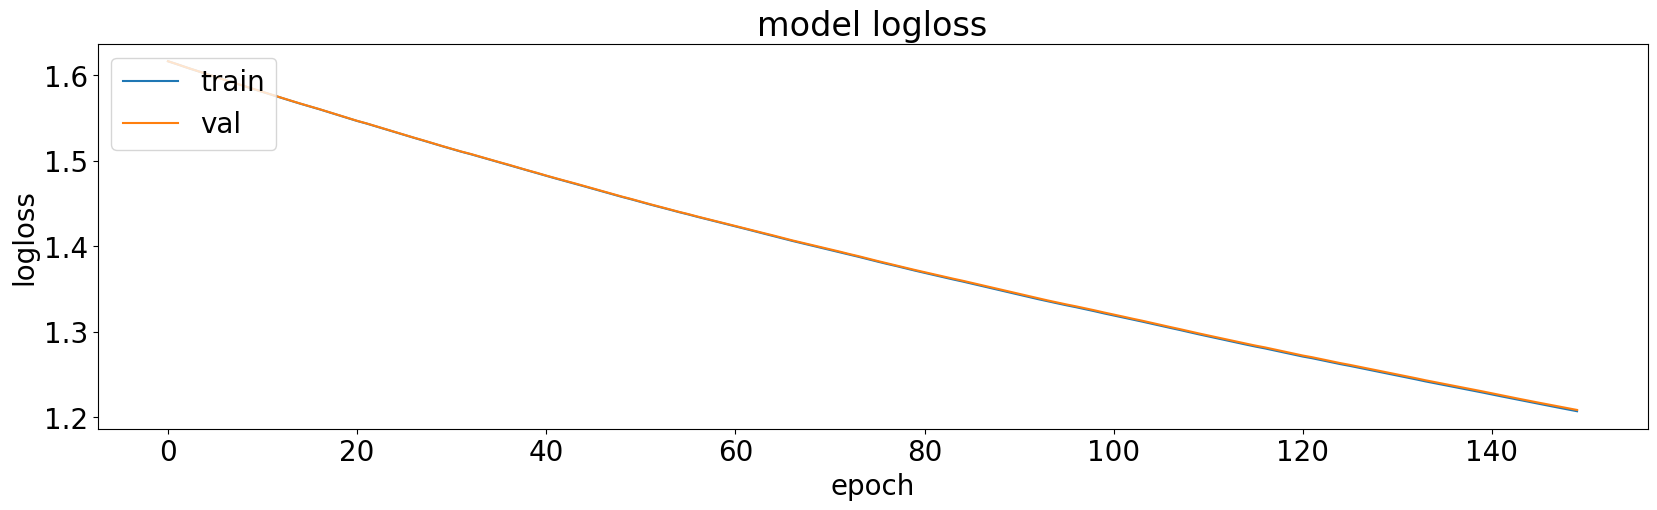

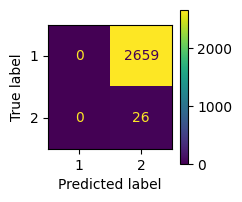

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2659
           2       0.01      1.00      0.02        26

    accuracy                           0.01      2685
   macro avg       0.00      0.50      0.01      2685
weighted avg       0.00      0.01      0.00      2685

| 75        | 0.009549  | 0.4586    | 0.0       | 0.001     | 13.05     | 5.967     | 0.1       |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:22:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


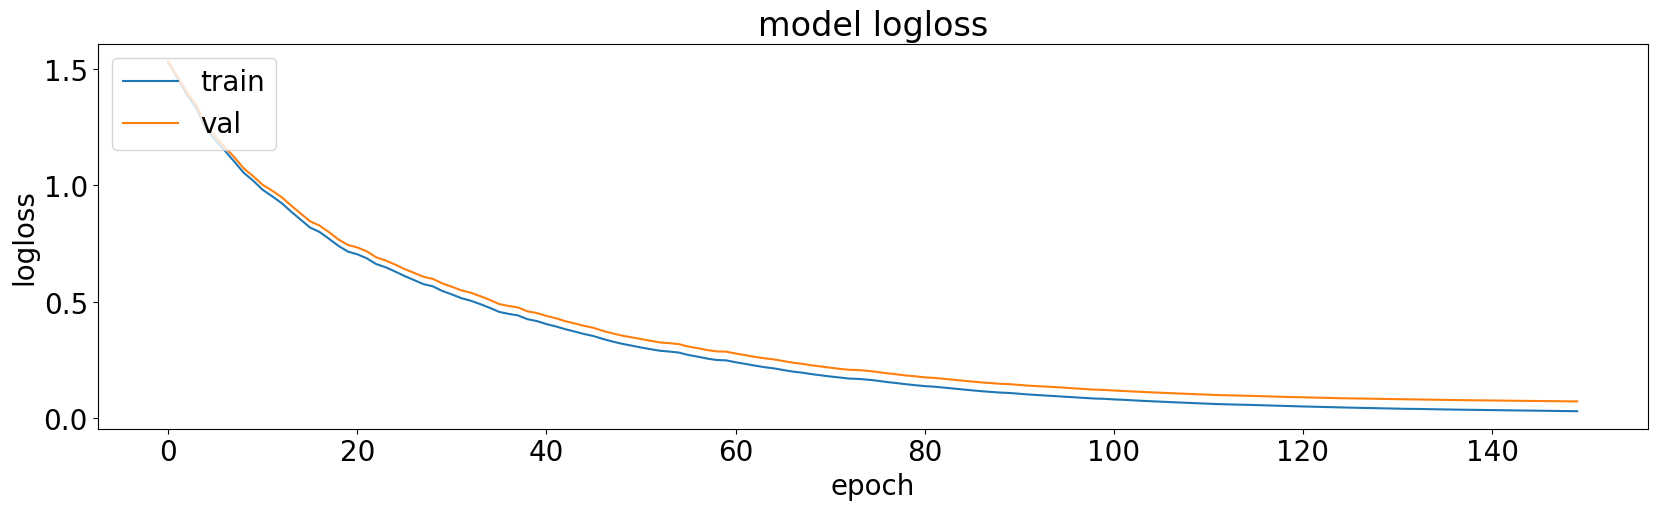

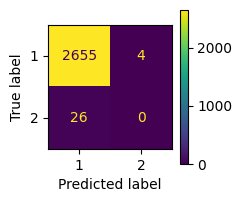

              precision    recall  f1-score   support

           1       0.99      1.00      0.99      2659
           2       0.00      0.00      0.00        26

    accuracy                           0.99      2685
   macro avg       0.50      0.50      0.50      2685
weighted avg       0.98      0.99      0.98      2685

| 76        | 0.4964    | 0.8382    | 0.2569    | 0.04194   | 12.8      | 9.959     | 0.7275    |


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:22:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_betree" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: ignored

In [ ]:
pbounds = {'max_depth': (3, 15),
           'learning_rate': (0.001, 0.1),
           'min_c_weight': (1, 10),
           'gamma': (0, 0.3),
           'subsample': (0.1, 1),
           'colsample_bytree': (0.1, 1),
        }

optimizer = BayesianOptimization(
    f=model_optimize,
    pbounds=pbounds,
    random_state=1
)

# load_logs(optimizer, logs=["./logs.json"])
# logger = JSONLogger(path="./logs.json")
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=50, n_iter=190)